In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
tf.__version__

'2.7.0'

In [3]:
with open('X_train_scaled_dic.pickle', 'rb') as f:
    X_train_scaled_dic = pickle.load(f)
with open('X_test_scaled_dic.pickle', 'rb') as f:
    X_test_scaled_dic = pickle.load(f)
with open('y_train_scaled_dic.pickle', 'rb') as f:
    y_train_scaled_dic= pickle.load(f)
with open('y_test_scaled_dic.pickle', 'rb') as f:
    y_test_scaled_dic= pickle.load(f)

In [4]:
with open('sector.pickle', 'rb') as f:
    sector = pickle.load(f)

In [5]:
X_test_scaled_dic['Food']['097950']

거래량        시가        고가        저가
일자                                                
2020-03-02  0.077567  0.198516  0.201818  0.190196
2020-03-03  0.062357  0.228200  0.214545  0.225490
2020-03-04  0.060793  0.226345  0.238182  0.221569
2020-03-05  0.056935  0.250464  0.240000  0.249020
2020-03-06  0.065331  0.246753  0.245455  0.249020
...              ...       ...       ...       ...
2022-07-27  0.009716  0.758813  0.747273  0.796078
2022-07-28  0.025188  0.755102  0.740000  0.784314
2022-07-29  0.028014  0.762523  0.738182  0.776471
2022-08-01  0.044953  0.740260  0.718182  0.754902
2022-08-02  0.030862  0.723562  0.703636  0.752941

[600 rows x 4 columns]

In [6]:
y_test_scaled_dic['Food']['097950']

종가
일자                  
2020-03-02  0.204887
2020-03-03  0.214286
2020-03-04  0.248120
2020-03-05  0.251880
2020-03-06  0.259398
...              ...
2022-07-27  0.761278
2022-07-28  0.761278
2022-07-29  0.748120
2022-08-01  0.731203
2022-08-02  0.725564

[600 rows x 1 columns]

# 윈도우 데이터 셋 생성

In [7]:
# 윈도우 데이터셋 생성 함수
def windowed_dataset(X, y, X_size, y_size, X_shift, y_shift, X_stride, y_stride, batch_size):
    
    # numpy array x(input)를 Dataset으로 변환
    ds_x = tf.data.Dataset.from_tensor_slices(X)
    
    #윈도우셋 구성
    ds_x = ds_x.window(size=X_size,stride=X_stride, shift=X_shift, drop_remainder=True)
    #한 차원 줄야사 반환
    ds_x = ds_x.flat_map(lambda x: x.batch(X_size))
    
    ds_y = tf.data.Dataset.from_tensor_slices(y)
    ds_y = ds_y.window(size=y_size, stride=y_stride, shift=y_shift, drop_remainder=True)
    ds_y = ds_y.flat_map(lambda y: y.batch(y_size))
    
    #같은 인덱스에 있는 애들 끼리 묶기
    ds = tf.data.Dataset.zip((ds_x, ds_y))

    
    return ds.batch(batch_size).prefetch(1)

## 파라미터 지정

In [8]:
#윈도우 사이즈
WINDOW_SIZE = 20
# X에 대한 윈도우 함수 설정값
X_size = WINDOW_SIZE
X_shift = 1
X_stride = 1
# y에 대한 윈도우 함수 설정값
y_size = 1
y_shift = 1
y_stride = 1

batch_size = 32

In [9]:
tf_dataset_train_dic={}
for sector_name, sector_df in X_train_scaled_dic.items():
    tf_dataset_train_dic[sector_name] = {}
    for stock_code, df in sector_df.items():
        X_train = df
        y_train = y_train_scaled_dic[sector_name][stock_code]
        tf_dataset_train_dic[sector_name][stock_code] = windowed_dataset(X_train,y_train[WINDOW_SIZE:], X_size, y_size,
                                    X_shift, y_shift, X_stride, y_stride, batch_size)

        
        
tf_dataset_test_dic={}
for sector_name, sector_df in X_test_scaled_dic.items():
    tf_dataset_test_dic[sector_name] = {}
    for stock_code, df in sector_df.items():
        X_test = df
        y_test = y_test_scaled_dic[sector_name][stock_code]
        tf_dataset_test_dic[sector_name][stock_code] = windowed_dataset(X_test,y_test[WINDOW_SIZE:], X_size, y_size,
                                    X_shift, y_shift, X_stride, y_stride, batch_size)

In [10]:
# 데이터 shape, 미리보기로 체크
for x, y in tf_dataset_train_dic['Food']['097950'].take(1):
    print('X:', x.shape)
    print(x[:3])
    print()
    print('Y:', y.shape)
    print(y[:3])
    print('-'*100)

X: (32, 20, 4)
tf.Tensor(
[[[0.13278169 0.09276438 0.09272727 0.08039216]
  [0.05219137 0.0890538  0.09272727 0.09607843]
  [0.03844258 0.1038961  0.09454545 0.09803922]
  ...
  [0.38909651 0.13543599 0.18363636 0.14313725]
  [0.24906653 0.20593692 0.20545455 0.2       ]
  [0.140322   0.20037106 0.20363636 0.20588235]]

 [[0.05219137 0.0890538  0.09272727 0.09607843]
  [0.03844258 0.1038961  0.09454545 0.09803922]
  [0.04950744 0.09647495 0.08909091 0.09411765]
  ...
  [0.24906653 0.20593692 0.20545455 0.2       ]
  [0.140322   0.20037106 0.20363636 0.20588235]
  [0.09547514 0.20779221 0.19818182 0.20196078]]

 [[0.03844258 0.1038961  0.09454545 0.09803922]
  [0.04950744 0.09647495 0.08909091 0.09411765]
  [0.14539276 0.09461967 0.08545455 0.08823529]
  ...
  [0.140322   0.20037106 0.20363636 0.20588235]
  [0.09547514 0.20779221 0.19818182 0.20196078]
  [0.10191487 0.19851577 0.19090909 0.2       ]]

 ...

 [[0.02889692 0.22077922 0.20727273 0.21372549]
  [0.07975814 0.19109462 0.19272

In [11]:
X_train_scaled_dic['Food']['097950'].iloc[:30]

거래량        시가        고가        저가
일자                                                
2010-06-08  0.067022  0.070501  0.069091  0.072549
2010-06-09  0.069804  0.074212  0.085455  0.076471
2010-06-10  0.084692  0.083488  0.090909  0.088235
2010-06-11  0.132782  0.092764  0.092727  0.080392
2010-06-14  0.052191  0.089054  0.092727  0.096078
2010-06-15  0.038443  0.103896  0.094545  0.098039
2010-06-16  0.049507  0.096475  0.089091  0.094118
2010-06-17  0.145393  0.094620  0.085455  0.088235
2010-06-18  0.059873  0.094620  0.083636  0.088235
2010-06-21  0.100630  0.083488  0.090909  0.088235
2010-06-22  0.087182  0.094620  0.085455  0.084314
2010-06-23  0.047919  0.081633  0.078182  0.086275
2010-06-24  0.050721  0.085343  0.087273  0.088235
2010-06-25  0.121751  0.103896  0.096364  0.103922
2010-06-28  0.092030  0.107607  0.105455  0.115686
2010-06-29  0.095264  0.122449  0.121818  0.125490
2010-06-30  0.073970  0.111317  0.116364  0.117647
2010-07-01  0.061261  0.111317  0.112727  0.105882
2010-07-02  0.076038  0.115028  0.103636  0.098039
2010-07-05  0.150958  0.107607  0.129091  0.105882

In [12]:
y_train_scaled_dic['Food']['097950'].iloc[[21,22,23]]

종가
일자                  
2010-06-22  0.080827
2010-07-06  0.186090
2010-07-20  0.191729

In [13]:
for sector_name, sector_tf in tf_dataset_train_dic.items():
    for stock_code, tf_dataset in sector_tf.items():
        for data in tf_dataset.take(1):
            print(stock_code)
            print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
            print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

097950
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
271560
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
000080
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
004370
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
005300
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
093050
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
020000
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
105630
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32

036570
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
005380
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
000270
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
012330
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
033780
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)
009150
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)


# 모델

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
model_dic ={}
for sector_name, stock_list in sector.items():
    model_dic[sector_name] = {}
    for stock_code in stock_list:
        model_dic[sector_name][stock_code] = Sequential([
            # 1차원 feature map 생성
            Conv1D(filters=32, kernel_size=5,
                   padding="causal",
                   activation="relu",
                   #feature의 개수 3개
                   input_shape=[WINDOW_SIZE, 4]),
            # LSTM
            LSTM(16, activation='tanh'),
            Dense(16, activation="relu"),
            Dense(1),
        ])

In [16]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
for sector_name, sector_model_dic in model_dic.items():
    for model in sector_model_dic.values():
        model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [17]:
model_dic['Food']['097950']

In [18]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

In [19]:
filename_dic={}
for sector_name,stock_list in sector.items():
    filename_dic[sector_name] = {}
    for stock_code in stock_list:
        filename_dic[sector_name][stock_code] = os.path.join('Models',sector_name, stock_code+'ckeckpointer.ckpt')
with open('filename_dic.pickle' , 'wb') as f:
    pickle.dump(filename_dic, f)

In [20]:
filename_dic['Food']

{'097950': 'Models\\Food\\097950ckeckpointer.ckpt',
 '271560': 'Models\\Food\\271560ckeckpointer.ckpt',
 '000080': 'Models\\Food\\000080ckeckpointer.ckpt',
 '004370': 'Models\\Food\\004370ckeckpointer.ckpt',
 '005300': 'Models\\Food\\005300ckeckpointer.ckpt'}

In [21]:
#체크포인트를 저장    
mc_dic = {}
for sector_name, filename_sector_dic in filename_dic.items():
    mc_dic[sector_name] = {}
    for stock_code, filename in filename_sector_dic.items():
        mc_dic[sector_name][stock_code] = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [22]:
history_dic={}
# 학습+저장
for sector_name, tf_dataset_dic in tf_dataset_train_dic.items():
    history_dic[sector_name] = {}
    for stock_code, train_data in tf_dataset_dic.items():
        mc = mc_dic[sector_name][stock_code]
        test_data = tf_dataset_test_dic[sector_name][stock_code]
        history = model_dic[sector_name][stock_code].fit(train_data, 
                            validation_data=(test_data), 
                            epochs=50, 
                            callbacks=[mc, earlystopping])
        history_dic[sector_name][stock_code] = history


Epoch 1/50
75/75 [==============================] - 10s 90ms/step - loss: 0.0038 - mse: 0.0077 - val_loss: 0.0108 - val_mse: 0.0215

Epoch 00001: val_loss improved from inf to 0.01076, saving model to Models\Food\097950ckeckpointer.ckpt
Epoch 2/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0018 - mse: 0.0037 - val_loss: 0.0067 - val_mse: 0.0134

Epoch 00002: val_loss improved from 0.01076 to 0.00669, saving model to Models\Food\097950ckeckpointer.ckpt
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0067 - val_mse: 0.0134

Epoch 00003: val_loss improved from 0.00669 to 0.00668, saving model to Models\Food\097950ckeckpointer.ckpt
Epoch 4/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 0.0062 - val_mse: 0.0124

Epoch 00004: val_loss improved from 0.00668 to 0.00622, saving model to Models\Food\097950ckeckpointer.ckpt
Epoch 5/50
75/75 [=========================

75/75 [==============================] - 1s 13ms/step - loss: 5.8350e-04 - mse: 0.0012 - val_loss: 0.0029 - val_mse: 0.0058

Epoch 00037: val_loss improved from 0.00290 to 0.00289, saving model to Models\Food\097950ckeckpointer.ckpt
Epoch 38/50
75/75 [==============================] - 1s 14ms/step - loss: 5.6839e-04 - mse: 0.0011 - val_loss: 0.0027 - val_mse: 0.0054

Epoch 00038: val_loss improved from 0.00289 to 0.00272, saving model to Models\Food\097950ckeckpointer.ckpt
Epoch 39/50
75/75 [==============================] - 1s 13ms/step - loss: 5.7037e-04 - mse: 0.0011 - val_loss: 0.0028 - val_mse: 0.0057

Epoch 00039: val_loss did not improve from 0.00272
Epoch 40/50
75/75 [==============================] - 1s 15ms/step - loss: 5.6224e-04 - mse: 0.0011 - val_loss: 0.0027 - val_mse: 0.0053

Epoch 00040: val_loss improved from 0.00272 to 0.00266, saving model to Models\Food\097950ckeckpointer.ckpt
Epoch 41/50
75/75 [==============================] - 1s 13ms/step - loss: 5.5608e-04 - ms

Epoch 23/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0018 - mse: 0.0035 - val_loss: 0.0014 - val_mse: 0.0027

Epoch 00023: val_loss improved from 0.00137 to 0.00135, saving model to Models\Food\271560ckeckpointer.ckpt
Epoch 24/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 0.0013 - val_mse: 0.0026

Epoch 00024: val_loss improved from 0.00135 to 0.00129, saving model to Models\Food\271560ckeckpointer.ckpt
Epoch 25/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 0.0013 - val_mse: 0.0025

Epoch 00025: val_loss improved from 0.00129 to 0.00127, saving model to Models\Food\271560ckeckpointer.ckpt
Epoch 26/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0016 - mse: 0.0033 - val_loss: 0.0012 - val_mse: 0.0025

Epoch 00026: val_loss improved from 0.00127 to 0.00123, saving model to Models\Food\271560ckeckpointer.ckpt
Epoch 27/50
31/31 [=================

75/75 [==============================] - 1s 15ms/step - loss: 9.7643e-04 - mse: 0.0020 - val_loss: 0.0029 - val_mse: 0.0059

Epoch 00008: val_loss improved from 0.00311 to 0.00295, saving model to Models\Food\000080ckeckpointer.ckpt
Epoch 9/50
75/75 [==============================] - 1s 16ms/step - loss: 9.5331e-04 - mse: 0.0019 - val_loss: 0.0028 - val_mse: 0.0056

Epoch 00009: val_loss improved from 0.00295 to 0.00282, saving model to Models\Food\000080ckeckpointer.ckpt
Epoch 10/50
75/75 [==============================] - 1s 13ms/step - loss: 9.3606e-04 - mse: 0.0019 - val_loss: 0.0026 - val_mse: 0.0052

Epoch 00010: val_loss improved from 0.00282 to 0.00262, saving model to Models\Food\000080ckeckpointer.ckpt
Epoch 11/50
75/75 [==============================] - 1s 15ms/step - loss: 9.2064e-04 - mse: 0.0018 - val_loss: 0.0025 - val_mse: 0.0050

Epoch 00011: val_loss improved from 0.00262 to 0.00252, saving model to Models\Food\000080ckeckpointer.ckpt
Epoch 12/50
75/75 [==============

75/75 [==============================] - 1s 15ms/step - loss: 7.2463e-04 - mse: 0.0014 - val_loss: 0.0015 - val_mse: 0.0029

Epoch 00042: val_loss improved from 0.00147 to 0.00145, saving model to Models\Food\000080ckeckpointer.ckpt
Epoch 43/50
75/75 [==============================] - 1s 14ms/step - loss: 7.1763e-04 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0029

Epoch 00043: val_loss improved from 0.00145 to 0.00144, saving model to Models\Food\000080ckeckpointer.ckpt
Epoch 44/50
75/75 [==============================] - 1s 15ms/step - loss: 7.1191e-04 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0029

Epoch 00044: val_loss improved from 0.00144 to 0.00143, saving model to Models\Food\000080ckeckpointer.ckpt
Epoch 45/50
75/75 [==============================] - 1s 13ms/step - loss: 7.0541e-04 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0028

Epoch 00045: val_loss improved from 0.00143 to 0.00142, saving model to Models\Food\000080ckeckpointer.ckpt
Epoch 46/50
75/75 [=============


Epoch 00003: val_loss improved from 0.00173 to 0.00074, saving model to Models\Food\005300ckeckpointer.ckpt
Epoch 4/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0019 - mse: 0.0039 - val_loss: 5.8273e-04 - val_mse: 0.0012

Epoch 00004: val_loss improved from 0.00074 to 0.00058, saving model to Models\Food\005300ckeckpointer.ckpt
Epoch 5/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0018 - mse: 0.0037 - val_loss: 5.6576e-04 - val_mse: 0.0011

Epoch 00005: val_loss improved from 0.00058 to 0.00057, saving model to Models\Food\005300ckeckpointer.ckpt
Epoch 6/50
75/75 [==============================] - 1s 15ms/step - loss: 0.0016 - mse: 0.0031 - val_loss: 5.9162e-04 - val_mse: 0.0012

Epoch 00006: val_loss did not improve from 0.00057
Epoch 7/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0013 - mse: 0.0027 - val_loss: 5.6162e-04 - val_mse: 0.0011

Epoch 00007: val_loss improved from 0.00057 to 0.00056, saving model to Models\F

75/75 [==============================] - 1s 15ms/step - loss: 5.0430e-04 - mse: 0.0010 - val_loss: 2.4230e-04 - val_mse: 4.8459e-04

Epoch 00023: val_loss improved from 0.00025 to 0.00024, saving model to Models\Clothing\093050ckeckpointer.ckpt
Epoch 24/50
75/75 [==============================] - 1s 15ms/step - loss: 4.9555e-04 - mse: 9.9110e-04 - val_loss: 2.3634e-04 - val_mse: 4.7269e-04

Epoch 00024: val_loss improved from 0.00024 to 0.00024, saving model to Models\Clothing\093050ckeckpointer.ckpt
Epoch 25/50
75/75 [==============================] - 1s 13ms/step - loss: 4.8771e-04 - mse: 9.7542e-04 - val_loss: 2.3221e-04 - val_mse: 4.6442e-04

Epoch 00025: val_loss improved from 0.00024 to 0.00023, saving model to Models\Clothing\093050ckeckpointer.ckpt
Epoch 26/50
75/75 [==============================] - 1s 14ms/step - loss: 4.8040e-04 - mse: 9.6080e-04 - val_loss: 2.2787e-04 - val_mse: 4.5574e-04

Epoch 00026: val_loss improved from 0.00023 to 0.00023, saving model to Models\Cloth

75/75 [==============================] - 1s 13ms/step - loss: 9.0863e-04 - mse: 0.0018 - val_loss: 0.0012 - val_mse: 0.0024

Epoch 00008: val_loss improved from 0.00126 to 0.00120, saving model to Models\Clothing\020000ckeckpointer.ckpt
Epoch 9/50
75/75 [==============================] - 1s 15ms/step - loss: 8.7112e-04 - mse: 0.0017 - val_loss: 0.0012 - val_mse: 0.0023

Epoch 00009: val_loss improved from 0.00120 to 0.00115, saving model to Models\Clothing\020000ckeckpointer.ckpt
Epoch 10/50
75/75 [==============================] - 1s 13ms/step - loss: 8.4155e-04 - mse: 0.0017 - val_loss: 0.0011 - val_mse: 0.0022

Epoch 00010: val_loss improved from 0.00115 to 0.00112, saving model to Models\Clothing\020000ckeckpointer.ckpt
Epoch 11/50
75/75 [==============================] - 1s 12ms/step - loss: 8.1731e-04 - mse: 0.0016 - val_loss: 0.0011 - val_mse: 0.0022

Epoch 00011: val_loss improved from 0.00112 to 0.00109, saving model to Models\Clothing\020000ckeckpointer.ckpt
Epoch 12/50
75/75

75/75 [==============================] - 1s 15ms/step - loss: 5.6741e-04 - mse: 0.0011 - val_loss: 6.9282e-04 - val_mse: 0.0014

Epoch 00041: val_loss improved from 0.00070 to 0.00069, saving model to Models\Clothing\020000ckeckpointer.ckpt
Epoch 42/50
75/75 [==============================] - 1s 14ms/step - loss: 5.6206e-04 - mse: 0.0011 - val_loss: 6.8518e-04 - val_mse: 0.0014

Epoch 00042: val_loss improved from 0.00069 to 0.00069, saving model to Models\Clothing\020000ckeckpointer.ckpt
Epoch 43/50
75/75 [==============================] - 1s 16ms/step - loss: 5.5415e-04 - mse: 0.0011 - val_loss: 6.7667e-04 - val_mse: 0.0014

Epoch 00043: val_loss improved from 0.00069 to 0.00068, saving model to Models\Clothing\020000ckeckpointer.ckpt
Epoch 44/50
75/75 [==============================] - 1s 14ms/step - loss: 5.5030e-04 - mse: 0.0011 - val_loss: 6.7028e-04 - val_mse: 0.0013

Epoch 00044: val_loss improved from 0.00068 to 0.00067, saving model to Models\Clothing\020000ckeckpointer.ckpt



Epoch 00014: val_loss improved from 0.06931 to 0.06801, saving model to Models\Chemical\051910ckeckpointer.ckpt
Epoch 15/50
75/75 [==============================] - 1s 16ms/step - loss: 6.9271e-04 - mse: 0.0014 - val_loss: 0.0672 - val_mse: 0.1345

Epoch 00015: val_loss improved from 0.06801 to 0.06724, saving model to Models\Chemical\051910ckeckpointer.ckpt
Epoch 16/50
75/75 [==============================] - 1s 14ms/step - loss: 6.8040e-04 - mse: 0.0014 - val_loss: 0.0662 - val_mse: 0.1325

Epoch 00016: val_loss improved from 0.06724 to 0.06624, saving model to Models\Chemical\051910ckeckpointer.ckpt
Epoch 17/50
75/75 [==============================] - 1s 16ms/step - loss: 6.6650e-04 - mse: 0.0013 - val_loss: 0.0629 - val_mse: 0.1259

Epoch 00017: val_loss improved from 0.06624 to 0.06294, saving model to Models\Chemical\051910ckeckpointer.ckpt
Epoch 18/50
75/75 [==============================] - 1s 14ms/step - loss: 6.4872e-04 - mse: 0.0013 - val_loss: 0.0628 - val_mse: 0.1256

Epo

75/75 [==============================] - 1s 15ms/step - loss: 4.2381e-04 - mse: 8.4762e-04 - val_loss: 0.0028 - val_mse: 0.0055

Epoch 00045: val_loss improved from 0.00282 to 0.00277, saving model to Models\Chemical\096770ckeckpointer.ckpt
Epoch 46/50
75/75 [==============================] - 1s 15ms/step - loss: 4.1617e-04 - mse: 8.3233e-04 - val_loss: 0.0028 - val_mse: 0.0056

Epoch 00046: val_loss did not improve from 0.00277
Epoch 47/50
75/75 [==============================] - 1s 16ms/step - loss: 4.1427e-04 - mse: 8.2854e-04 - val_loss: 0.0028 - val_mse: 0.0055

Epoch 00047: val_loss improved from 0.00277 to 0.00277, saving model to Models\Chemical\096770ckeckpointer.ckpt
Epoch 48/50
75/75 [==============================] - 1s 14ms/step - loss: 4.1067e-04 - mse: 8.2134e-04 - val_loss: 0.0027 - val_mse: 0.0055

Epoch 00048: val_loss improved from 0.00277 to 0.00273, saving model to Models\Chemical\096770ckeckpointer.ckpt
Epoch 49/50
75/75 [==============================] - 1s 15ms/

75/75 [==============================] - 1s 17ms/step - loss: 5.9214e-04 - mse: 0.0012 - val_loss: 0.0053 - val_mse: 0.0106

Epoch 00009: val_loss improved from 0.00556 to 0.00529, saving model to Models\Chemical\051900ckeckpointer.ckpt
Epoch 10/50
75/75 [==============================] - 1s 14ms/step - loss: 5.6415e-04 - mse: 0.0011 - val_loss: 0.0051 - val_mse: 0.0101

Epoch 00010: val_loss improved from 0.00529 to 0.00505, saving model to Models\Chemical\051900ckeckpointer.ckpt
Epoch 11/50
75/75 [==============================] - 1s 15ms/step - loss: 5.4236e-04 - mse: 0.0011 - val_loss: 0.0049 - val_mse: 0.0097

Epoch 00011: val_loss improved from 0.00505 to 0.00486, saving model to Models\Chemical\051900ckeckpointer.ckpt
Epoch 12/50
75/75 [==============================] - 1s 13ms/step - loss: 5.2671e-04 - mse: 0.0011 - val_loss: 0.0047 - val_mse: 0.0094

Epoch 00012: val_loss improved from 0.00486 to 0.00468, saving model to Models\Chemical\051900ckeckpointer.ckpt
Epoch 13/50
75/7


Epoch 00041: val_loss improved from 0.00175 to 0.00166, saving model to Models\Chemical\051900ckeckpointer.ckpt
Epoch 42/50
75/75 [==============================] - 1s 14ms/step - loss: 3.2762e-04 - mse: 6.5524e-04 - val_loss: 0.0016 - val_mse: 0.0031

Epoch 00042: val_loss improved from 0.00166 to 0.00156, saving model to Models\Chemical\051900ckeckpointer.ckpt
Epoch 43/50
75/75 [==============================] - 1s 15ms/step - loss: 3.2111e-04 - mse: 6.4223e-04 - val_loss: 0.0015 - val_mse: 0.0029

Epoch 00043: val_loss improved from 0.00156 to 0.00147, saving model to Models\Chemical\051900ckeckpointer.ckpt
Epoch 44/50
75/75 [==============================] - 1s 13ms/step - loss: 3.1674e-04 - mse: 6.3348e-04 - val_loss: 0.0014 - val_mse: 0.0028

Epoch 00044: val_loss improved from 0.00147 to 0.00142, saving model to Models\Chemical\051900ckeckpointer.ckpt
Epoch 45/50
75/75 [==============================] - 1s 15ms/step - loss: 3.1355e-04 - mse: 6.2710e-04 - val_loss: 0.0014 - val_

Epoch 12/50
35/35 [==============================] - 0s 14ms/step - loss: 6.5042e-04 - mse: 0.0013 - val_loss: 0.0011 - val_mse: 0.0021

Epoch 00012: val_loss improved from 0.00109 to 0.00107, saving model to Models\Medicine\207940ckeckpointer.ckpt
Epoch 13/50
35/35 [==============================] - 1s 14ms/step - loss: 6.3758e-04 - mse: 0.0013 - val_loss: 0.0010 - val_mse: 0.0021

Epoch 00013: val_loss improved from 0.00107 to 0.00104, saving model to Models\Medicine\207940ckeckpointer.ckpt
Epoch 14/50
35/35 [==============================] - 1s 15ms/step - loss: 6.2915e-04 - mse: 0.0013 - val_loss: 0.0010 - val_mse: 0.0020

Epoch 00014: val_loss improved from 0.00104 to 0.00101, saving model to Models\Medicine\207940ckeckpointer.ckpt
Epoch 15/50
35/35 [==============================] - 1s 16ms/step - loss: 6.2225e-04 - mse: 0.0012 - val_loss: 9.7594e-04 - val_mse: 0.0020

Epoch 00015: val_loss improved from 0.00101 to 0.00098, saving model to Models\Medicine\207940ckeckpointer.ckpt



Epoch 00044: val_loss improved from 0.00067 to 0.00066, saving model to Models\Medicine\207940ckeckpointer.ckpt
Epoch 45/50
35/35 [==============================] - 1s 17ms/step - loss: 5.6132e-04 - mse: 0.0011 - val_loss: 6.5940e-04 - val_mse: 0.0013

Epoch 00045: val_loss improved from 0.00066 to 0.00066, saving model to Models\Medicine\207940ckeckpointer.ckpt
Epoch 46/50
35/35 [==============================] - 1s 17ms/step - loss: 5.6050e-04 - mse: 0.0011 - val_loss: 6.5660e-04 - val_mse: 0.0013

Epoch 00046: val_loss improved from 0.00066 to 0.00066, saving model to Models\Medicine\207940ckeckpointer.ckpt
Epoch 47/50
35/35 [==============================] - 1s 15ms/step - loss: 5.6443e-04 - mse: 0.0011 - val_loss: 6.5339e-04 - val_mse: 0.0013

Epoch 00047: val_loss improved from 0.00066 to 0.00065, saving model to Models\Medicine\207940ckeckpointer.ckpt
Epoch 48/50
35/35 [==============================] - 1s 14ms/step - loss: 5.6317e-04 - mse: 0.0011 - val_loss: 6.5087e-04 - val_

75/75 [==============================] - 1s 14ms/step - loss: 6.2856e-04 - mse: 0.0013 - val_loss: 0.0106 - val_mse: 0.0211

Epoch 00028: val_loss improved from 0.01059 to 0.01057, saving model to Models\Medicine\000100ckeckpointer.ckpt
Epoch 29/50
75/75 [==============================] - 1s 14ms/step - loss: 6.1769e-04 - mse: 0.0012 - val_loss: 0.0090 - val_mse: 0.0179

Epoch 00029: val_loss improved from 0.01057 to 0.00896, saving model to Models\Medicine\000100ckeckpointer.ckpt
Epoch 30/50
75/75 [==============================] - 1s 15ms/step - loss: 6.0583e-04 - mse: 0.0012 - val_loss: 0.0086 - val_mse: 0.0171

Epoch 00030: val_loss improved from 0.00896 to 0.00857, saving model to Models\Medicine\000100ckeckpointer.ckpt
Epoch 31/50
75/75 [==============================] - 1s 14ms/step - loss: 5.9366e-04 - mse: 0.0012 - val_loss: 0.0083 - val_mse: 0.0166

Epoch 00031: val_loss improved from 0.00857 to 0.00831, saving model to Models\Medicine\000100ckeckpointer.ckpt
Epoch 32/50
75/7


Epoch 00015: val_loss improved from 0.00023 to 0.00023, saving model to Models\Medicine\128940ckeckpointer.ckpt
Epoch 16/50
74/74 [==============================] - 1s 14ms/step - loss: 4.6617e-04 - mse: 9.3235e-04 - val_loss: 2.2272e-04 - val_mse: 4.4545e-04

Epoch 00016: val_loss improved from 0.00023 to 0.00022, saving model to Models\Medicine\128940ckeckpointer.ckpt
Epoch 17/50
74/74 [==============================] - 1s 15ms/step - loss: 4.6085e-04 - mse: 9.2170e-04 - val_loss: 2.1647e-04 - val_mse: 4.3294e-04

Epoch 00017: val_loss improved from 0.00022 to 0.00022, saving model to Models\Medicine\128940ckeckpointer.ckpt
Epoch 18/50
74/74 [==============================] - 1s 14ms/step - loss: 4.5932e-04 - mse: 9.1865e-04 - val_loss: 2.1215e-04 - val_mse: 4.2429e-04

Epoch 00018: val_loss improved from 0.00022 to 0.00021, saving model to Models\Medicine\128940ckeckpointer.ckpt
Epoch 19/50
74/74 [==============================] - 1s 16ms/step - loss: 4.5666e-04 - mse: 9.1332e-04 -


Epoch 00049: val_loss did not improve from 0.00018
Epoch 50/50
74/74 [==============================] - 1s 14ms/step - loss: 3.4929e-04 - mse: 6.9858e-04 - val_loss: 1.8423e-04 - val_mse: 3.6846e-04

Epoch 00050: val_loss did not improve from 0.00018
Epoch 1/50
75/75 [==============================] - 4s 23ms/step - loss: 0.0092 - mse: 0.0184 - val_loss: 0.4316 - val_mse: 0.9006

Epoch 00001: val_loss improved from inf to 0.43159, saving model to Models\Non_Metal\003670ckeckpointer.ckpt
Epoch 2/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0112 - mse: 0.0224 - val_loss: 0.4289 - val_mse: 0.8971

Epoch 00002: val_loss improved from 0.43159 to 0.42892, saving model to Models\Non_Metal\003670ckeckpointer.ckpt
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 0.0081 - mse: 0.0163 - val_loss: 0.3560 - val_mse: 0.7291

Epoch 00003: val_loss improved from 0.42892 to 0.35600, saving model to Models\Non_Metal\003670ckeckpointer.ckpt
Epoch 4/50
75/75 


Epoch 00035: val_loss improved from 0.24256 to 0.23951, saving model to Models\Non_Metal\003670ckeckpointer.ckpt
Epoch 36/50
75/75 [==============================] - 1s 14ms/step - loss: 3.2565e-04 - mse: 6.5131e-04 - val_loss: 0.2375 - val_mse: 0.4772

Epoch 00036: val_loss improved from 0.23951 to 0.23751, saving model to Models\Non_Metal\003670ckeckpointer.ckpt
Epoch 37/50
75/75 [==============================] - 1s 14ms/step - loss: 3.5044e-04 - mse: 7.0089e-04 - val_loss: 0.2363 - val_mse: 0.4747

Epoch 00037: val_loss improved from 0.23751 to 0.23632, saving model to Models\Non_Metal\003670ckeckpointer.ckpt
Epoch 38/50
75/75 [==============================] - 1s 14ms/step - loss: 3.8059e-04 - mse: 7.6117e-04 - val_loss: 0.2352 - val_mse: 0.4725

Epoch 00038: val_loss improved from 0.23632 to 0.23523, saving model to Models\Non_Metal\003670ckeckpointer.ckpt
Epoch 39/50
75/75 [==============================] - 1s 15ms/step - loss: 4.0815e-04 - mse: 8.1631e-04 - val_loss: 0.2340 - 

75/75 [==============================] - 1s 15ms/step - loss: 3.7996e-04 - mse: 7.5991e-04 - val_loss: 7.3556e-04 - val_mse: 0.0015

Epoch 00050: val_loss improved from 0.00075 to 0.00074, saving model to Models\Non_Metal\003410ckeckpointer.ckpt
Epoch 1/50
75/75 [==============================] - 4s 23ms/step - loss: 0.0033 - mse: 0.0066 - val_loss: 0.0100 - val_mse: 0.0200

Epoch 00001: val_loss improved from inf to 0.01000, saving model to Models\Non_Metal\010780ckeckpointer.ckpt
Epoch 2/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0044 - mse: 0.0088 - val_loss: 0.0046 - val_mse: 0.0091

Epoch 00002: val_loss improved from 0.01000 to 0.00457, saving model to Models\Non_Metal\010780ckeckpointer.ckpt
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 0.0039 - mse: 0.0078 - val_loss: 0.0058 - val_mse: 0.0116

Epoch 00003: val_loss did not improve from 0.00457
Epoch 4/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0032 - mse


Epoch 00004: val_loss improved from 0.00078 to 0.00071, saving model to Models\Metal\005490ckeckpointer.ckpt
Epoch 5/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 6.7840e-04 - val_mse: 0.0014

Epoch 00005: val_loss improved from 0.00071 to 0.00068, saving model to Models\Metal\005490ckeckpointer.ckpt
Epoch 6/50
75/75 [==============================] - 1s 16ms/step - loss: 0.0011 - mse: 0.0022 - val_loss: 6.6488e-04 - val_mse: 0.0013

Epoch 00006: val_loss improved from 0.00068 to 0.00066, saving model to Models\Metal\005490ckeckpointer.ckpt
Epoch 7/50
75/75 [==============================] - 1s 15ms/step - loss: 9.2293e-04 - mse: 0.0018 - val_loss: 6.5458e-04 - val_mse: 0.0013

Epoch 00007: val_loss improved from 0.00066 to 0.00065, saving model to Models\Metal\005490ckeckpointer.ckpt
Epoch 8/50
75/75 [==============================] - 1s 15ms/step - loss: 7.8785e-04 - mse: 0.0016 - val_loss: 6.4185e-04 - val_mse: 0.0013

Epoch 00008

75/75 [==============================] - 1s 15ms/step - loss: 0.0011 - mse: 0.0022 - val_loss: 0.0037 - val_mse: 0.0074

Epoch 00007: val_loss improved from 0.00399 to 0.00369, saving model to Models\Metal\010130ckeckpointer.ckpt
Epoch 8/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0010 - mse: 0.0021 - val_loss: 0.0034 - val_mse: 0.0069

Epoch 00008: val_loss improved from 0.00369 to 0.00343, saving model to Models\Metal\010130ckeckpointer.ckpt
Epoch 9/50
75/75 [==============================] - 1s 14ms/step - loss: 9.9740e-04 - mse: 0.0020 - val_loss: 0.0032 - val_mse: 0.0064

Epoch 00009: val_loss improved from 0.00343 to 0.00320, saving model to Models\Metal\010130ckeckpointer.ckpt
Epoch 10/50
75/75 [==============================] - 1s 15ms/step - loss: 9.5485e-04 - mse: 0.0019 - val_loss: 0.0030 - val_mse: 0.0060

Epoch 00010: val_loss improved from 0.00320 to 0.00302, saving model to Models\Metal\010130ckeckpointer.ckpt
Epoch 11/50
75/75 [===================

75/75 [==============================] - 1s 15ms/step - loss: 4.9248e-04 - mse: 9.8496e-04 - val_loss: 6.4031e-04 - val_mse: 0.0013

Epoch 00041: val_loss improved from 0.00065 to 0.00064, saving model to Models\Metal\010130ckeckpointer.ckpt
Epoch 42/50
75/75 [==============================] - 1s 14ms/step - loss: 4.8811e-04 - mse: 9.7622e-04 - val_loss: 6.3387e-04 - val_mse: 0.0013

Epoch 00042: val_loss improved from 0.00064 to 0.00063, saving model to Models\Metal\010130ckeckpointer.ckpt
Epoch 43/50
75/75 [==============================] - 1s 14ms/step - loss: 4.8558e-04 - mse: 9.7115e-04 - val_loss: 6.2846e-04 - val_mse: 0.0013

Epoch 00043: val_loss improved from 0.00063 to 0.00063, saving model to Models\Metal\010130ckeckpointer.ckpt
Epoch 44/50
75/75 [==============================] - 1s 15ms/step - loss: 4.8121e-04 - mse: 9.6241e-04 - val_loss: 6.2163e-04 - val_mse: 0.0012

Epoch 00044: val_loss improved from 0.00063 to 0.00062, saving model to Models\Metal\010130ckeckpointer.c

75/75 [==============================] - 1s 13ms/step - loss: 3.7474e-04 - mse: 7.4948e-04 - val_loss: 4.3090e-04 - val_mse: 8.6181e-04

Epoch 00024: val_loss improved from 0.00044 to 0.00043, saving model to Models\Metal\004020ckeckpointer.ckpt
Epoch 25/50
75/75 [==============================] - 1s 15ms/step - loss: 3.8508e-04 - mse: 7.7015e-04 - val_loss: 4.2290e-04 - val_mse: 8.4580e-04

Epoch 00025: val_loss improved from 0.00043 to 0.00042, saving model to Models\Metal\004020ckeckpointer.ckpt
Epoch 26/50
75/75 [==============================] - 1s 14ms/step - loss: 3.9992e-04 - mse: 7.9984e-04 - val_loss: 4.1434e-04 - val_mse: 8.2867e-04

Epoch 00026: val_loss improved from 0.00042 to 0.00041, saving model to Models\Metal\004020ckeckpointer.ckpt
Epoch 27/50
75/75 [==============================] - 1s 15ms/step - loss: 4.1536e-04 - mse: 8.3072e-04 - val_loss: 4.0656e-04 - val_mse: 8.1312e-04

Epoch 00027: val_loss improved from 0.00041 to 0.00041, saving model to Models\Metal\0040

75/75 [==============================] - 1s 15ms/step - loss: 5.6002e-04 - mse: 0.0011 - val_loss: 7.4465e-04 - val_mse: 0.0015

Epoch 00008: val_loss did not improve from 0.00061
Epoch 9/50
75/75 [==============================] - 1s 13ms/step - loss: 5.0323e-04 - mse: 0.0010 - val_loss: 9.6655e-04 - val_mse: 0.0019

Epoch 00009: val_loss did not improve from 0.00061
Epoch 10/50
75/75 [==============================] - 1s 13ms/step - loss: 4.3462e-04 - mse: 8.6924e-04 - val_loss: 0.0012 - val_mse: 0.0024

Epoch 00010: val_loss did not improve from 0.00061
Epoch 11/50
75/75 [==============================] - 1s 13ms/step - loss: 3.8291e-04 - mse: 7.6582e-04 - val_loss: 0.0013 - val_mse: 0.0026

Epoch 00011: val_loss did not improve from 0.00061
Epoch 12/50
75/75 [==============================] - 1s 13ms/step - loss: 3.4168e-04 - mse: 6.8335e-04 - val_loss: 0.0013 - val_mse: 0.0027

Epoch 00012: val_loss did not improve from 0.00061
Epoch 13/50
75/75 [==============================] - 

Epoch 10/50
35/35 [==============================] - 1s 15ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 0.0031 - val_mse: 0.0063

Epoch 00010: val_loss improved from 0.00399 to 0.00315, saving model to Models\Machine\241560ckeckpointer.ckpt
Epoch 11/50
35/35 [==============================] - 1s 14ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 0.0022 - val_mse: 0.0045

Epoch 00011: val_loss improved from 0.00315 to 0.00223, saving model to Models\Machine\241560ckeckpointer.ckpt
Epoch 12/50
35/35 [==============================] - 1s 15ms/step - loss: 0.0017 - mse: 0.0033 - val_loss: 0.0022 - val_mse: 0.0045

Epoch 00012: val_loss did not improve from 0.00223
Epoch 13/50
35/35 [==============================] - 1s 14ms/step - loss: 0.0015 - mse: 0.0030 - val_loss: 0.0018 - val_mse: 0.0036

Epoch 00013: val_loss improved from 0.00223 to 0.00181, saving model to Models\Machine\241560ckeckpointer.ckpt
Epoch 14/50
35/35 [==============================] - 0s 14ms/step - loss: 0.0013 - m

75/75 [==============================] - 1s 14ms/step - loss: 1.7129e-04 - mse: 3.4258e-04 - val_loss: 0.0025 - val_mse: 0.0051

Epoch 00041: val_loss improved from 0.00255 to 0.00253, saving model to Models\Electronic\005930ckeckpointer.ckpt
Epoch 42/50
75/75 [==============================] - 1s 14ms/step - loss: 1.6903e-04 - mse: 3.3806e-04 - val_loss: 0.0025 - val_mse: 0.0051

Epoch 00042: val_loss improved from 0.00253 to 0.00253, saving model to Models\Electronic\005930ckeckpointer.ckpt
Epoch 43/50
75/75 [==============================] - 1s 16ms/step - loss: 1.6775e-04 - mse: 3.3550e-04 - val_loss: 0.0025 - val_mse: 0.0050

Epoch 00043: val_loss improved from 0.00253 to 0.00251, saving model to Models\Electronic\005930ckeckpointer.ckpt
Epoch 44/50
75/75 [==============================] - 1s 13ms/step - loss: 1.6581e-04 - mse: 3.3161e-04 - val_loss: 0.0025 - val_mse: 0.0051

Epoch 00044: val_loss did not improve from 0.00251
Epoch 45/50
75/75 [==============================] - 1s

75/75 [==============================] - 1s 15ms/step - loss: 6.1509e-04 - mse: 0.0012 - val_loss: 0.2702 - val_mse: 0.5480

Epoch 00007: val_loss improved from 0.34116 to 0.27024, saving model to Models\Electronic\006400ckeckpointer.ckpt
Epoch 8/50
75/75 [==============================] - 1s 13ms/step - loss: 5.5466e-04 - mse: 0.0011 - val_loss: 0.2263 - val_mse: 0.4556

Epoch 00008: val_loss improved from 0.27024 to 0.22633, saving model to Models\Electronic\006400ckeckpointer.ckpt
Epoch 9/50
75/75 [==============================] - 1s 14ms/step - loss: 4.9899e-04 - mse: 9.9799e-04 - val_loss: 0.1966 - val_mse: 0.3944

Epoch 00009: val_loss improved from 0.22633 to 0.19656, saving model to Models\Electronic\006400ckeckpointer.ckpt
Epoch 10/50
75/75 [==============================] - 1s 15ms/step - loss: 4.7686e-04 - mse: 9.5372e-04 - val_loss: 0.1701 - val_mse: 0.3407

Epoch 00010: val_loss improved from 0.19656 to 0.17012, saving model to Models\Electronic\006400ckeckpointer.ckpt
Ep


Epoch 00040: val_loss improved from 0.04063 to 0.03527, saving model to Models\Electronic\006400ckeckpointer.ckpt
Epoch 41/50
75/75 [==============================] - 1s 13ms/step - loss: 2.6875e-04 - mse: 5.3750e-04 - val_loss: 0.0399 - val_mse: 0.0798

Epoch 00041: val_loss did not improve from 0.03527
Epoch 42/50
75/75 [==============================] - 1s 14ms/step - loss: 2.6253e-04 - mse: 5.2506e-04 - val_loss: 0.0411 - val_mse: 0.0823

Epoch 00042: val_loss did not improve from 0.03527
Epoch 43/50
75/75 [==============================] - 1s 14ms/step - loss: 2.5022e-04 - mse: 5.0045e-04 - val_loss: 0.0372 - val_mse: 0.0744

Epoch 00043: val_loss did not improve from 0.03527
Epoch 44/50
75/75 [==============================] - 1s 14ms/step - loss: 2.3708e-04 - mse: 4.7416e-04 - val_loss: 0.0348 - val_mse: 0.0696

Epoch 00044: val_loss improved from 0.03527 to 0.03479, saving model to Models\Electronic\006400ckeckpointer.ckpt
Epoch 45/50
75/75 [==============================] - 1

75/75 [==============================] - 1s 16ms/step - loss: 6.3824e-04 - mse: 0.0013 - val_loss: 0.0085 - val_mse: 0.0170

Epoch 00025: val_loss improved from 0.00885 to 0.00851, saving model to Models\Electronic\066570ckeckpointer.ckpt
Epoch 26/50
75/75 [==============================] - 1s 18ms/step - loss: 6.3115e-04 - mse: 0.0013 - val_loss: 0.0082 - val_mse: 0.0164

Epoch 00026: val_loss improved from 0.00851 to 0.00819, saving model to Models\Electronic\066570ckeckpointer.ckpt
Epoch 27/50
75/75 [==============================] - 1s 14ms/step - loss: 6.2481e-04 - mse: 0.0012 - val_loss: 0.0079 - val_mse: 0.0157

Epoch 00027: val_loss improved from 0.00819 to 0.00787, saving model to Models\Electronic\066570ckeckpointer.ckpt
Epoch 28/50
75/75 [==============================] - 1s 15ms/step - loss: 6.1731e-04 - mse: 0.0012 - val_loss: 0.0076 - val_mse: 0.0152

Epoch 00028: val_loss improved from 0.00787 to 0.00759, saving model to Models\Electronic\066570ckeckpointer.ckpt
Epoch 29

75/75 [==============================] - 1s 14ms/step - loss: 0.0023 - mse: 0.0045 - val_loss: 6.2971e-04 - val_mse: 0.0013

Epoch 00008: val_loss improved from 0.00071 to 0.00063, saving model to Models\Construction\000720ckeckpointer.ckpt
Epoch 9/50
75/75 [==============================] - 1s 15ms/step - loss: 0.0020 - mse: 0.0039 - val_loss: 5.6150e-04 - val_mse: 0.0011

Epoch 00009: val_loss improved from 0.00063 to 0.00056, saving model to Models\Construction\000720ckeckpointer.ckpt
Epoch 10/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0018 - mse: 0.0035 - val_loss: 5.0986e-04 - val_mse: 0.0010

Epoch 00010: val_loss improved from 0.00056 to 0.00051, saving model to Models\Construction\000720ckeckpointer.ckpt
Epoch 11/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 4.6990e-04 - val_mse: 9.3979e-04

Epoch 00011: val_loss improved from 0.00051 to 0.00047, saving model to Models\Construction\000720ckeckpointer.ck


Epoch 00041: val_loss did not improve from 0.00023
Epoch 42/50
75/75 [==============================] - 1s 14ms/step - loss: 5.8903e-04 - mse: 0.0012 - val_loss: 2.2750e-04 - val_mse: 4.5501e-04

Epoch 00042: val_loss improved from 0.00023 to 0.00023, saving model to Models\Construction\000720ckeckpointer.ckpt
Epoch 43/50
75/75 [==============================] - 1s 15ms/step - loss: 5.7713e-04 - mse: 0.0012 - val_loss: 2.3794e-04 - val_mse: 4.7587e-04

Epoch 00043: val_loss did not improve from 0.00023
Epoch 44/50
75/75 [==============================] - 1s 14ms/step - loss: 5.8033e-04 - mse: 0.0012 - val_loss: 2.2069e-04 - val_mse: 4.4138e-04

Epoch 00044: val_loss improved from 0.00023 to 0.00022, saving model to Models\Construction\000720ckeckpointer.ckpt
Epoch 45/50
75/75 [==============================] - 1s 15ms/step - loss: 5.6169e-04 - mse: 0.0011 - val_loss: 2.3580e-04 - val_mse: 4.7160e-04

Epoch 00045: val_loss did not improve from 0.00022
Epoch 46/50
75/75 [===============

75/75 [==============================] - 1s 14ms/step - loss: 0.0023 - mse: 0.0046 - val_loss: 3.4596e-04 - val_mse: 6.9191e-04

Epoch 00005: val_loss improved from 0.00035 to 0.00035, saving model to Models\Construction\051600ckeckpointer.ckpt
Epoch 6/50
75/75 [==============================] - 1s 16ms/step - loss: 0.0012 - mse: 0.0024 - val_loss: 3.2040e-04 - val_mse: 6.4080e-04

Epoch 00006: val_loss improved from 0.00035 to 0.00032, saving model to Models\Construction\051600ckeckpointer.ckpt
Epoch 7/50
75/75 [==============================] - 1s 13ms/step - loss: 7.6729e-04 - mse: 0.0015 - val_loss: 2.8400e-04 - val_mse: 5.6800e-04

Epoch 00007: val_loss improved from 0.00032 to 0.00028, saving model to Models\Construction\051600ckeckpointer.ckpt
Epoch 8/50
75/75 [==============================] - 1s 14ms/step - loss: 5.5998e-04 - mse: 0.0011 - val_loss: 2.4771e-04 - val_mse: 4.9543e-04

Epoch 00008: val_loss improved from 0.00028 to 0.00025, saving model to Models\Construction\051


Epoch 00013: val_loss improved from 0.00006 to 0.00005, saving model to Models\Transport\011200ckeckpointer.ckpt
Epoch 14/50
75/75 [==============================] - 1s 13ms/step - loss: 4.2043e-04 - mse: 8.4086e-04 - val_loss: 4.4123e-05 - val_mse: 8.8246e-05

Epoch 00014: val_loss improved from 0.00005 to 0.00004, saving model to Models\Transport\011200ckeckpointer.ckpt
Epoch 15/50
75/75 [==============================] - 1s 15ms/step - loss: 3.6703e-04 - mse: 7.3406e-04 - val_loss: 3.9314e-05 - val_mse: 7.8628e-05

Epoch 00015: val_loss improved from 0.00004 to 0.00004, saving model to Models\Transport\011200ckeckpointer.ckpt
Epoch 16/50
75/75 [==============================] - 1s 14ms/step - loss: 3.2579e-04 - mse: 6.5158e-04 - val_loss: 3.6679e-05 - val_mse: 7.3359e-05

Epoch 00016: val_loss improved from 0.00004 to 0.00004, saving model to Models\Transport\011200ckeckpointer.ckpt
Epoch 17/50
75/75 [==============================] - 1s 14ms/step - loss: 2.9592e-04 - mse: 5.9184e-

75/75 [==============================] - 4s 22ms/step - loss: 0.0210 - mse: 0.0421 - val_loss: 0.0114 - val_mse: 0.0227

Epoch 00001: val_loss improved from inf to 0.01137, saving model to Models\Transport\003490ckeckpointer.ckpt
Epoch 2/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0067 - mse: 0.0134 - val_loss: 0.0019 - val_mse: 0.0039

Epoch 00002: val_loss improved from 0.01137 to 0.00193, saving model to Models\Transport\003490ckeckpointer.ckpt
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 0.0026 - mse: 0.0051 - val_loss: 0.0018 - val_mse: 0.0035

Epoch 00003: val_loss improved from 0.00193 to 0.00177, saving model to Models\Transport\003490ckeckpointer.ckpt
Epoch 4/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0019 - mse: 0.0038 - val_loss: 0.0013 - val_mse: 0.0026

Epoch 00004: val_loss improved from 0.00177 to 0.00128, saving model to Models\Transport\003490ckeckpointer.ckpt
Epoch 5/50
75/75 [=================

75/75 [==============================] - 1s 14ms/step - loss: 0.0035 - mse: 0.0070 - val_loss: 0.0063 - val_mse: 0.0126

Epoch 00005: val_loss did not improve from 0.00498
Epoch 6/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0035 - mse: 0.0070 - val_loss: 0.0053 - val_mse: 0.0106

Epoch 00006: val_loss did not improve from 0.00498
Epoch 7/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0032 - mse: 0.0064 - val_loss: 0.0044 - val_mse: 0.0089

Epoch 00007: val_loss improved from 0.00498 to 0.00444, saving model to Models\Transport\086280ckeckpointer.ckpt
Epoch 8/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0028 - mse: 0.0055 - val_loss: 0.0033 - val_mse: 0.0066

Epoch 00008: val_loss improved from 0.00444 to 0.00331, saving model to Models\Transport\086280ckeckpointer.ckpt
Epoch 9/50
75/75 [==============================] - 1s 16ms/step - loss: 0.0024 - mse: 0.0047 - val_loss: 0.0029 - val_mse: 0.0058

Epoch 00009: val_loss i

54/54 [==============================] - 1s 15ms/step - loss: 4.6451e-04 - mse: 9.2901e-04 - val_loss: 4.8189e-04 - val_mse: 9.6378e-04

Epoch 00010: val_loss improved from 0.00048 to 0.00048, saving model to Models\Transport\180640ckeckpointer.ckpt
Epoch 11/50
54/54 [==============================] - 1s 14ms/step - loss: 4.5888e-04 - mse: 9.1775e-04 - val_loss: 4.7737e-04 - val_mse: 9.5474e-04

Epoch 00011: val_loss improved from 0.00048 to 0.00048, saving model to Models\Transport\180640ckeckpointer.ckpt
Epoch 12/50
54/54 [==============================] - 1s 14ms/step - loss: 4.5588e-04 - mse: 9.1176e-04 - val_loss: 4.7283e-04 - val_mse: 9.4566e-04

Epoch 00012: val_loss improved from 0.00048 to 0.00047, saving model to Models\Transport\180640ckeckpointer.ckpt
Epoch 13/50
54/54 [==============================] - 1s 15ms/step - loss: 4.5159e-04 - mse: 9.0318e-04 - val_loss: 4.7023e-04 - val_mse: 9.4046e-04

Epoch 00013: val_loss improved from 0.00047 to 0.00047, saving model to Model


Epoch 00014: val_loss improved from 0.00040 to 0.00040, saving model to Models\Distribution\028260ckeckpointer.ckpt
Epoch 15/50
47/47 [==============================] - 1s 14ms/step - loss: 0.0010 - mse: 0.0021 - val_loss: 4.0571e-04 - val_mse: 8.1142e-04

Epoch 00015: val_loss did not improve from 0.00040
Epoch 16/50
47/47 [==============================] - 1s 16ms/step - loss: 0.0010 - mse: 0.0021 - val_loss: 4.1846e-04 - val_mse: 8.3691e-04

Epoch 00016: val_loss did not improve from 0.00040
Epoch 17/50
47/47 [==============================] - 1s 14ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 4.1885e-04 - val_mse: 8.3770e-04

Epoch 00017: val_loss did not improve from 0.00040
Epoch 18/50
47/47 [==============================] - 1s 14ms/step - loss: 9.9598e-04 - mse: 0.0020 - val_loss: 4.0680e-04 - val_mse: 8.1360e-04

Epoch 00018: val_loss did not improve from 0.00040
Epoch 19/50
47/47 [==============================] - 1s 14ms/step - loss: 9.6682e-04 - mse: 0.0019 - val_loss: 

28/28 [==============================] - 0s 15ms/step - loss: 0.0133 - mse: 0.0266 - val_loss: 0.0042 - val_mse: 0.0084

Epoch 00002: val_loss improved from 0.01802 to 0.00421, saving model to Models\Distribution\282330ckeckpointer.ckpt
Epoch 3/50
28/28 [==============================] - 0s 15ms/step - loss: 0.0092 - mse: 0.0184 - val_loss: 0.0011 - val_mse: 0.0022

Epoch 00003: val_loss improved from 0.00421 to 0.00111, saving model to Models\Distribution\282330ckeckpointer.ckpt
Epoch 4/50
28/28 [==============================] - 0s 17ms/step - loss: 0.0036 - mse: 0.0072 - val_loss: 8.8307e-04 - val_mse: 0.0018

Epoch 00004: val_loss improved from 0.00111 to 0.00088, saving model to Models\Distribution\282330ckeckpointer.ckpt
Epoch 5/50
28/28 [==============================] - 0s 16ms/step - loss: 0.0025 - mse: 0.0051 - val_loss: 8.4572e-04 - val_mse: 0.0017

Epoch 00005: val_loss improved from 0.00088 to 0.00085, saving model to Models\Distribution\282330ckeckpointer.ckpt
Epoch 6/50


69/69 [==============================] - 1s 14ms/step - loss: 6.9802e-04 - mse: 0.0014 - val_loss: 3.6717e-04 - val_mse: 7.3433e-04

Epoch 00015: val_loss improved from 0.00038 to 0.00037, saving model to Models\Distribution\139480ckeckpointer.ckpt
Epoch 16/50
69/69 [==============================] - 1s 14ms/step - loss: 6.9347e-04 - mse: 0.0014 - val_loss: 3.6163e-04 - val_mse: 7.2326e-04

Epoch 00016: val_loss improved from 0.00037 to 0.00036, saving model to Models\Distribution\139480ckeckpointer.ckpt
Epoch 17/50
69/69 [==============================] - 1s 15ms/step - loss: 6.8892e-04 - mse: 0.0014 - val_loss: 3.5719e-04 - val_mse: 7.1439e-04

Epoch 00017: val_loss improved from 0.00036 to 0.00036, saving model to Models\Distribution\139480ckeckpointer.ckpt
Epoch 18/50
69/69 [==============================] - 1s 14ms/step - loss: 6.8508e-04 - mse: 0.0014 - val_loss: 3.4946e-04 - val_mse: 6.9892e-04

Epoch 00018: val_loss improved from 0.00036 to 0.00035, saving model to Models\Distr

69/69 [==============================] - 1s 13ms/step - loss: 5.9691e-04 - mse: 0.0012 - val_loss: 2.4475e-04 - val_mse: 4.8950e-04

Epoch 00050: val_loss improved from 0.00025 to 0.00024, saving model to Models\Distribution\139480ckeckpointer.ckpt
Epoch 1/50
75/75 [==============================] - 4s 23ms/step - loss: 0.0061 - mse: 0.0121 - val_loss: 0.0011 - val_mse: 0.0022

Epoch 00001: val_loss improved from inf to 0.00109, saving model to Models\Distribution\004170ckeckpointer.ckpt
Epoch 2/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0030 - mse: 0.0060 - val_loss: 0.0015 - val_mse: 0.0031

Epoch 00002: val_loss did not improve from 0.00109
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 6.1922e-04 - val_mse: 0.0012

Epoch 00003: val_loss improved from 0.00109 to 0.00062, saving model to Models\Distribution\004170ckeckpointer.ckpt
Epoch 4/50
75/75 [==============================] - 1s 13ms/step - loss:

75/75 [==============================] - 1s 14ms/step - loss: 0.0120 - mse: 0.0241 - val_loss: 0.0023 - val_mse: 0.0046

Epoch 00004: val_loss did not improve from 0.00042
Epoch 5/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0132 - mse: 0.0264 - val_loss: 0.0033 - val_mse: 0.0067

Epoch 00005: val_loss did not improve from 0.00042
Epoch 6/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0084 - mse: 0.0168 - val_loss: 5.0065e-04 - val_mse: 0.0010

Epoch 00006: val_loss did not improve from 0.00042
Epoch 7/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0049 - mse: 0.0097 - val_loss: 0.0019 - val_mse: 0.0037

Epoch 00007: val_loss did not improve from 0.00042
Epoch 8/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0036 - mse: 0.0073 - val_loss: 6.4845e-04 - val_mse: 0.0013

Epoch 00008: val_loss did not improve from 0.00042
Epoch 9/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0030 - mse: 0


Epoch 00001: val_loss improved from inf to 0.00191, saving model to Models\Power\036460ckeckpointer.ckpt
Epoch 2/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0043 - val_mse: 0.0085

Epoch 00002: val_loss did not improve from 0.00191
Epoch 3/50
75/75 [==============================] - 1s 16ms/step - loss: 0.0035 - mse: 0.0070 - val_loss: 0.0028 - val_mse: 0.0055

Epoch 00003: val_loss did not improve from 0.00191
Epoch 4/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0025 - mse: 0.0050 - val_loss: 0.0028 - val_mse: 0.0056

Epoch 00004: val_loss did not improve from 0.00191
Epoch 5/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 0.0022 - val_mse: 0.0044

Epoch 00005: val_loss did not improve from 0.00191
Epoch 6/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0051

Epoch 00006: val_loss did not 

75/75 [==============================] - 1s 14ms/step - loss: 0.0042 - mse: 0.0085 - val_loss: 0.0136 - val_mse: 0.0272

Epoch 00004: val_loss improved from 0.02025 to 0.01358, saving model to Models\Tele\017670ckeckpointer.ckpt
Epoch 5/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0019 - mse: 0.0038 - val_loss: 0.0090 - val_mse: 0.0179

Epoch 00005: val_loss improved from 0.01358 to 0.00896, saving model to Models\Tele\017670ckeckpointer.ckpt
Epoch 6/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0014 - mse: 0.0029 - val_loss: 0.0079 - val_mse: 0.0159

Epoch 00006: val_loss improved from 0.00896 to 0.00794, saving model to Models\Tele\017670ckeckpointer.ckpt
Epoch 7/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 0.0067 - val_mse: 0.0134

Epoch 00007: val_loss improved from 0.00794 to 0.00668, saving model to Models\Tele\017670ckeckpointer.ckpt
Epoch 8/50
75/75 [==============================] -

75/75 [==============================] - 1s 15ms/step - loss: 7.3888e-04 - mse: 0.0015 - val_loss: 0.0026 - val_mse: 0.0051

Epoch 00038: val_loss improved from 0.00264 to 0.00256, saving model to Models\Tele\017670ckeckpointer.ckpt
Epoch 39/50
75/75 [==============================] - 1s 14ms/step - loss: 7.0496e-04 - mse: 0.0014 - val_loss: 0.0025 - val_mse: 0.0051

Epoch 00039: val_loss improved from 0.00256 to 0.00254, saving model to Models\Tele\017670ckeckpointer.ckpt
Epoch 40/50
75/75 [==============================] - 1s 13ms/step - loss: 7.1869e-04 - mse: 0.0014 - val_loss: 0.0025 - val_mse: 0.0050

Epoch 00040: val_loss improved from 0.00254 to 0.00252, saving model to Models\Tele\017670ckeckpointer.ckpt
Epoch 41/50
75/75 [==============================] - 1s 14ms/step - loss: 7.1845e-04 - mse: 0.0014 - val_loss: 0.0024 - val_mse: 0.0048

Epoch 00041: val_loss improved from 0.00252 to 0.00240, saving model to Models\Tele\017670ckeckpointer.ckpt
Epoch 42/50
75/75 [=============

75/75 [==============================] - 1s 14ms/step - loss: 5.0101e-04 - mse: 0.0010 - val_loss: 3.3327e-04 - val_mse: 6.6654e-04

Epoch 00026: val_loss improved from 0.00034 to 0.00033, saving model to Models\Tele\032640ckeckpointer.ckpt
Epoch 27/50
75/75 [==============================] - 1s 14ms/step - loss: 4.9779e-04 - mse: 9.9559e-04 - val_loss: 3.2826e-04 - val_mse: 6.5652e-04

Epoch 00027: val_loss improved from 0.00033 to 0.00033, saving model to Models\Tele\032640ckeckpointer.ckpt
Epoch 28/50
75/75 [==============================] - 1s 15ms/step - loss: 4.9636e-04 - mse: 9.9272e-04 - val_loss: 3.2510e-04 - val_mse: 6.5020e-04

Epoch 00028: val_loss improved from 0.00033 to 0.00033, saving model to Models\Tele\032640ckeckpointer.ckpt
Epoch 29/50
75/75 [==============================] - 1s 14ms/step - loss: 4.9746e-04 - mse: 9.9493e-04 - val_loss: 3.2217e-04 - val_mse: 6.4434e-04

Epoch 00029: val_loss improved from 0.00033 to 0.00032, saving model to Models\Tele\032640ckeckp


Epoch 00042: val_loss improved from 0.00390 to 0.00387, saving model to Models\Finance\003550ckeckpointer.ckpt
Epoch 43/50
75/75 [==============================] - 1s 15ms/step - loss: 6.4504e-04 - mse: 0.0013 - val_loss: 0.0039 - val_mse: 0.0077

Epoch 00043: val_loss did not improve from 0.00387
Epoch 44/50
75/75 [==============================] - 1s 13ms/step - loss: 6.3581e-04 - mse: 0.0013 - val_loss: 0.0038 - val_mse: 0.0077

Epoch 00044: val_loss improved from 0.00387 to 0.00384, saving model to Models\Finance\003550ckeckpointer.ckpt
Epoch 45/50
75/75 [==============================] - 1s 13ms/step - loss: 6.3310e-04 - mse: 0.0013 - val_loss: 0.0038 - val_mse: 0.0076

Epoch 00045: val_loss improved from 0.00384 to 0.00381, saving model to Models\Finance\003550ckeckpointer.ckpt
Epoch 46/50
75/75 [==============================] - 1s 15ms/step - loss: 6.3264e-04 - mse: 0.0013 - val_loss: 0.0038 - val_mse: 0.0076

Epoch 00046: val_loss did not improve from 0.00381
Epoch 47/50
75/7

75/75 [==============================] - 1s 13ms/step - loss: 6.7650e-04 - mse: 0.0014 - val_loss: 8.2541e-04 - val_mse: 0.0017

Epoch 00029: val_loss did not improve from 0.00079
Epoch 30/50
75/75 [==============================] - 1s 14ms/step - loss: 6.7186e-04 - mse: 0.0013 - val_loss: 7.6978e-04 - val_mse: 0.0015

Epoch 00030: val_loss improved from 0.00079 to 0.00077, saving model to Models\Finance\000810ckeckpointer.ckpt
Epoch 31/50
75/75 [==============================] - 1s 15ms/step - loss: 6.6538e-04 - mse: 0.0013 - val_loss: 8.0389e-04 - val_mse: 0.0016

Epoch 00031: val_loss did not improve from 0.00077
Epoch 32/50
75/75 [==============================] - 1s 14ms/step - loss: 6.6221e-04 - mse: 0.0013 - val_loss: 7.5399e-04 - val_mse: 0.0015

Epoch 00032: val_loss improved from 0.00077 to 0.00075, saving model to Models\Finance\000810ckeckpointer.ckpt
Epoch 33/50
75/75 [==============================] - 1s 14ms/step - loss: 6.5565e-04 - mse: 0.0013 - val_loss: 7.9751e-04 - 


Epoch 00016: val_loss did not improve from 0.00032
Epoch 17/50
75/75 [==============================] - 1s 13ms/step - loss: 3.9705e-04 - mse: 7.9409e-04 - val_loss: 3.3181e-04 - val_mse: 6.6363e-04

Epoch 00017: val_loss did not improve from 0.00032
Epoch 1/50
75/75 [==============================] - 4s 22ms/step - loss: 0.0180 - mse: 0.0359 - val_loss: 6.8917e-04 - val_mse: 0.0014

Epoch 00001: val_loss improved from inf to 0.00069, saving model to Models\Brokerage\005940ckeckpointer.ckpt
Epoch 2/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0021 - mse: 0.0043 - val_loss: 3.2889e-04 - val_mse: 6.5777e-04

Epoch 00002: val_loss improved from 0.00069 to 0.00033, saving model to Models\Brokerage\005940ckeckpointer.ckpt
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 0.0012 - mse: 0.0023 - val_loss: 2.9603e-04 - val_mse: 5.9206e-04

Epoch 00003: val_loss improved from 0.00033 to 0.00030, saving model to Models\Brokerage\005940ckeckpointer.ck

75/75 [==============================] - 1s 14ms/step - loss: 5.2516e-04 - mse: 0.0011 - val_loss: 1.8302e-04 - val_mse: 3.6604e-04

Epoch 00034: val_loss improved from 0.00018 to 0.00018, saving model to Models\Brokerage\005940ckeckpointer.ckpt
Epoch 35/50
75/75 [==============================] - 1s 16ms/step - loss: 5.1291e-04 - mse: 0.0010 - val_loss: 1.8243e-04 - val_mse: 3.6487e-04

Epoch 00035: val_loss improved from 0.00018 to 0.00018, saving model to Models\Brokerage\005940ckeckpointer.ckpt
Epoch 36/50
75/75 [==============================] - 1s 13ms/step - loss: 5.0628e-04 - mse: 0.0010 - val_loss: 1.8160e-04 - val_mse: 3.6320e-04

Epoch 00036: val_loss improved from 0.00018 to 0.00018, saving model to Models\Brokerage\005940ckeckpointer.ckpt
Epoch 37/50
75/75 [==============================] - 1s 14ms/step - loss: 5.0222e-04 - mse: 0.0010 - val_loss: 1.8095e-04 - val_mse: 3.6189e-04

Epoch 00037: val_loss improved from 0.00018 to 0.00018, saving model to Models\Brokerage\0059

75/75 [==============================] - 1s 13ms/step - loss: 3.4661e-04 - mse: 6.9322e-04 - val_loss: 1.1419e-04 - val_mse: 2.2837e-04

Epoch 00050: val_loss improved from 0.00012 to 0.00011, saving model to Models\Brokerage\016360ckeckpointer.ckpt
Epoch 1/50
75/75 [==============================] - 4s 22ms/step - loss: 0.0019 - mse: 0.0038 - val_loss: 0.0045 - val_mse: 0.0090

Epoch 00001: val_loss improved from inf to 0.00452, saving model to Models\Brokerage\008560ckeckpointer.ckpt
Epoch 2/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0038 - mse: 0.0077 - val_loss: 0.0029 - val_mse: 0.0058

Epoch 00002: val_loss improved from 0.00452 to 0.00290, saving model to Models\Brokerage\008560ckeckpointer.ckpt
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 0.0024 - mse: 0.0048 - val_loss: 0.0017 - val_mse: 0.0034

Epoch 00003: val_loss improved from 0.00290 to 0.00169, saving model to Models\Brokerage\008560ckeckpointer.ckpt
Epoch 4/50
75/75 [=


Epoch 00032: val_loss did not improve from 0.00056
Epoch 33/50
75/75 [==============================] - 1s 14ms/step - loss: 3.6931e-04 - mse: 7.3863e-04 - val_loss: 5.5492e-04 - val_mse: 0.0011

Epoch 00033: val_loss improved from 0.00056 to 0.00055, saving model to Models\Brokerage\008560ckeckpointer.ckpt
Epoch 34/50
75/75 [==============================] - 1s 18ms/step - loss: 3.6329e-04 - mse: 7.2658e-04 - val_loss: 5.5811e-04 - val_mse: 0.0011

Epoch 00034: val_loss did not improve from 0.00055
Epoch 35/50
75/75 [==============================] - 1s 18ms/step - loss: 3.6315e-04 - mse: 7.2629e-04 - val_loss: 5.4278e-04 - val_mse: 0.0011

Epoch 00035: val_loss improved from 0.00055 to 0.00054, saving model to Models\Brokerage\008560ckeckpointer.ckpt
Epoch 36/50
75/75 [==============================] - 1s 19ms/step - loss: 3.5150e-04 - mse: 7.0299e-04 - val_loss: 5.4799e-04 - val_mse: 0.0011

Epoch 00036: val_loss did not improve from 0.00054
Epoch 37/50
75/75 [=====================

75/75 [==============================] - 1s 13ms/step - loss: 3.0082e-04 - mse: 6.0164e-04 - val_loss: 0.0040 - val_mse: 0.0080

Epoch 00050: val_loss improved from 0.00400 to 0.00400, saving model to Models\Brokerage\039490ckeckpointer.ckpt
Epoch 1/50
75/75 [==============================] - 4s 21ms/step - loss: 0.0168 - mse: 0.0337 - val_loss: 0.0068 - val_mse: 0.0135

Epoch 00001: val_loss improved from inf to 0.00675, saving model to Models\Insurer\032830ckeckpointer.ckpt
Epoch 2/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0042 - mse: 0.0085 - val_loss: 0.0072 - val_mse: 0.0145

Epoch 00002: val_loss did not improve from 0.00675
Epoch 3/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0064 - val_mse: 0.0127

Epoch 00003: val_loss improved from 0.00675 to 0.00636, saving model to Models\Insurer\032830ckeckpointer.ckpt
Epoch 4/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0017 - mse: 0.0035

75/75 [==============================] - 1s 13ms/step - loss: 6.8860e-04 - mse: 0.0014 - val_loss: 8.0264e-04 - val_mse: 0.0016

Epoch 00016: val_loss improved from 0.00081 to 0.00080, saving model to Models\Insurer\005830ckeckpointer.ckpt
Epoch 17/50
75/75 [==============================] - 1s 14ms/step - loss: 6.6780e-04 - mse: 0.0013 - val_loss: 7.8419e-04 - val_mse: 0.0016

Epoch 00017: val_loss improved from 0.00080 to 0.00078, saving model to Models\Insurer\005830ckeckpointer.ckpt
Epoch 18/50
75/75 [==============================] - 1s 14ms/step - loss: 6.4764e-04 - mse: 0.0013 - val_loss: 7.6915e-04 - val_mse: 0.0015

Epoch 00018: val_loss improved from 0.00078 to 0.00077, saving model to Models\Insurer\005830ckeckpointer.ckpt
Epoch 19/50
75/75 [==============================] - 1s 14ms/step - loss: 6.2901e-04 - mse: 0.0013 - val_loss: 7.5423e-04 - val_mse: 0.0015

Epoch 00019: val_loss improved from 0.00077 to 0.00075, saving model to Models\Insurer\005830ckeckpointer.ckpt
Epoc

75/75 [==============================] - 1s 14ms/step - loss: 6.9885e-04 - mse: 0.0014 - val_loss: 0.0241 - val_mse: 0.0481

Epoch 00032: val_loss improved from 0.02465 to 0.02407, saving model to Models\Insurer\000060ckeckpointer.ckpt
Epoch 33/50
75/75 [==============================] - 1s 13ms/step - loss: 6.9604e-04 - mse: 0.0014 - val_loss: 0.0232 - val_mse: 0.0463

Epoch 00033: val_loss improved from 0.02407 to 0.02317, saving model to Models\Insurer\000060ckeckpointer.ckpt
Epoch 34/50
75/75 [==============================] - 1s 13ms/step - loss: 6.8418e-04 - mse: 0.0014 - val_loss: 0.0226 - val_mse: 0.0452

Epoch 00034: val_loss improved from 0.02317 to 0.02259, saving model to Models\Insurer\000060ckeckpointer.ckpt
Epoch 35/50
75/75 [==============================] - 1s 14ms/step - loss: 6.9928e-04 - mse: 0.0014 - val_loss: 0.0218 - val_mse: 0.0436

Epoch 00035: val_loss improved from 0.02259 to 0.02181, saving model to Models\Insurer\000060ckeckpointer.ckpt
Epoch 36/50
75/75 [=

75/75 [==============================] - 1s 14ms/step - loss: 7.7032e-04 - mse: 0.0015 - val_loss: 5.0695e-04 - val_mse: 0.0010

Epoch 00017: val_loss improved from 0.00053 to 0.00051, saving model to Models\Insurer\001450ckeckpointer.ckpt
Epoch 18/50
75/75 [==============================] - 1s 16ms/step - loss: 7.4450e-04 - mse: 0.0015 - val_loss: 4.9401e-04 - val_mse: 9.8802e-04

Epoch 00018: val_loss improved from 0.00051 to 0.00049, saving model to Models\Insurer\001450ckeckpointer.ckpt
Epoch 19/50
75/75 [==============================] - 1s 15ms/step - loss: 7.2550e-04 - mse: 0.0015 - val_loss: 4.8195e-04 - val_mse: 9.6390e-04

Epoch 00019: val_loss improved from 0.00049 to 0.00048, saving model to Models\Insurer\001450ckeckpointer.ckpt
Epoch 20/50
75/75 [==============================] - 1s 15ms/step - loss: 7.0569e-04 - mse: 0.0014 - val_loss: 4.7363e-04 - val_mse: 9.4727e-04

Epoch 00020: val_loss improved from 0.00048 to 0.00047, saving model to Models\Insurer\001450ckeckpoint

75/75 [==============================] - 1s 14ms/step - loss: 5.6435e-04 - mse: 0.0011 - val_loss: 1.3536 - val_mse: 4.6395

Epoch 00026: val_loss improved from 1.36100 to 1.35362, saving model to Models\Service\035720ckeckpointer.ckpt
Epoch 27/50
75/75 [==============================] - 1s 14ms/step - loss: 5.5391e-04 - mse: 0.0011 - val_loss: 1.3463 - val_mse: 4.6087

Epoch 00027: val_loss improved from 1.35362 to 1.34628, saving model to Models\Service\035720ckeckpointer.ckpt
Epoch 28/50
75/75 [==============================] - 1s 15ms/step - loss: 5.4094e-04 - mse: 0.0011 - val_loss: 1.3376 - val_mse: 4.5728

Epoch 00028: val_loss improved from 1.34628 to 1.33765, saving model to Models\Service\035720ckeckpointer.ckpt
Epoch 29/50
75/75 [==============================] - 1s 13ms/step - loss: 5.3020e-04 - mse: 0.0011 - val_loss: 1.3298 - val_mse: 4.5404

Epoch 00029: val_loss improved from 1.33765 to 1.32983, saving model to Models\Service\035720ckeckpointer.ckpt
Epoch 30/50
75/75 [=

Epoch 10/50
49/49 [==============================] - 1s 15ms/step - loss: 7.4524e-04 - mse: 0.0015 - val_loss: 1.1061e-04 - val_mse: 2.2123e-04

Epoch 00010: val_loss improved from 0.00012 to 0.00011, saving model to Models\Service\018260ckeckpointer.ckpt
Epoch 11/50
49/49 [==============================] - 1s 14ms/step - loss: 7.2523e-04 - mse: 0.0015 - val_loss: 1.2213e-04 - val_mse: 2.4425e-04

Epoch 00011: val_loss did not improve from 0.00011
Epoch 12/50
49/49 [==============================] - 1s 14ms/step - loss: 7.2077e-04 - mse: 0.0014 - val_loss: 1.0029e-04 - val_mse: 2.0058e-04

Epoch 00012: val_loss improved from 0.00011 to 0.00010, saving model to Models\Service\018260ckeckpointer.ckpt
Epoch 13/50
49/49 [==============================] - 1s 15ms/step - loss: 6.8576e-04 - mse: 0.0014 - val_loss: 1.0639e-04 - val_mse: 2.1278e-04

Epoch 00013: val_loss did not improve from 0.00010
Epoch 14/50
49/49 [==============================] - 1s 14ms/step - loss: 7.3171e-04 - mse: 0.00

75/75 [==============================] - 1s 15ms/step - loss: 3.1760e-04 - mse: 6.3521e-04 - val_loss: 0.0049 - val_mse: 0.0099

Epoch 00012: val_loss improved from 0.00518 to 0.00493, saving model to Models\Service\036570ckeckpointer.ckpt
Epoch 13/50
75/75 [==============================] - 1s 13ms/step - loss: 3.1549e-04 - mse: 6.3097e-04 - val_loss: 0.0047 - val_mse: 0.0095

Epoch 00013: val_loss improved from 0.00493 to 0.00473, saving model to Models\Service\036570ckeckpointer.ckpt
Epoch 14/50
75/75 [==============================] - 1s 15ms/step - loss: 3.1042e-04 - mse: 6.2085e-04 - val_loss: 0.0045 - val_mse: 0.0091

Epoch 00014: val_loss improved from 0.00473 to 0.00454, saving model to Models\Service\036570ckeckpointer.ckpt
Epoch 15/50
75/75 [==============================] - 1s 13ms/step - loss: 3.0732e-04 - mse: 6.1464e-04 - val_loss: 0.0044 - val_mse: 0.0088

Epoch 00015: val_loss improved from 0.00454 to 0.00438, saving model to Models\Service\036570ckeckpointer.ckpt
Epoc

75/75 [==============================] - 1s 14ms/step - loss: 1.8533e-04 - mse: 3.7066e-04 - val_loss: 0.0012 - val_mse: 0.0025

Epoch 00045: val_loss improved from 0.00127 to 0.00124, saving model to Models\Service\036570ckeckpointer.ckpt
Epoch 46/50
75/75 [==============================] - 1s 14ms/step - loss: 1.8298e-04 - mse: 3.6595e-04 - val_loss: 0.0012 - val_mse: 0.0024

Epoch 00046: val_loss improved from 0.00124 to 0.00121, saving model to Models\Service\036570ckeckpointer.ckpt
Epoch 47/50
75/75 [==============================] - 1s 16ms/step - loss: 1.7878e-04 - mse: 3.5756e-04 - val_loss: 0.0012 - val_mse: 0.0024

Epoch 00047: val_loss improved from 0.00121 to 0.00121, saving model to Models\Service\036570ckeckpointer.ckpt
Epoch 48/50
75/75 [==============================] - 1s 14ms/step - loss: 1.8058e-04 - mse: 3.6116e-04 - val_loss: 0.0013 - val_mse: 0.0025

Epoch 00048: val_loss did not improve from 0.00121
Epoch 49/50
75/75 [==============================] - 1s 13ms/ste

75/75 [==============================] - 1s 13ms/step - loss: 5.8578e-04 - mse: 0.0012 - val_loss: 0.0045 - val_mse: 0.0091

Epoch 00020: val_loss did not improve from 0.00240
Epoch 21/50
75/75 [==============================] - 1s 13ms/step - loss: 5.7243e-04 - mse: 0.0011 - val_loss: 0.0048 - val_mse: 0.0097

Epoch 00021: val_loss did not improve from 0.00240
Epoch 22/50
75/75 [==============================] - 1s 13ms/step - loss: 5.8134e-04 - mse: 0.0012 - val_loss: 0.0043 - val_mse: 0.0087

Epoch 00022: val_loss did not improve from 0.00240
Epoch 1/50
75/75 [==============================] - 4s 23ms/step - loss: 0.0040 - mse: 0.0080 - val_loss: 0.0062 - val_mse: 0.0124

Epoch 00001: val_loss improved from inf to 0.00620, saving model to Models\Manufacturer\012330ckeckpointer.ckpt
Epoch 2/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0047 - mse: 0.0095 - val_loss: 0.0040 - val_mse: 0.0079

Epoch 00002: val_loss improved from 0.00620 to 0.00396, saving model to 

75/75 [==============================] - 1s 14ms/step - loss: 5.7586e-04 - mse: 0.0012 - val_loss: 8.5681e-04 - val_mse: 0.0017

Epoch 00035: val_loss improved from 0.00088 to 0.00086, saving model to Models\Manufacturer\012330ckeckpointer.ckpt
Epoch 36/50
75/75 [==============================] - 1s 15ms/step - loss: 5.6090e-04 - mse: 0.0011 - val_loss: 8.3860e-04 - val_mse: 0.0017

Epoch 00036: val_loss improved from 0.00086 to 0.00084, saving model to Models\Manufacturer\012330ckeckpointer.ckpt
Epoch 37/50
75/75 [==============================] - 1s 14ms/step - loss: 5.5329e-04 - mse: 0.0011 - val_loss: 8.3376e-04 - val_mse: 0.0017

Epoch 00037: val_loss improved from 0.00084 to 0.00083, saving model to Models\Manufacturer\012330ckeckpointer.ckpt
Epoch 38/50
75/75 [==============================] - 1s 14ms/step - loss: 5.4945e-04 - mse: 0.0011 - val_loss: 7.9483e-04 - val_mse: 0.0016

Epoch 00038: val_loss improved from 0.00083 to 0.00079, saving model to Models\Manufacturer\012330ck

75/75 [==============================] - 1s 16ms/step - loss: 4.2840e-04 - mse: 8.5680e-04 - val_loss: 0.0035 - val_mse: 0.0071

Epoch 00037: val_loss did not improve from 0.00351
Epoch 38/50
75/75 [==============================] - 1s 14ms/step - loss: 4.2408e-04 - mse: 8.4816e-04 - val_loss: 0.0035 - val_mse: 0.0070

Epoch 00038: val_loss improved from 0.00351 to 0.00349, saving model to Models\Manufacturer\009150ckeckpointer.ckpt
Epoch 39/50
75/75 [==============================] - 1s 16ms/step - loss: 4.1875e-04 - mse: 8.3750e-04 - val_loss: 0.0035 - val_mse: 0.0069

Epoch 00039: val_loss improved from 0.00349 to 0.00346, saving model to Models\Manufacturer\009150ckeckpointer.ckpt
Epoch 40/50
75/75 [==============================] - 1s 15ms/step - loss: 4.1450e-04 - mse: 8.2900e-04 - val_loss: 0.0034 - val_mse: 0.0069

Epoch 00040: val_loss improved from 0.00346 to 0.00343, saving model to Models\Manufacturer\009150ckeckpointer.ckpt
Epoch 41/50
75/75 [==============================

In [23]:
'''
history_samsung = {}
history_samsung['Electronic'] = {}
history_samsung['Electronic']['005930'] = {}

mc = mc_dic['Electronic']['005930']
train_data = tf_dataset_train_dic['Electronic']['005930']
test_data = tf_dataset_test_dic['Electronic']['005930']
history = model_dic['Electronic']['005930'].fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[mc, earlystopping])
history_samsung['Electronic']['005930'] = history
'''
    


"\nhistory_samsung = {}\nhistory_samsung['Electronic'] = {}\nhistory_samsung['Electronic']['005930'] = {}\n\nmc = mc_dic['Electronic']['005930']\ntrain_data = tf_dataset_train_dic['Electronic']['005930']\ntest_data = tf_dataset_test_dic['Electronic']['005930']\nhistory = model_dic['Electronic']['005930'].fit(train_data, \n                    validation_data=(test_data), \n                    epochs=50, \n                    callbacks=[mc, earlystopping])\nhistory_samsung['Electronic']['005930'] = history\n"

In [24]:
'''
for stock_code, model in model_dic['Electronic'].items():
    df_일자 = (y_test_scaled_dic['Electronic'][stock_code].index)[WINDOW_SIZE::1]
    pred = model.predict(tf_dataset_test_dic['Electronic'][stock_code])
    print(f'{stock_code}의 test_data의 출력 크기 : ' ,pred.shape)
    plt.figure(figsize=(12, 9))
    plt.xlabel(stock_code, fontdict={'size': 20})
    plt.plot(df_일자,np.asarray(y_test_scaled_dic['Electronic'][stock_code])[WINDOW_SIZE::1], label='actual')
    plt.plot(df_일자,pred, label='prediction')
    plt.legend()
    plt.show()
'''


"\nfor stock_code, model in model_dic['Electronic'].items():\n    df_일자 = (y_test_scaled_dic['Electronic'][stock_code].index)[WINDOW_SIZE::1]\n    pred = model.predict(tf_dataset_test_dic['Electronic'][stock_code])\n    print(f'{stock_code}의 test_data의 출력 크기 : ' ,pred.shape)\n    plt.figure(figsize=(12, 9))\n    plt.xlabel(stock_code, fontdict={'size': 20})\n    plt.plot(df_일자,np.asarray(y_test_scaled_dic['Electronic'][stock_code])[WINDOW_SIZE::1], label='actual')\n    plt.plot(df_일자,pred, label='prediction')\n    plt.legend()\n    plt.show()\n"

---------------Food---------------
097950의 test_data의 출력 크기 :  (580, 1)


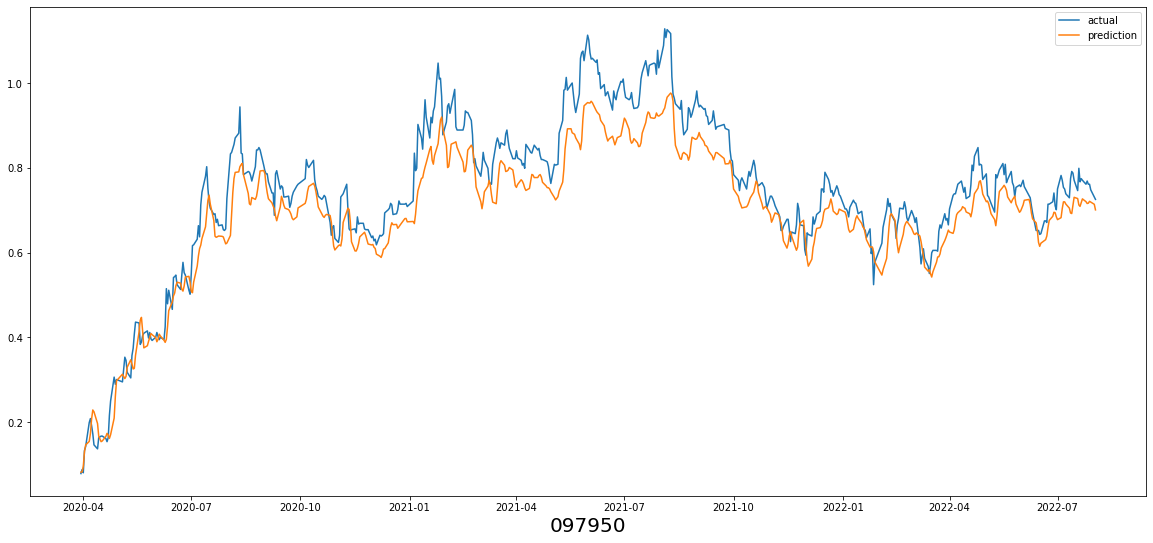

271560의 test_data의 출력 크기 :  (230, 1)


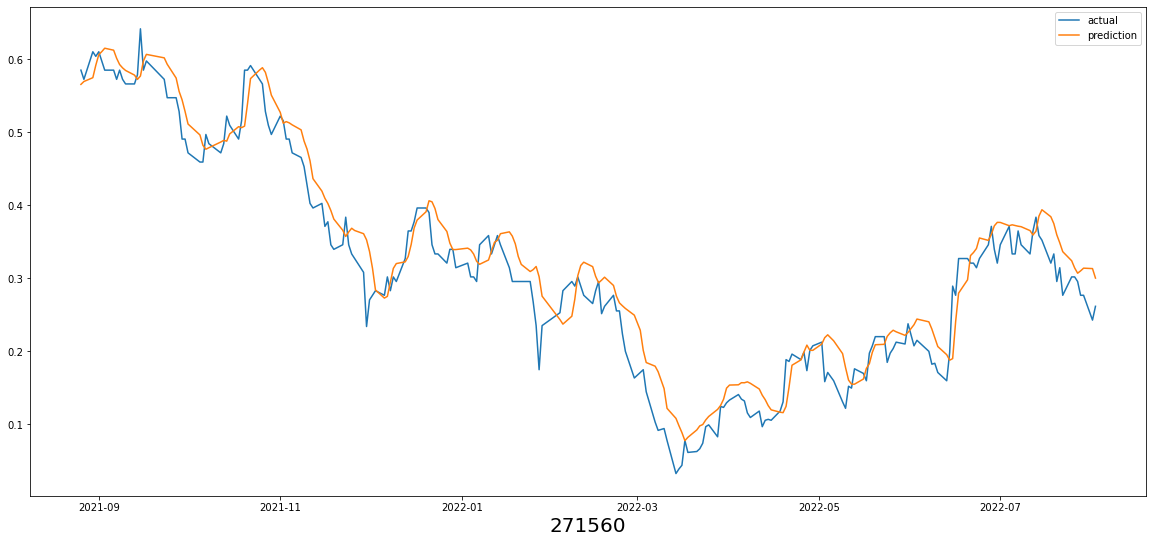

000080의 test_data의 출력 크기 :  (580, 1)


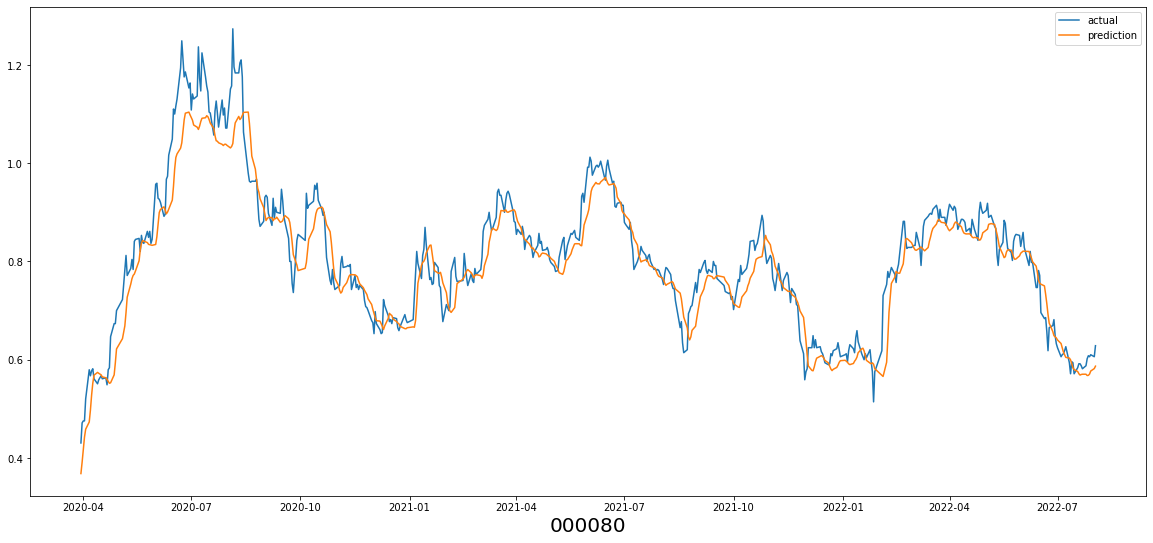

004370의 test_data의 출력 크기 :  (580, 1)


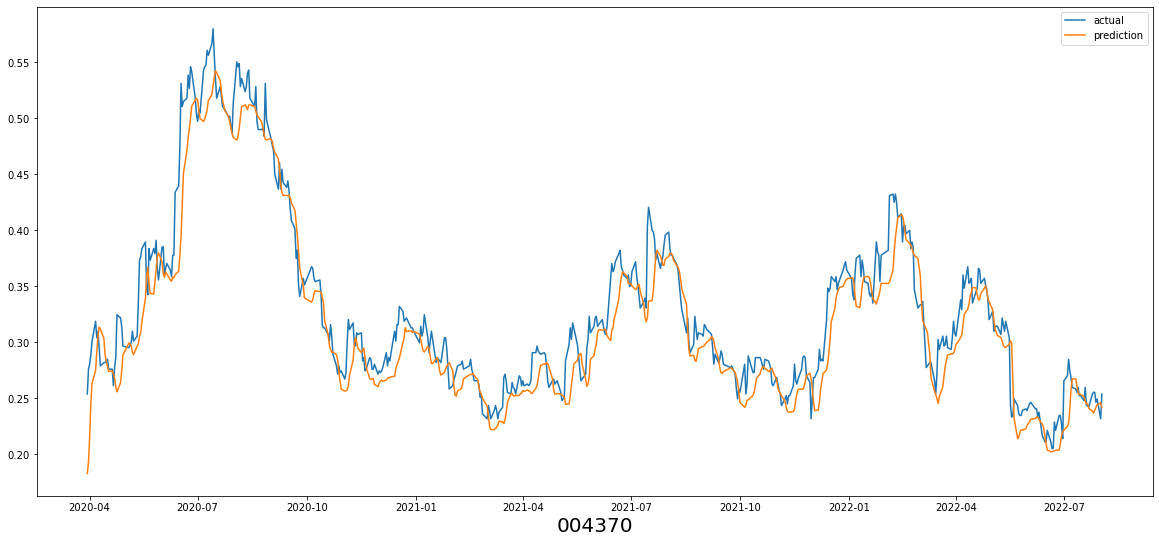

005300의 test_data의 출력 크기 :  (580, 1)


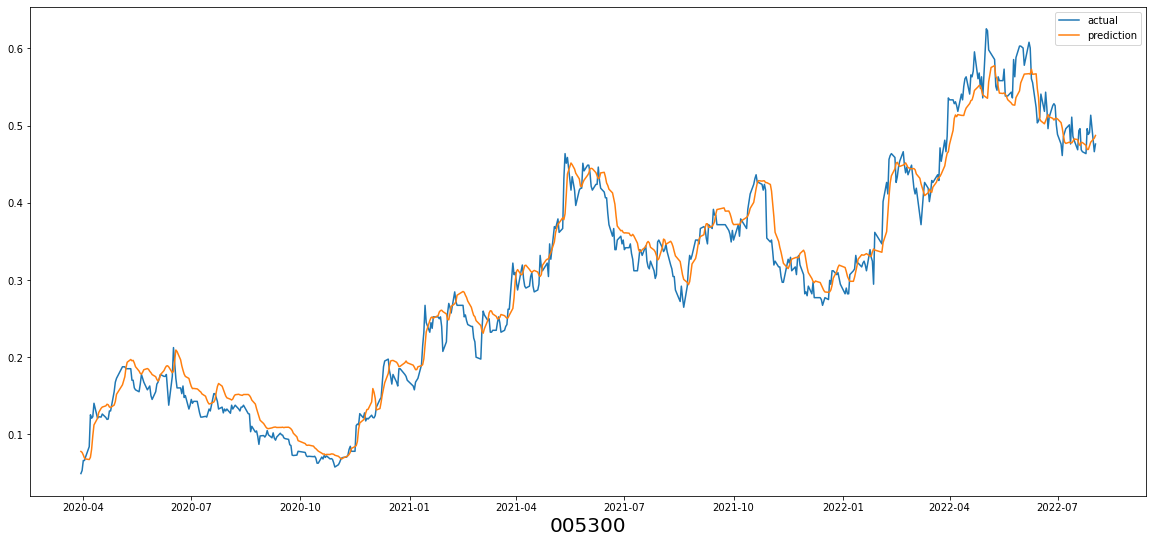

---------------Clothing---------------
093050의 test_data의 출력 크기 :  (580, 1)


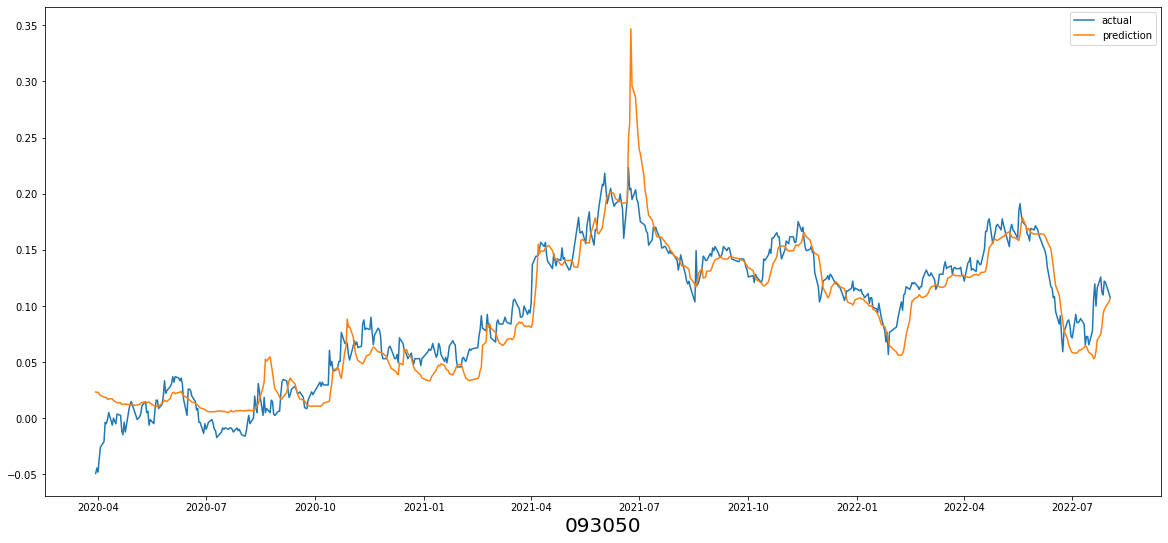

020000의 test_data의 출력 크기 :  (580, 1)


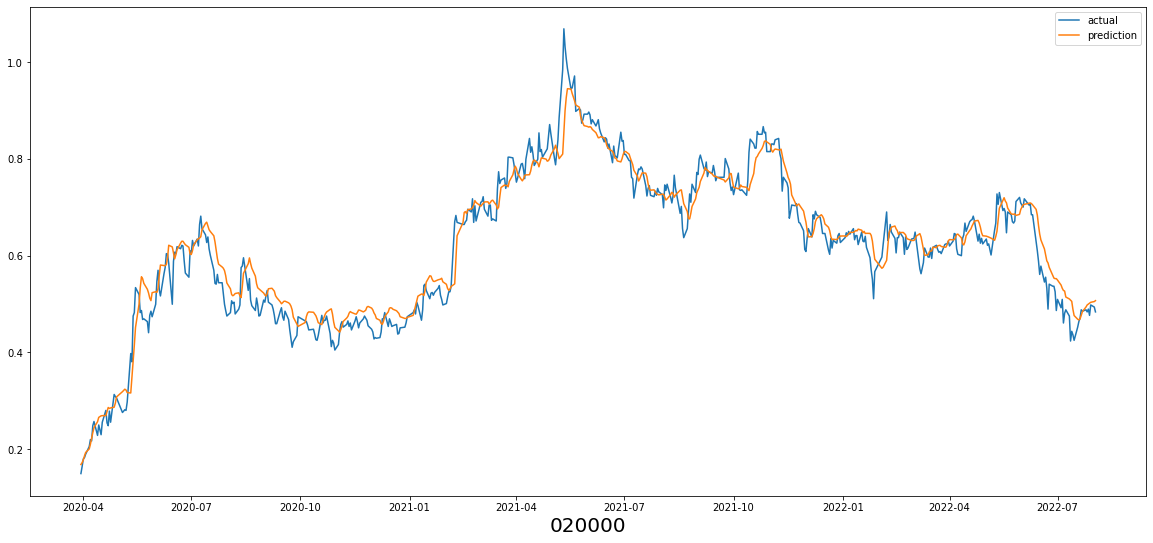

105630의 test_data의 출력 크기 :  (580, 1)


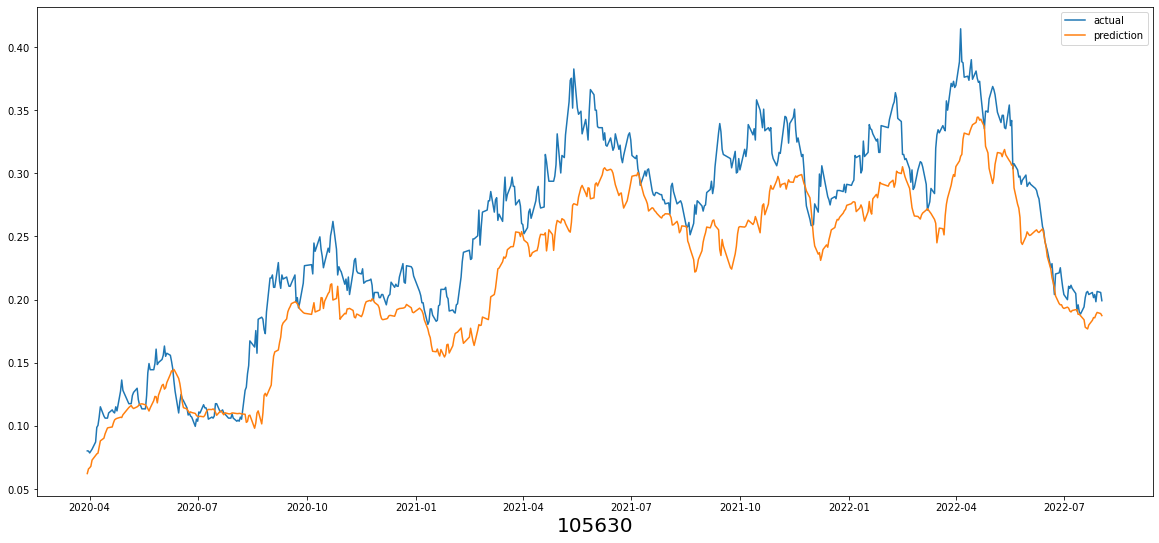

001070의 test_data의 출력 크기 :  (580, 1)


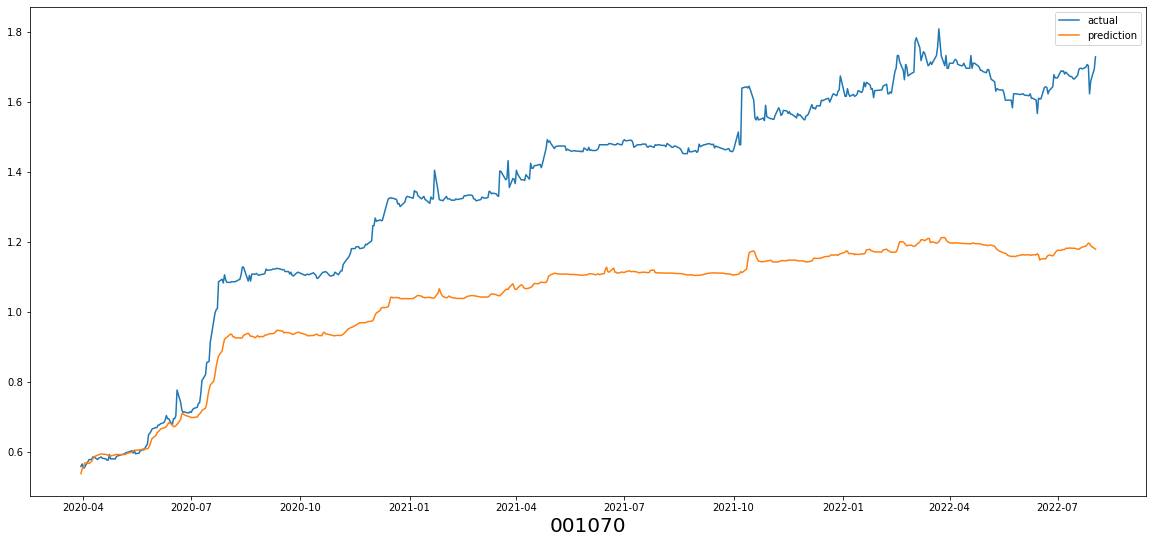

---------------Chemical---------------
051910의 test_data의 출력 크기 :  (580, 1)


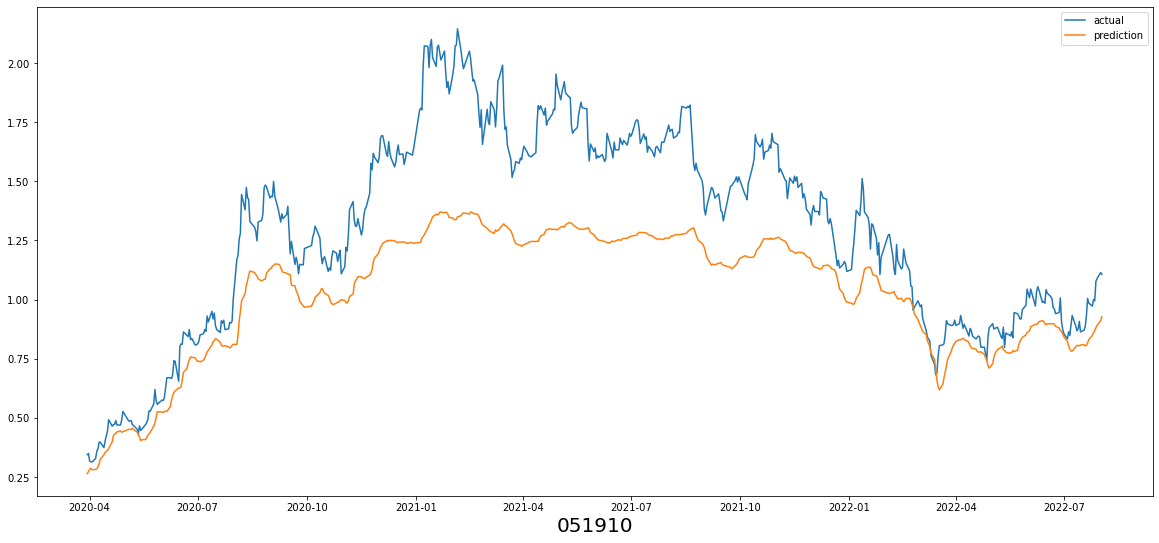

096770의 test_data의 출력 크기 :  (580, 1)


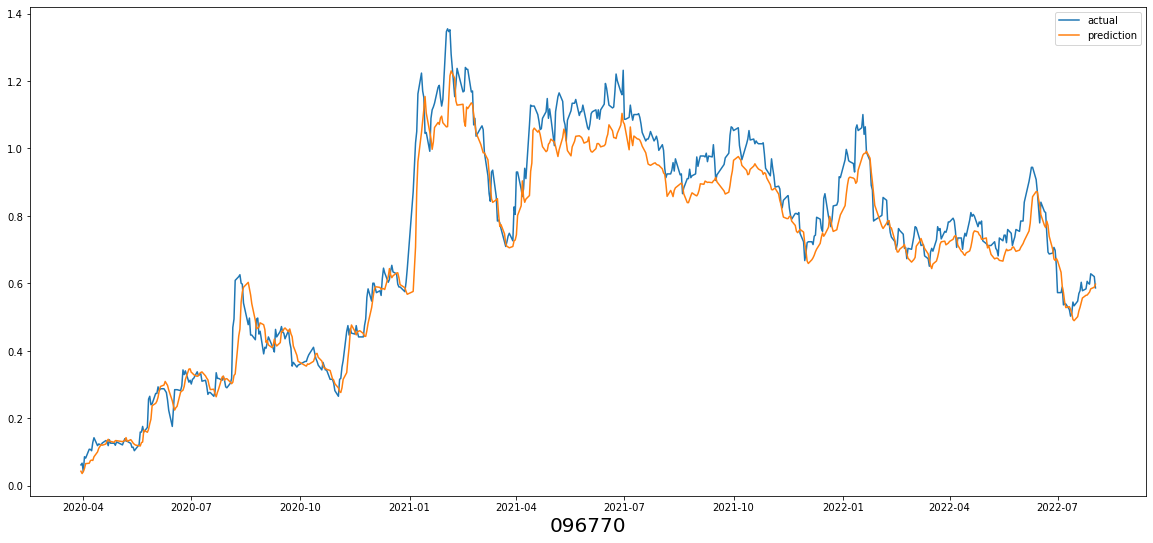

010950의 test_data의 출력 크기 :  (580, 1)


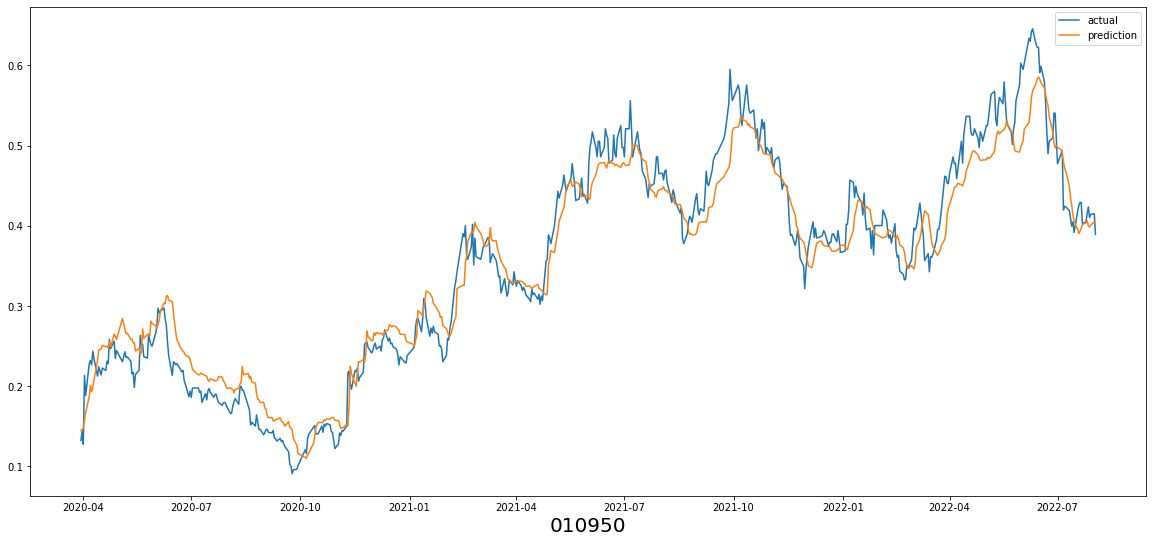

051900의 test_data의 출력 크기 :  (580, 1)


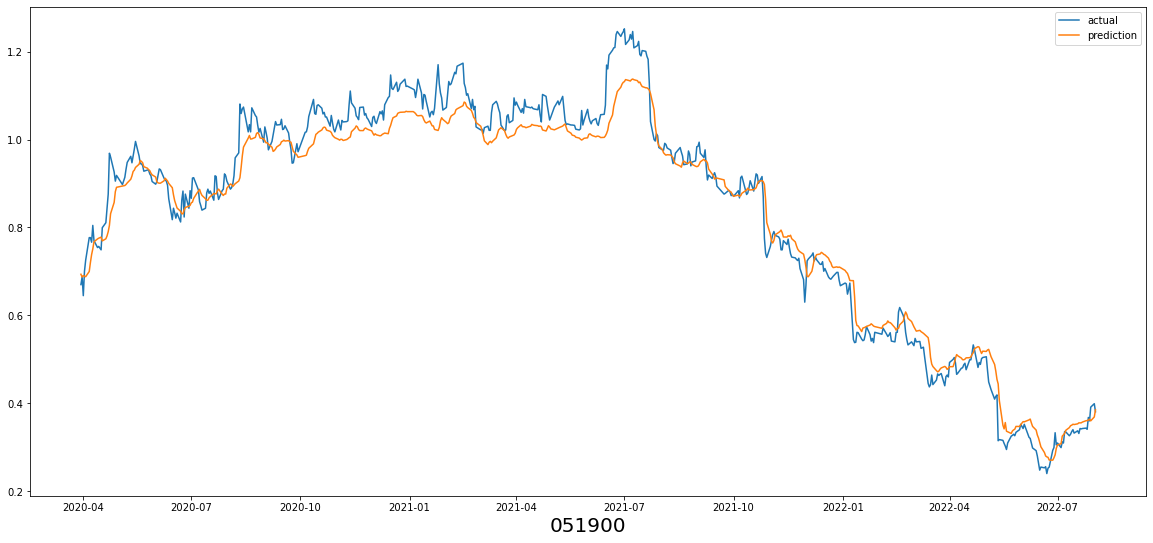

090430의 test_data의 출력 크기 :  (580, 1)


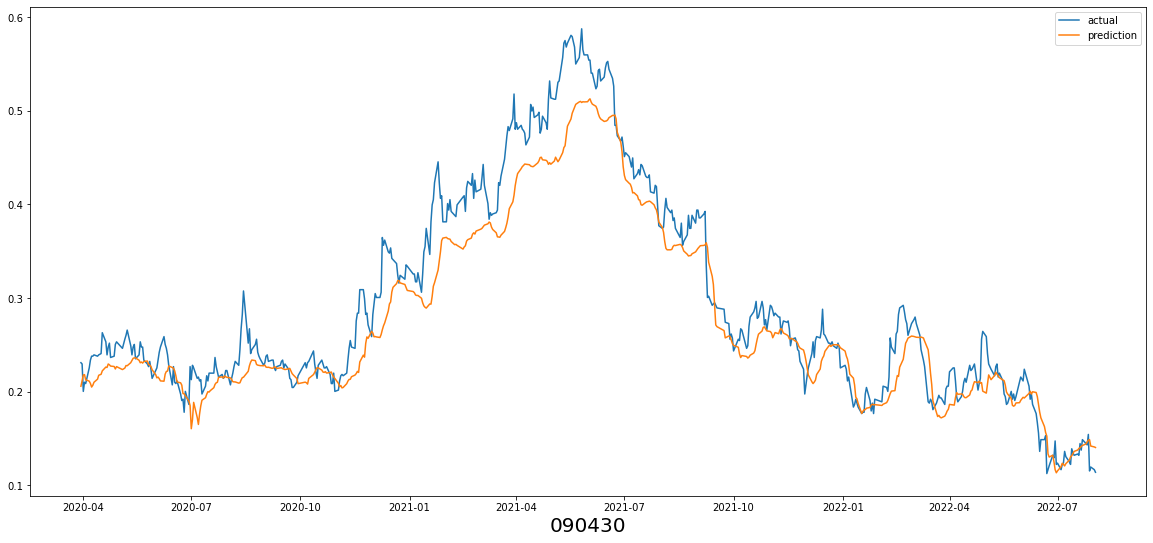

---------------Medicine---------------
207940의 test_data의 출력 크기 :  (262, 1)


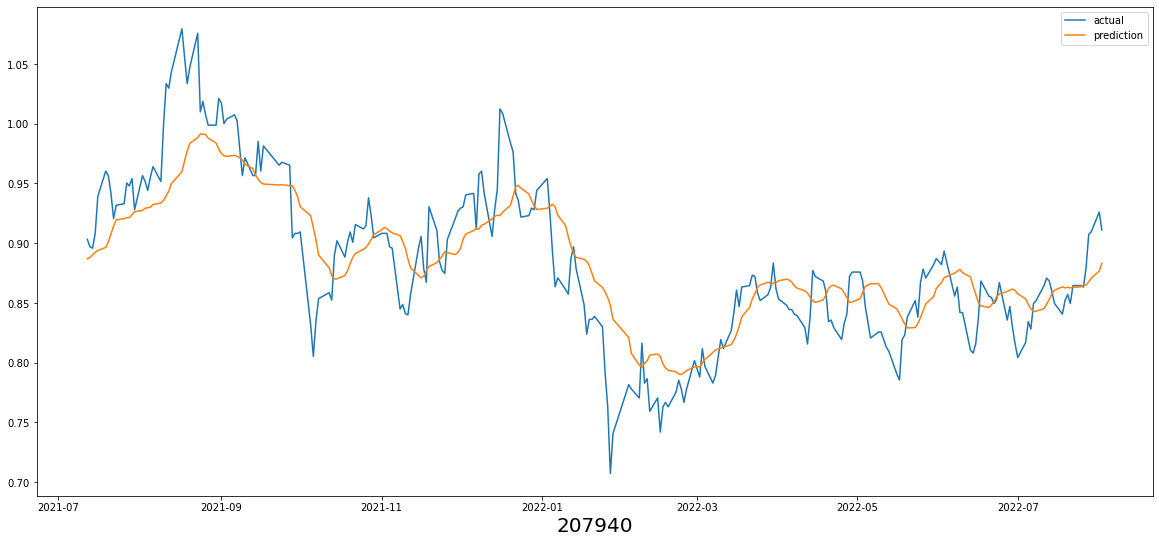

068270의 test_data의 출력 크기 :  (580, 1)


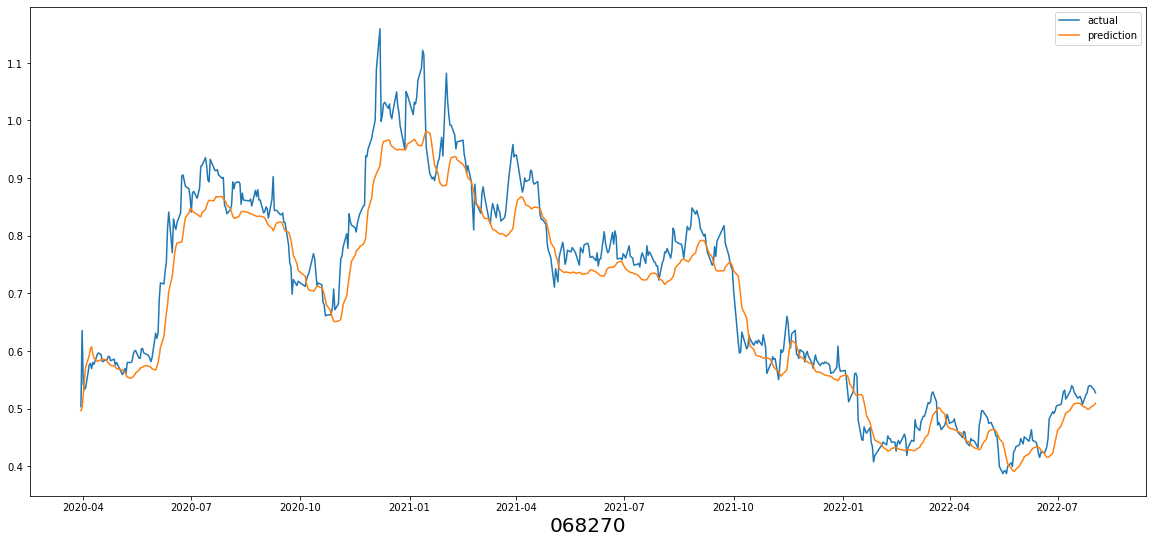

000100의 test_data의 출력 크기 :  (580, 1)


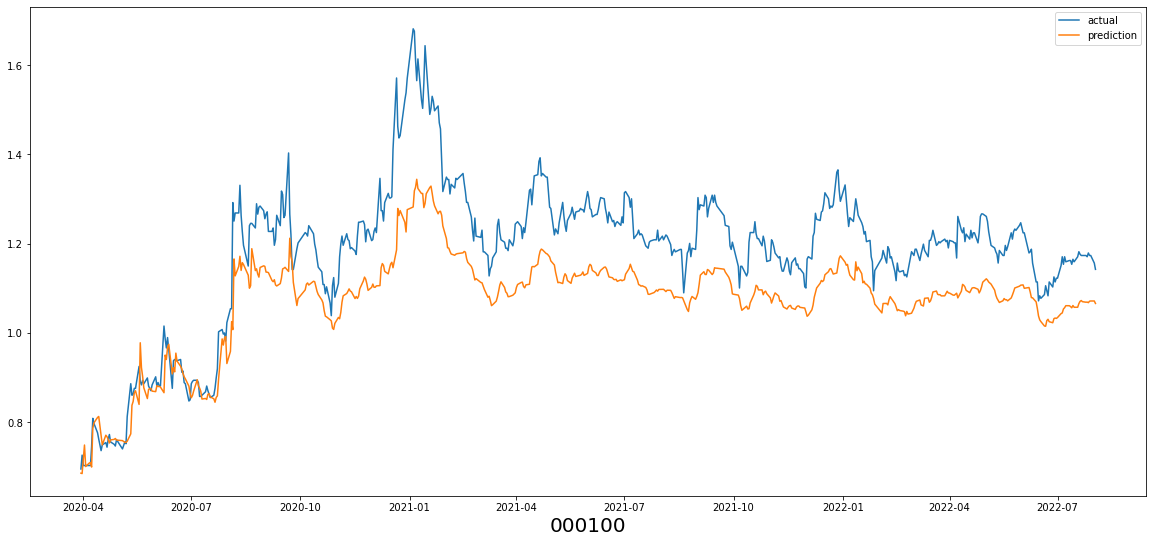

128940의 test_data의 출력 크기 :  (573, 1)


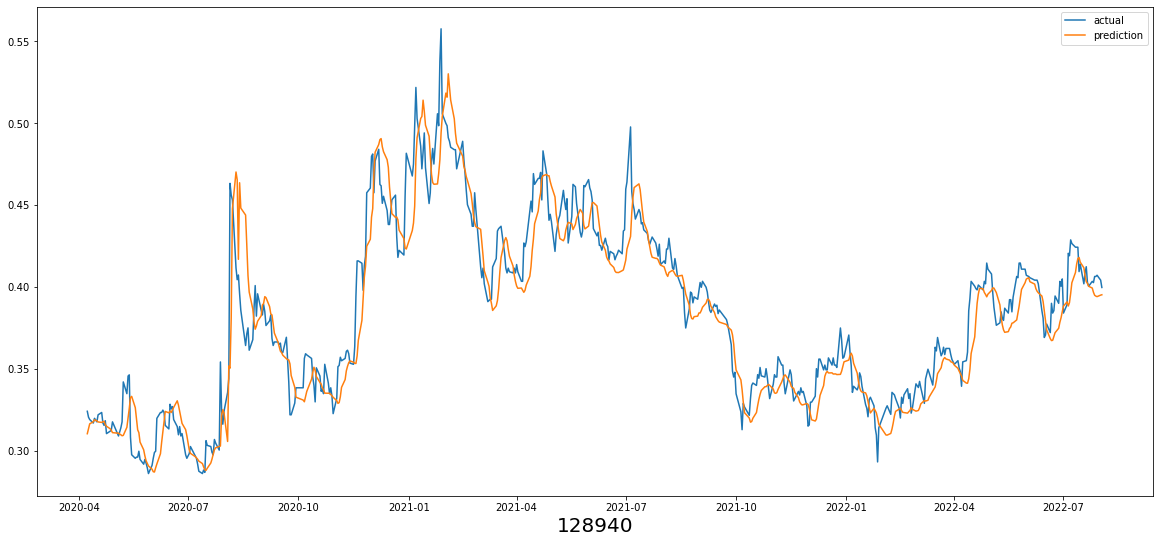

---------------Non_Metal---------------
003670의 test_data의 출력 크기 :  (580, 1)


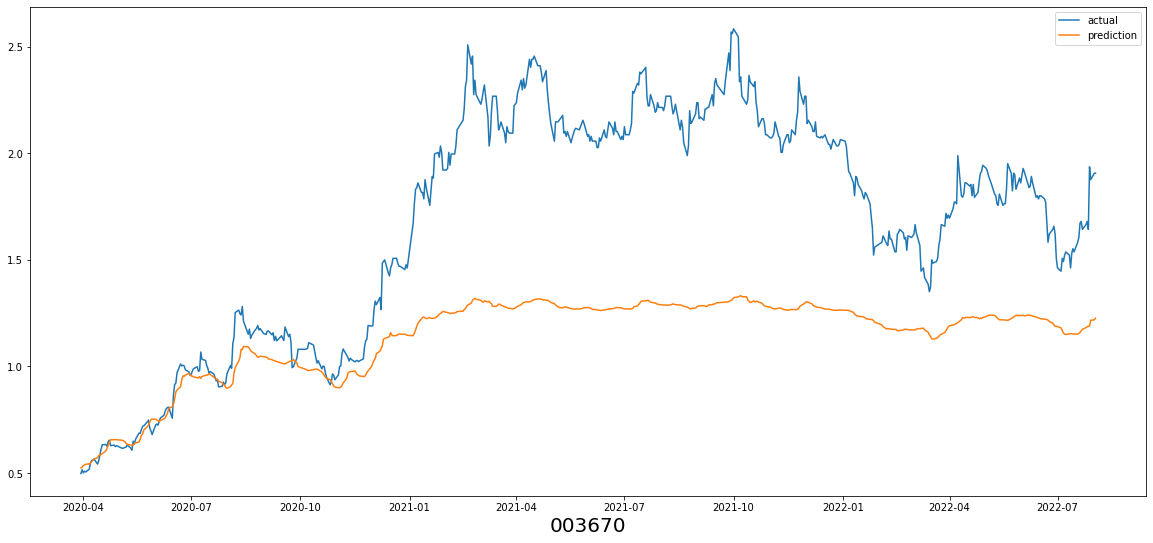

003410의 test_data의 출력 크기 :  (580, 1)


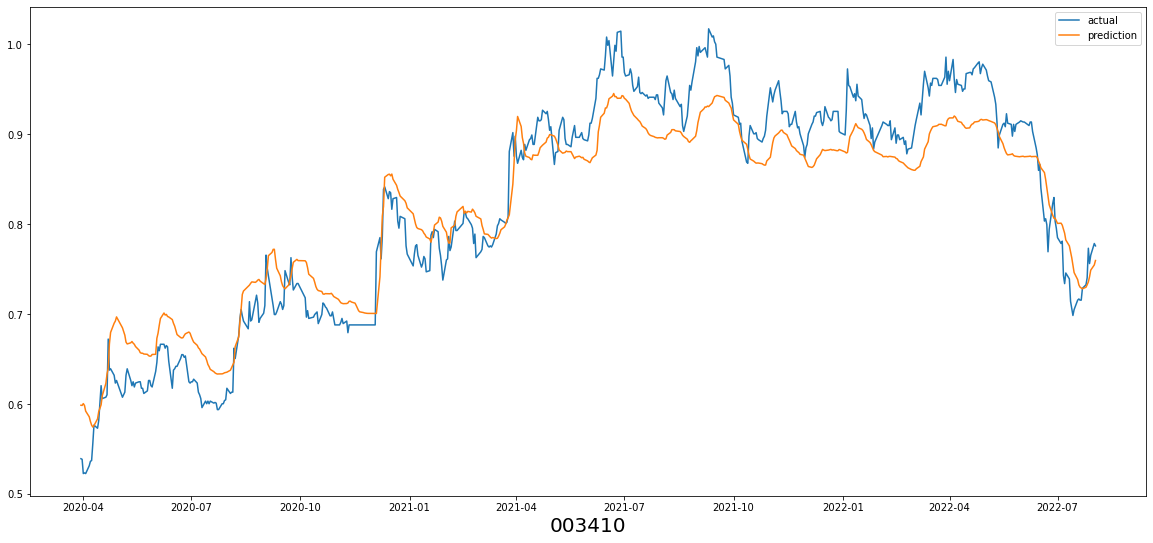

010780의 test_data의 출력 크기 :  (580, 1)


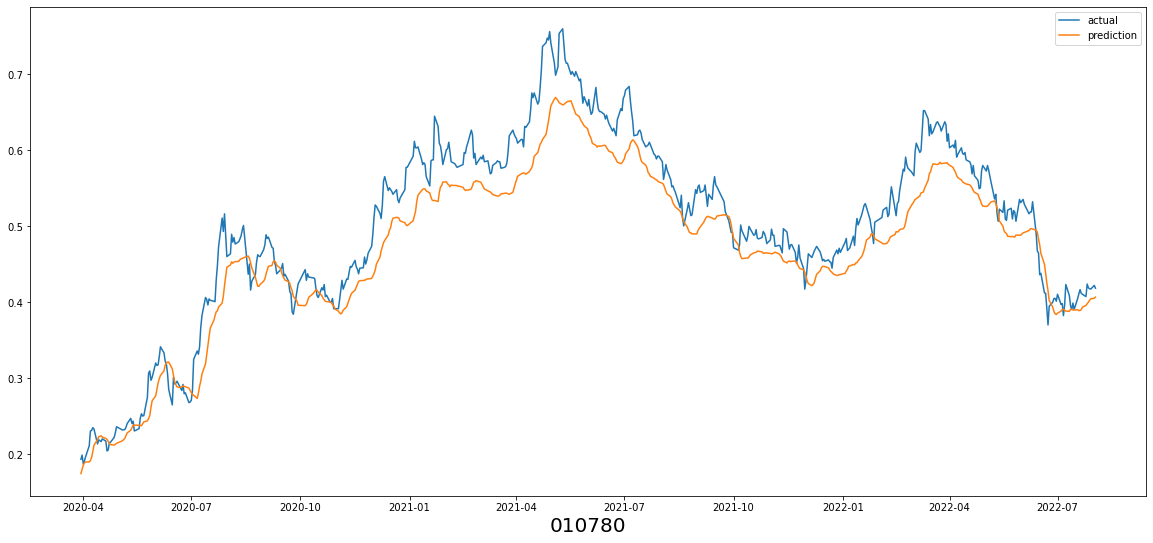

---------------Metal---------------
005490의 test_data의 출력 크기 :  (580, 1)


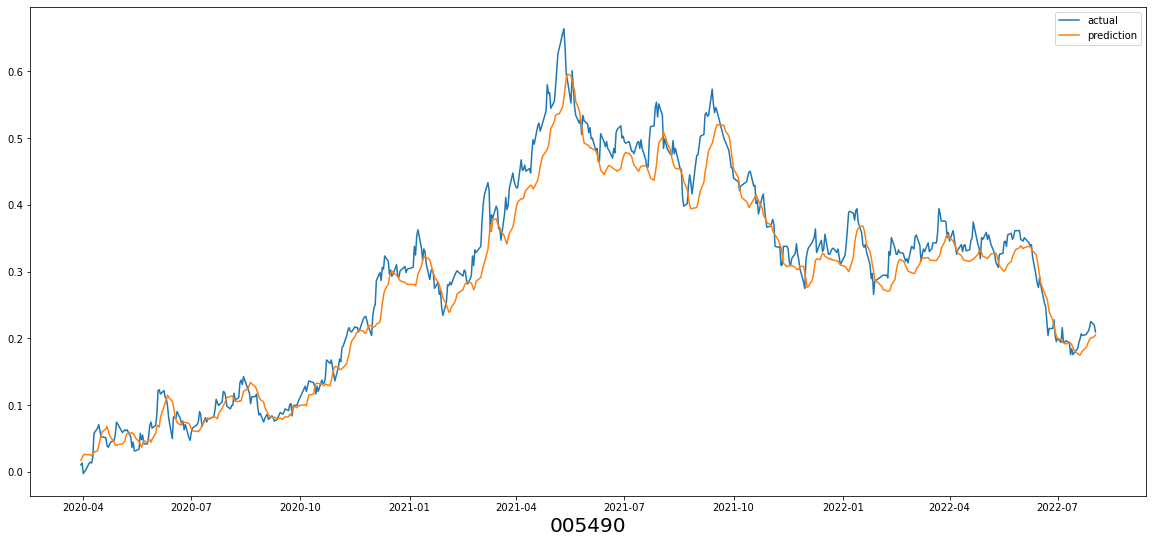

010130의 test_data의 출력 크기 :  (580, 1)


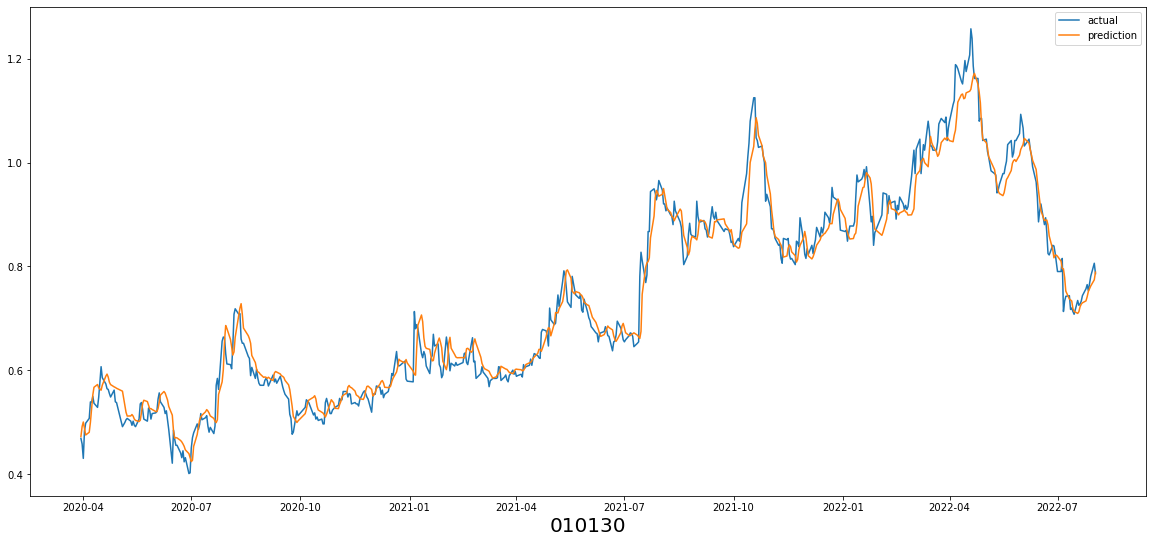

004020의 test_data의 출력 크기 :  (580, 1)


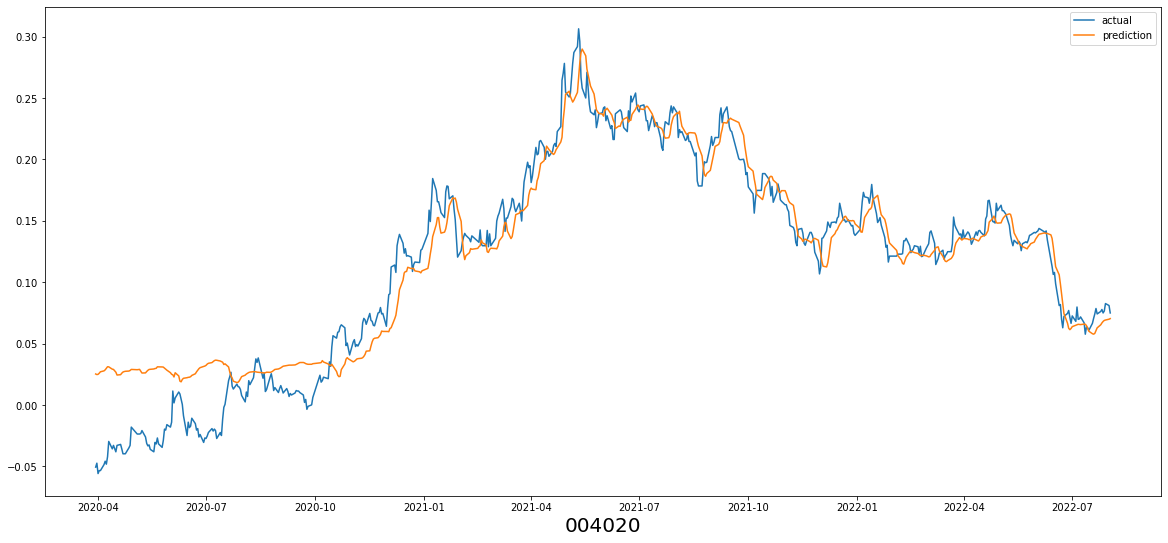

016380의 test_data의 출력 크기 :  (580, 1)


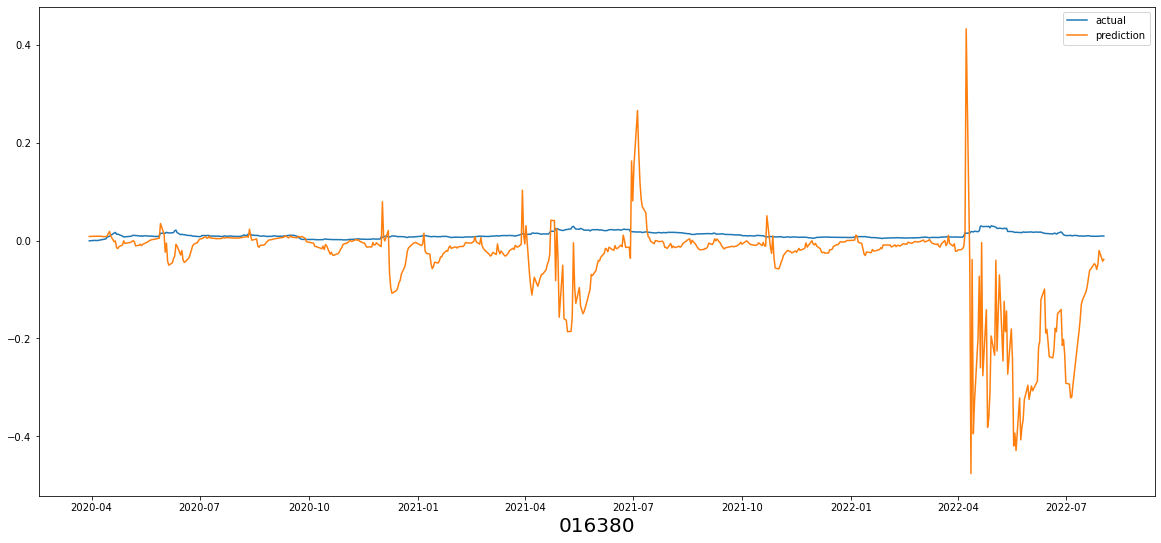

001230의 test_data의 출력 크기 :  (580, 1)


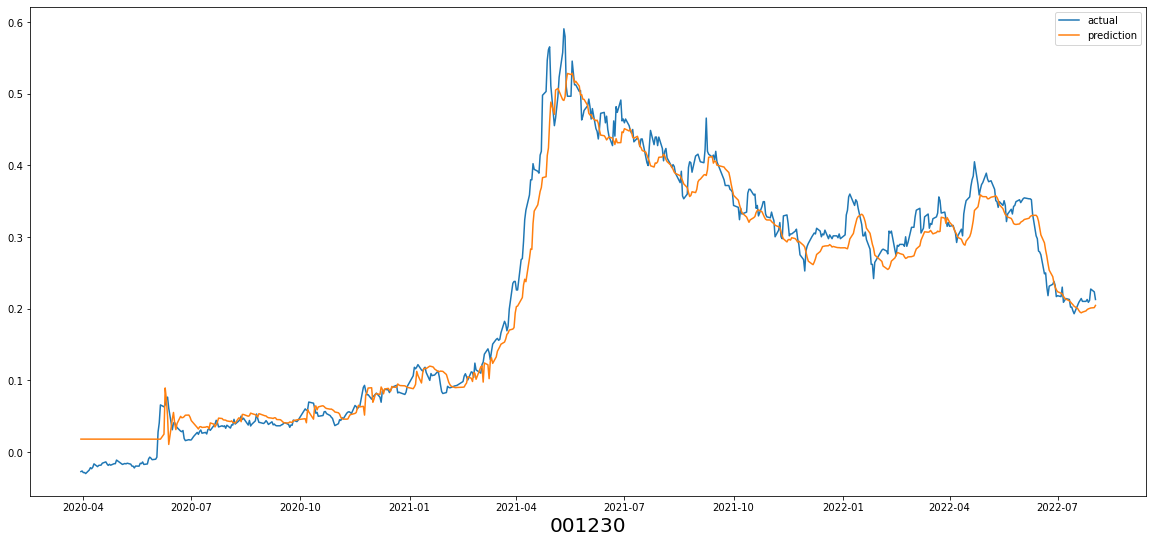

---------------Machine---------------
034020의 test_data의 출력 크기 :  (580, 1)


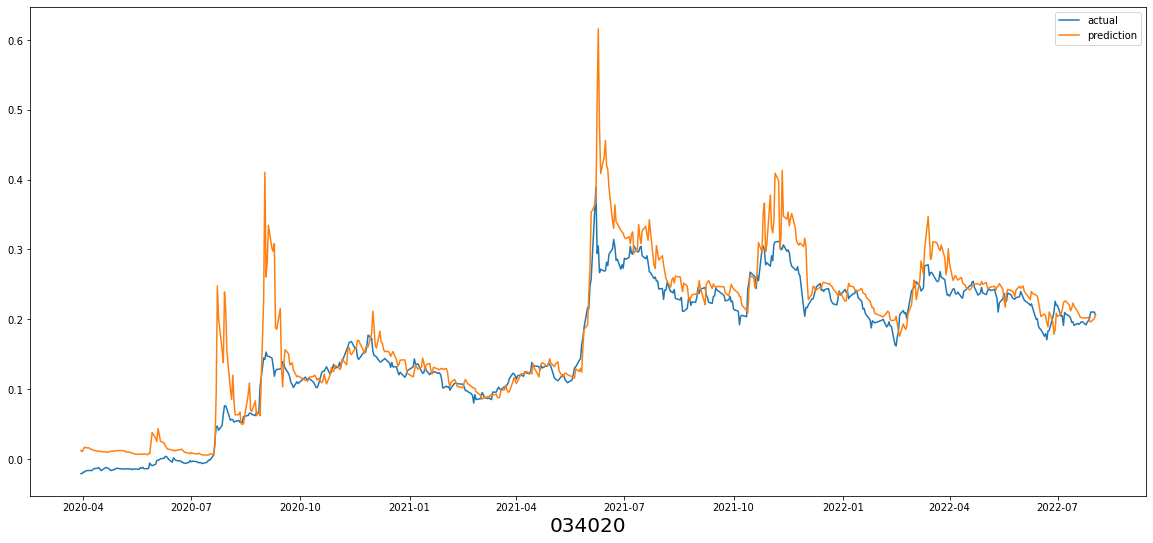

018880의 test_data의 출력 크기 :  (580, 1)


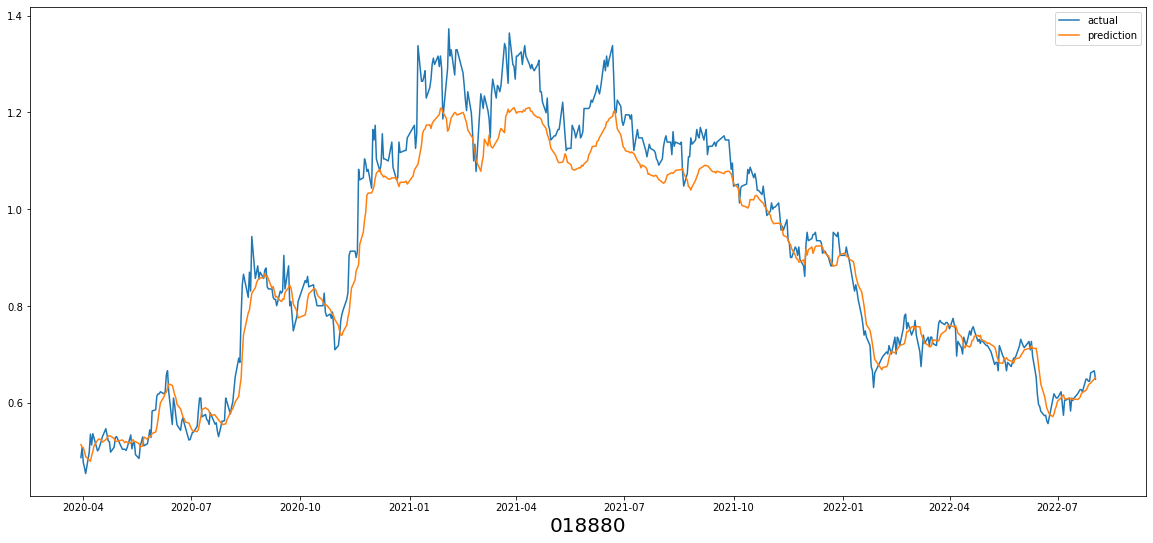

241560의 test_data의 출력 크기 :  (261, 1)


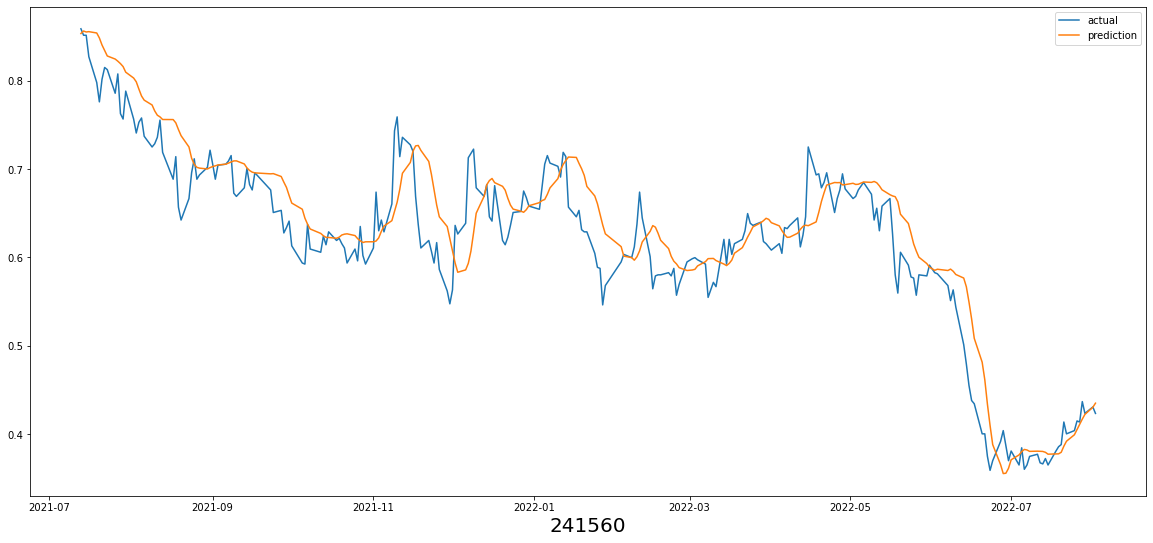

112610의 test_data의 출력 크기 :  (358, 1)


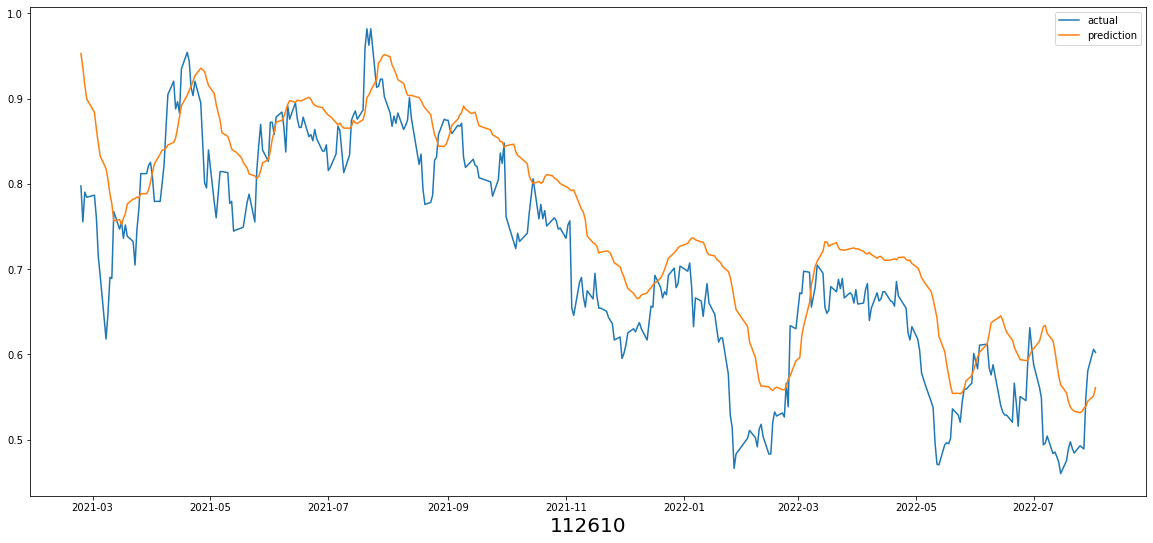

---------------Electronic---------------
005930의 test_data의 출력 크기 :  (580, 1)


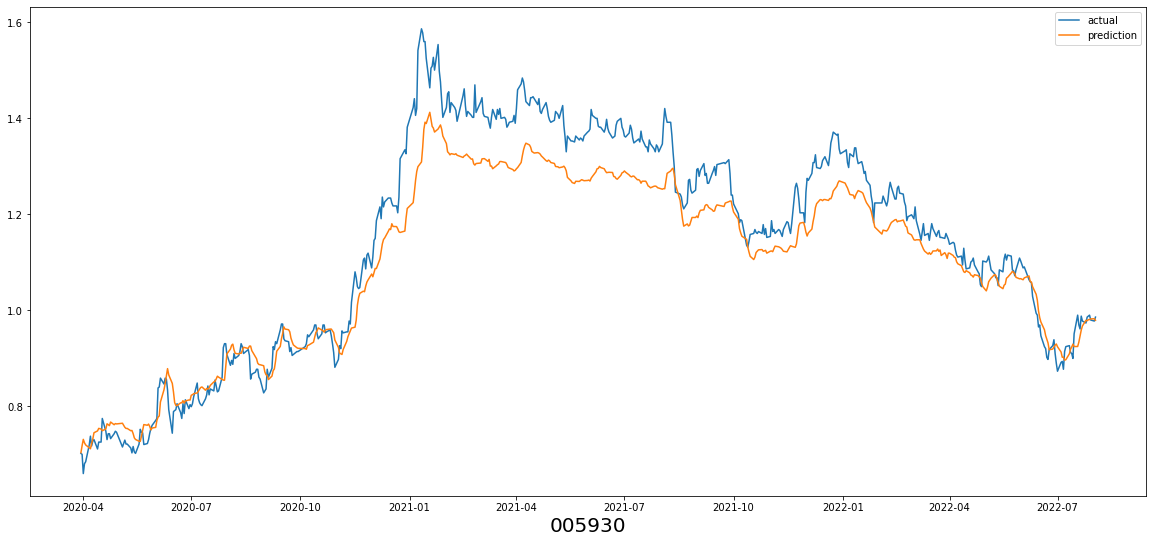

000660의 test_data의 출력 크기 :  (580, 1)


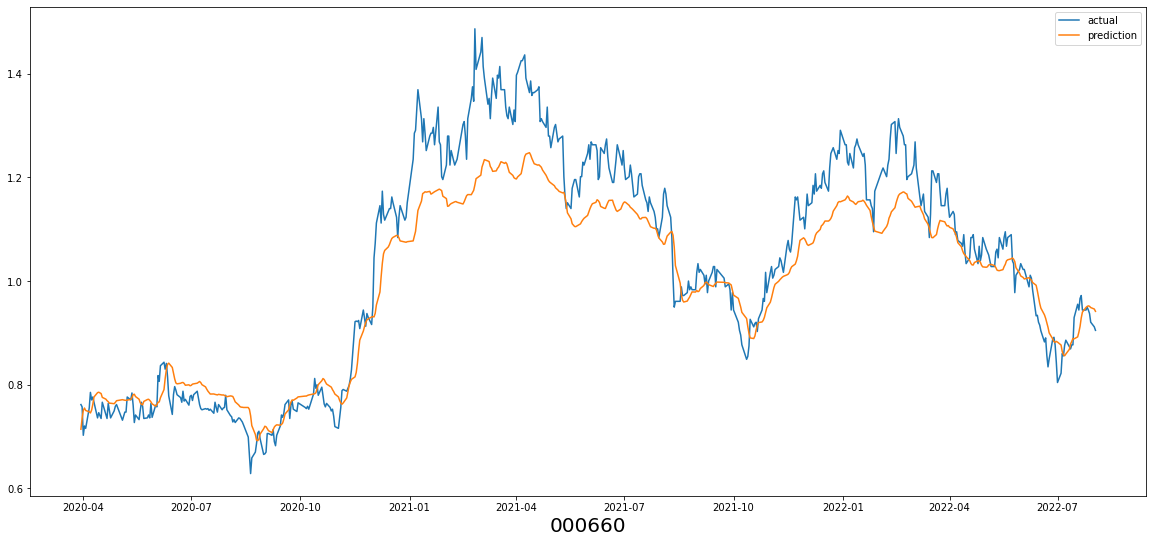

006400의 test_data의 출력 크기 :  (580, 1)


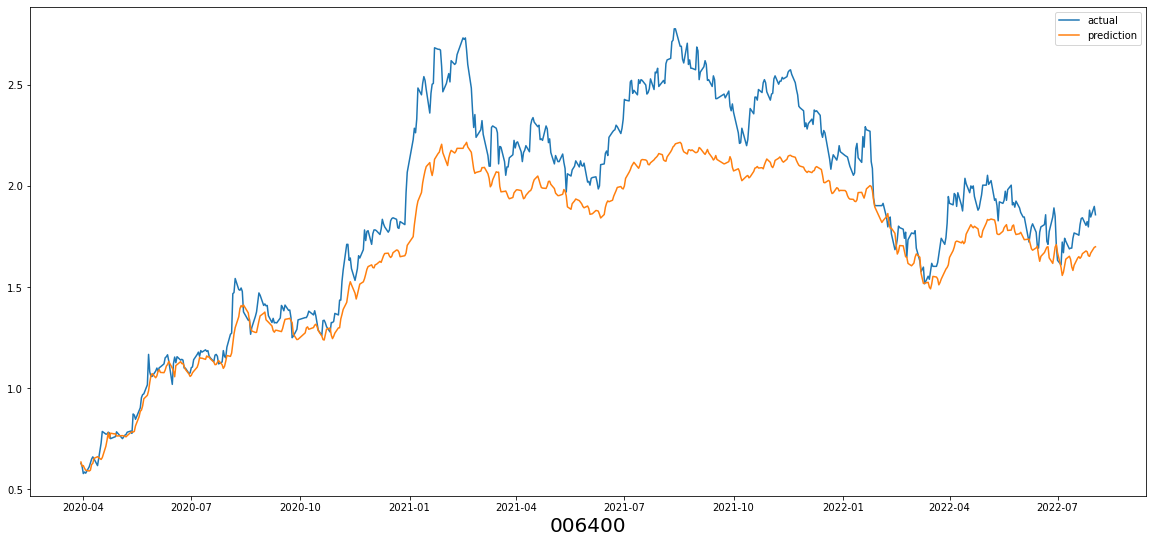

066570의 test_data의 출력 크기 :  (580, 1)


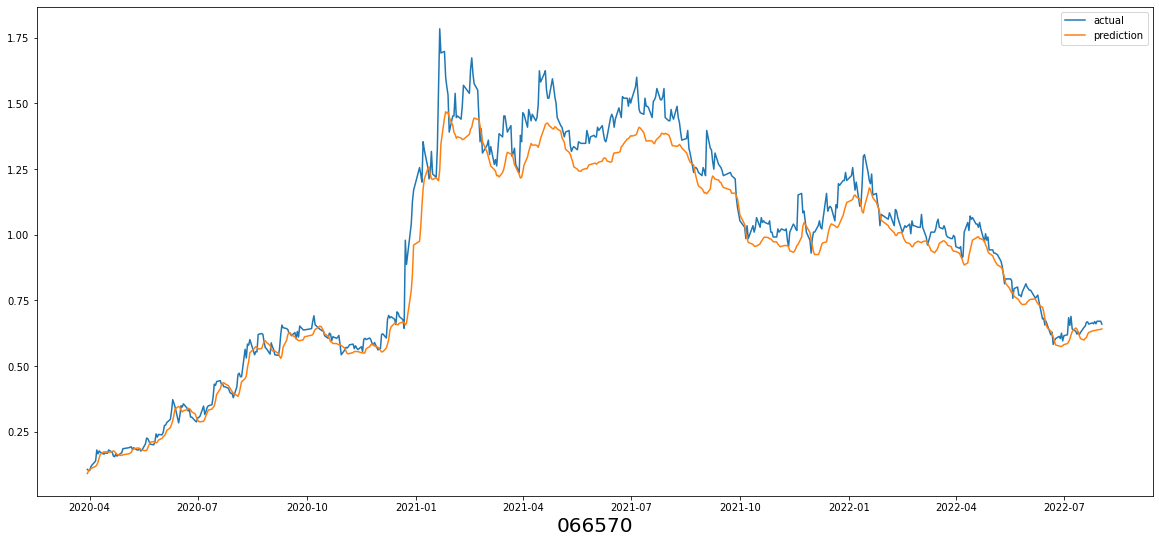

---------------Construction---------------
000720의 test_data의 출력 크기 :  (580, 1)


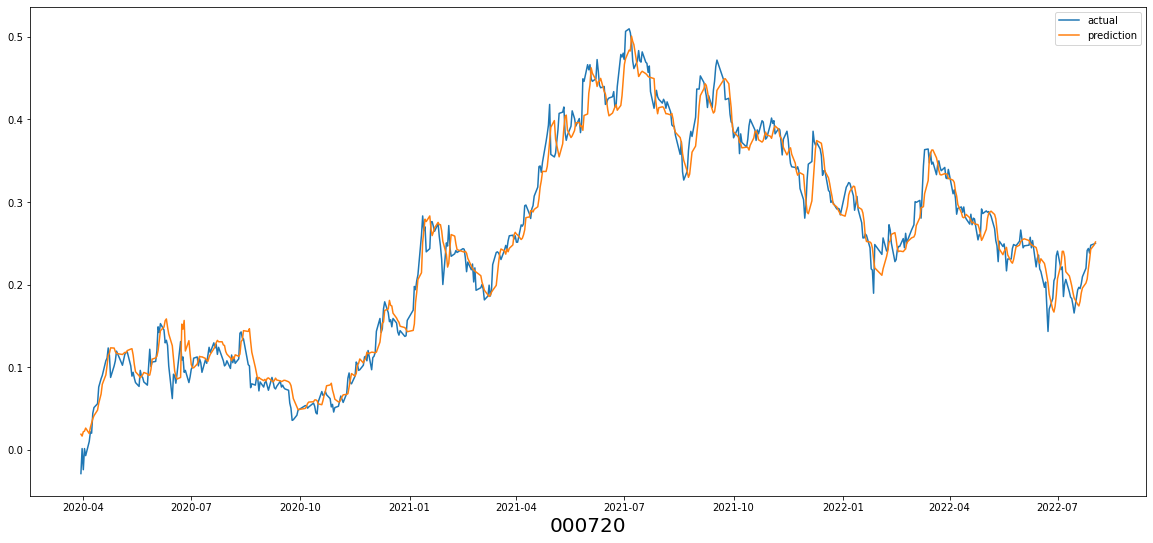

006360의 test_data의 출력 크기 :  (580, 1)


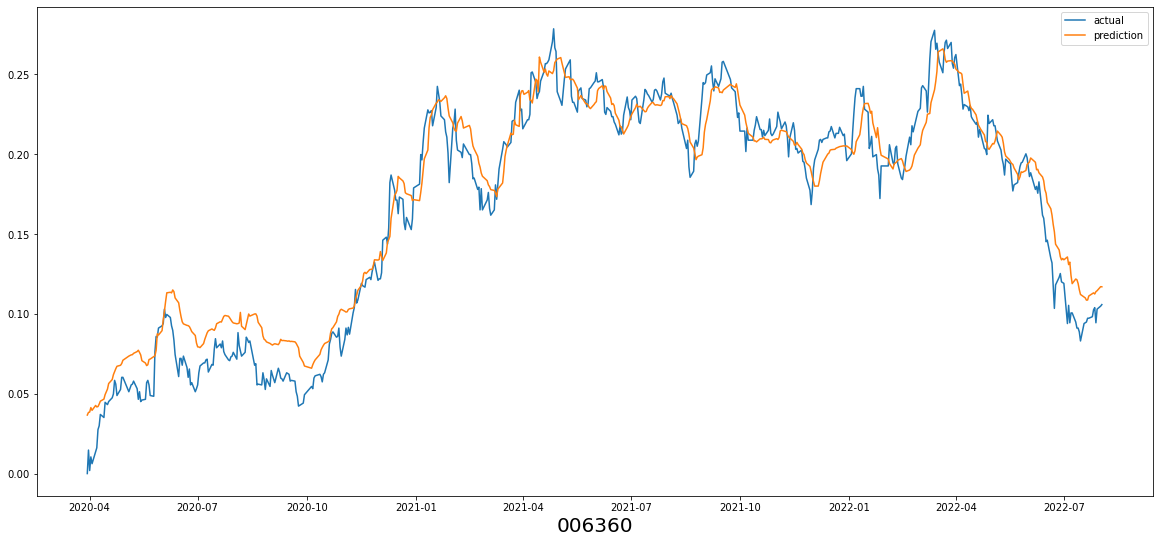

047040의 test_data의 출력 크기 :  (580, 1)


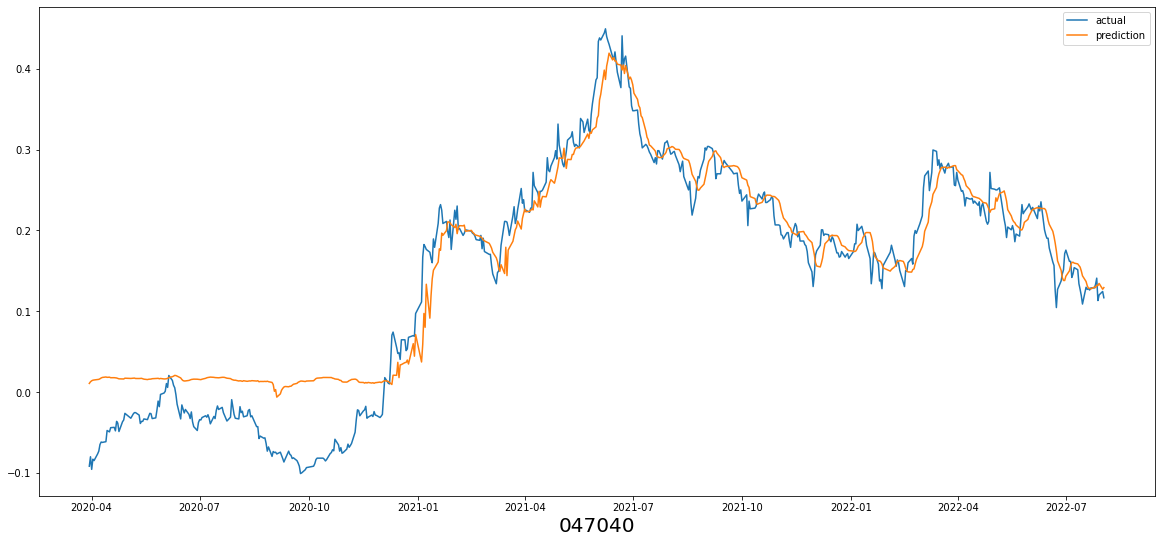

051600의 test_data의 출력 크기 :  (580, 1)


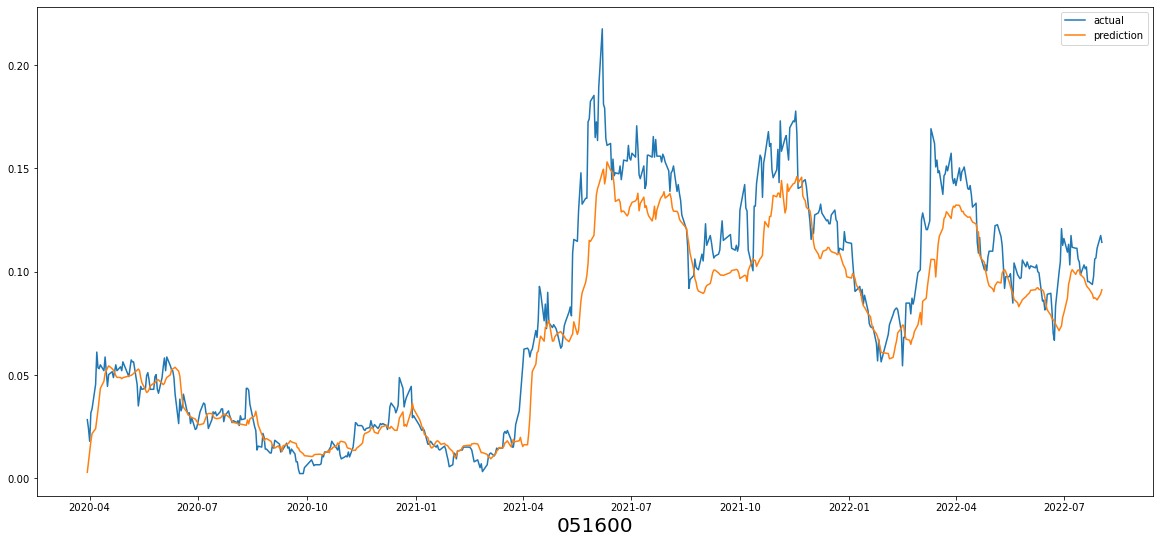

---------------Transport---------------
011200의 test_data의 출력 크기 :  (580, 1)


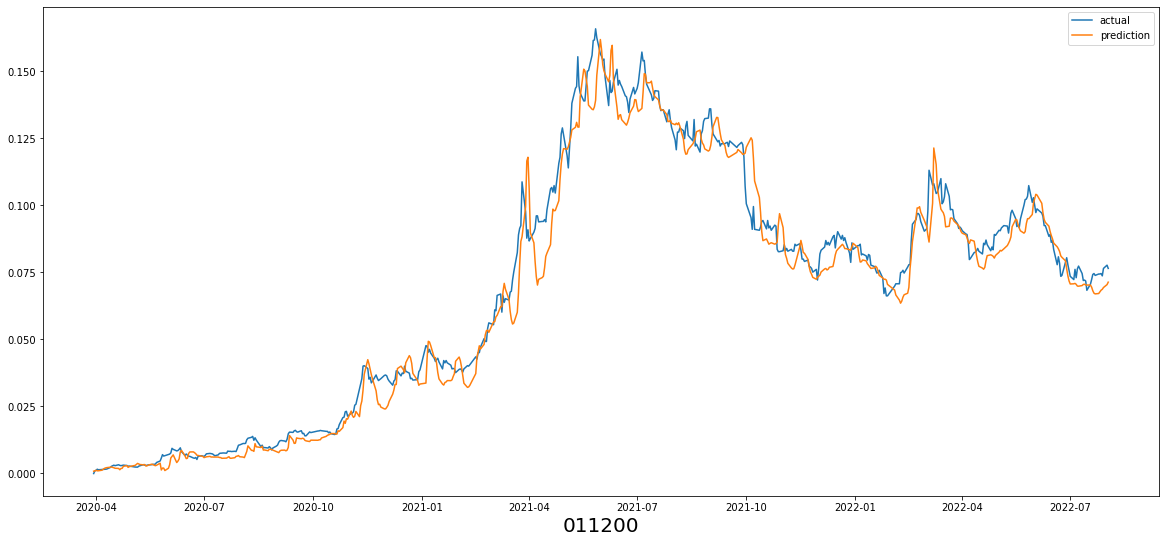

003490의 test_data의 출력 크기 :  (580, 1)


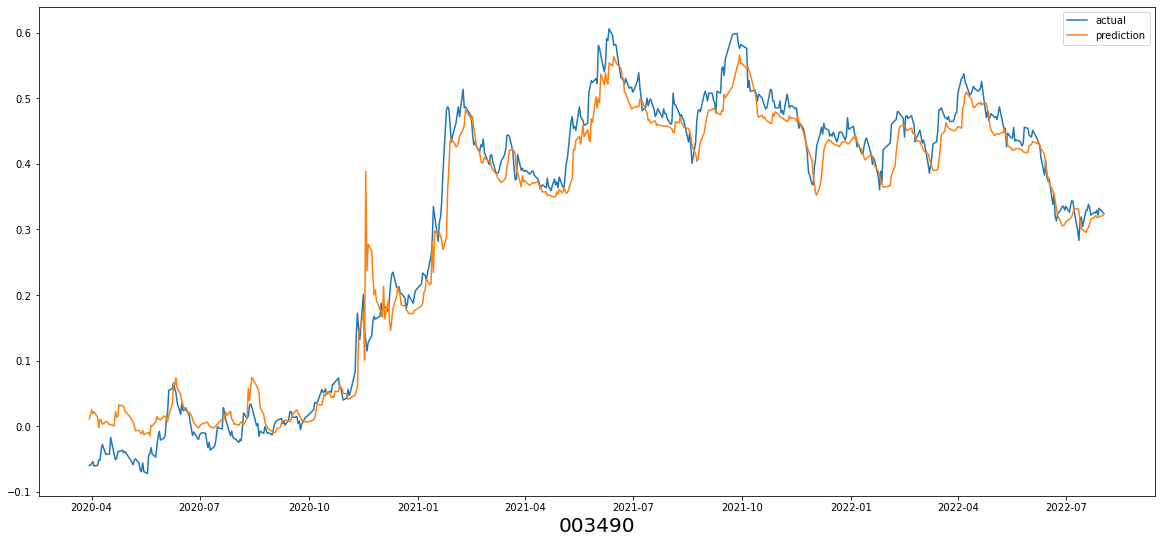

086280의 test_data의 출력 크기 :  (580, 1)


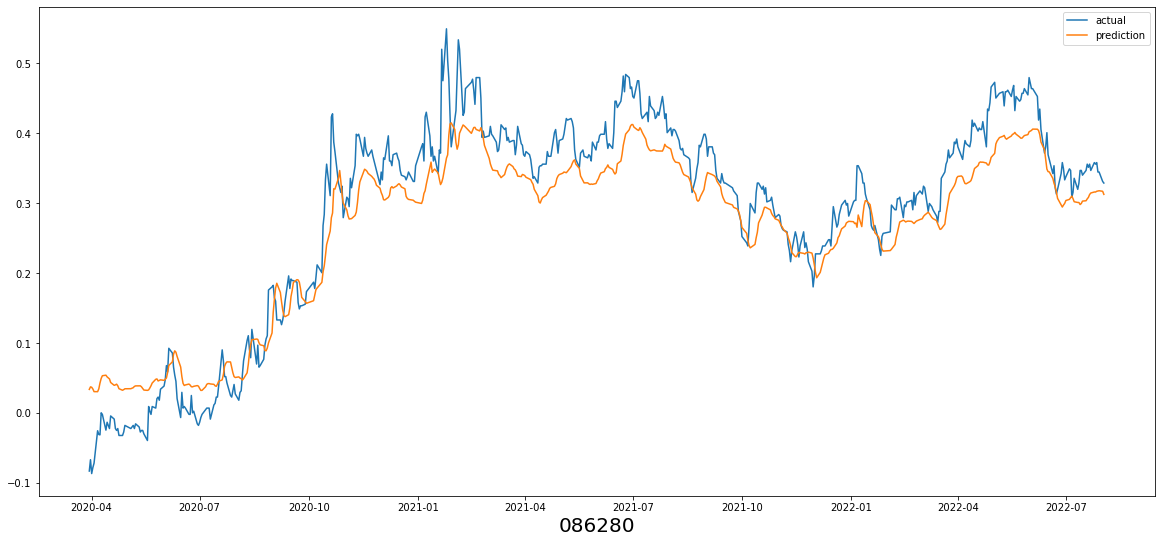

180640의 test_data의 출력 크기 :  (417, 1)


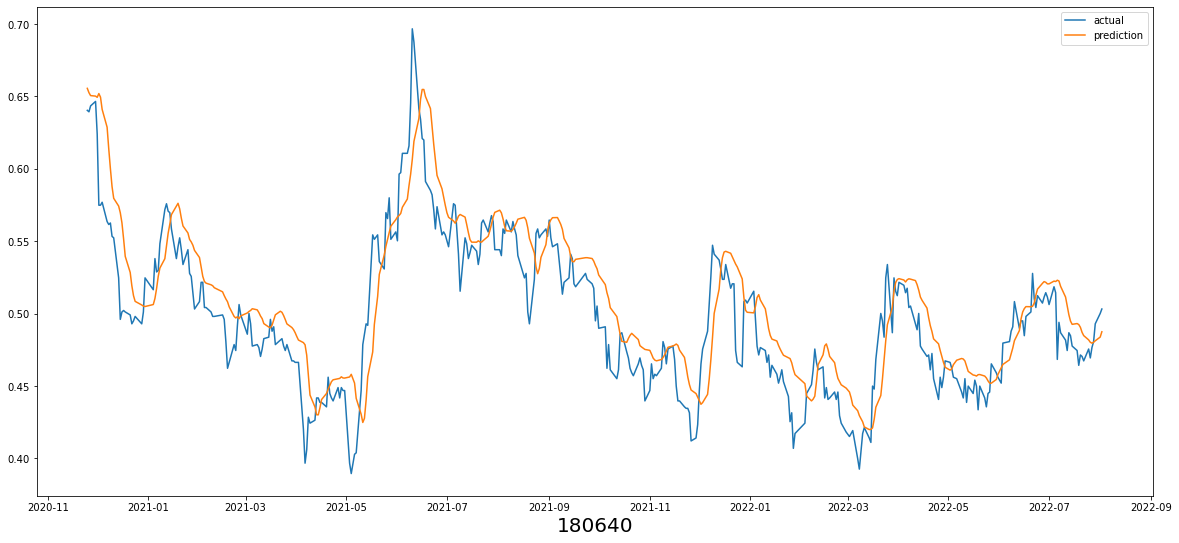

028670의 test_data의 출력 크기 :  (580, 1)


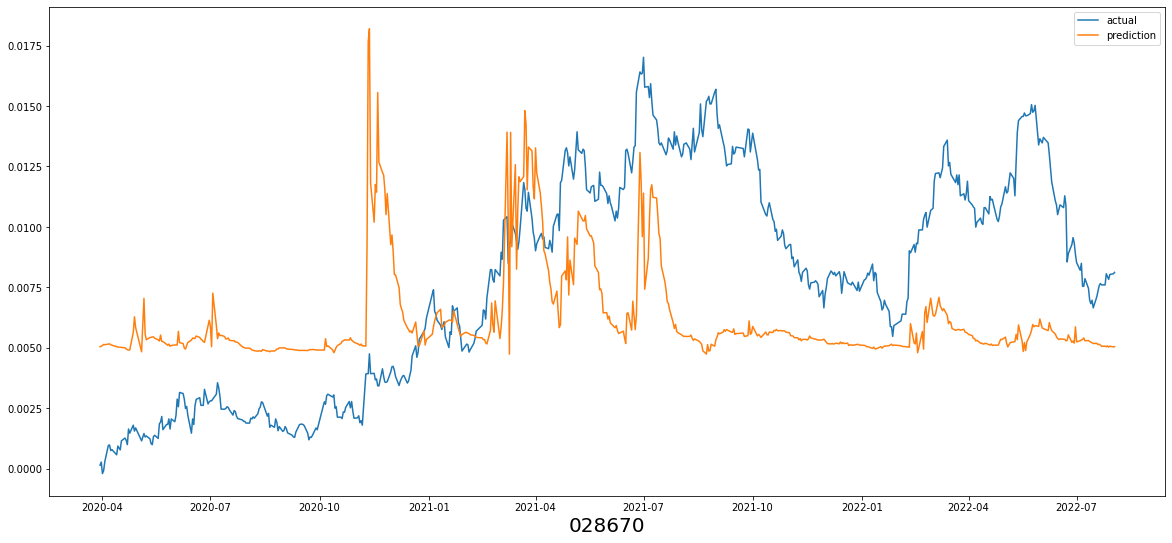

---------------Distribution---------------
028260의 test_data의 출력 크기 :  (355, 1)


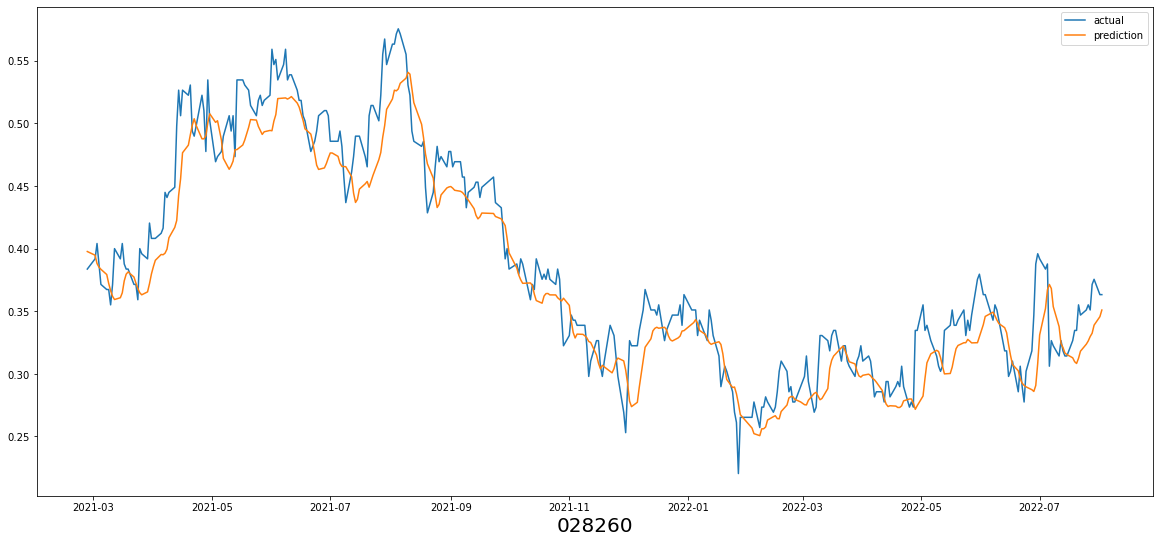

023530의 test_data의 출력 크기 :  (580, 1)


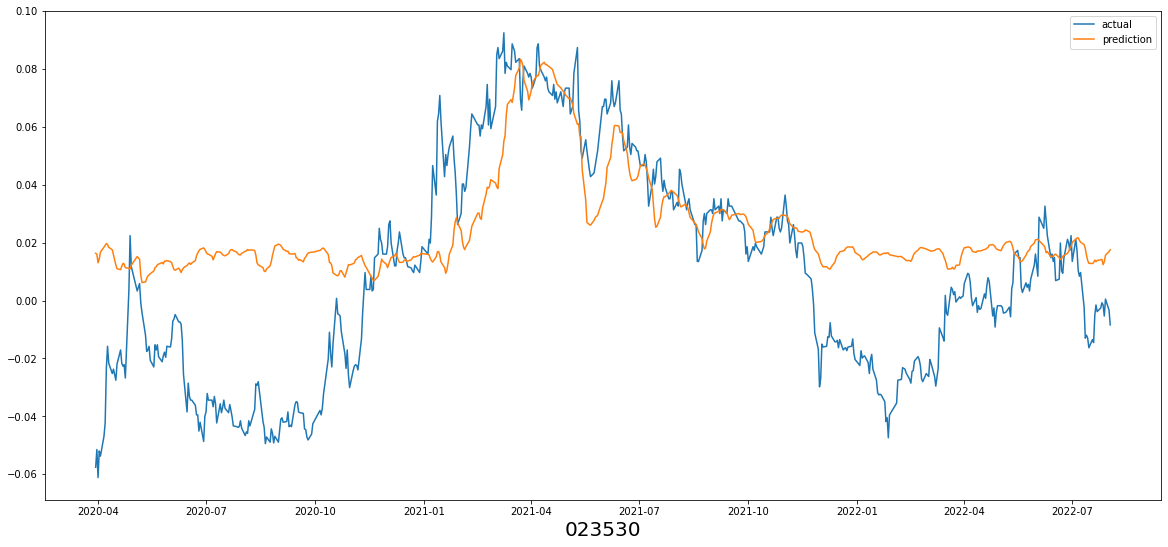

282330의 test_data의 출력 크기 :  (209, 1)


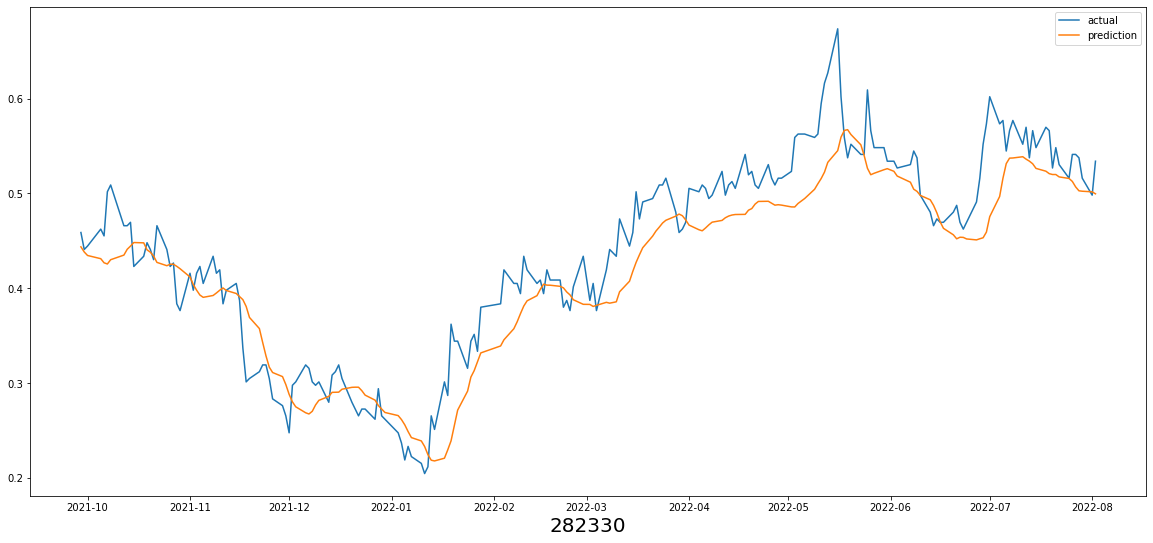

139480의 test_data의 출력 크기 :  (530, 1)


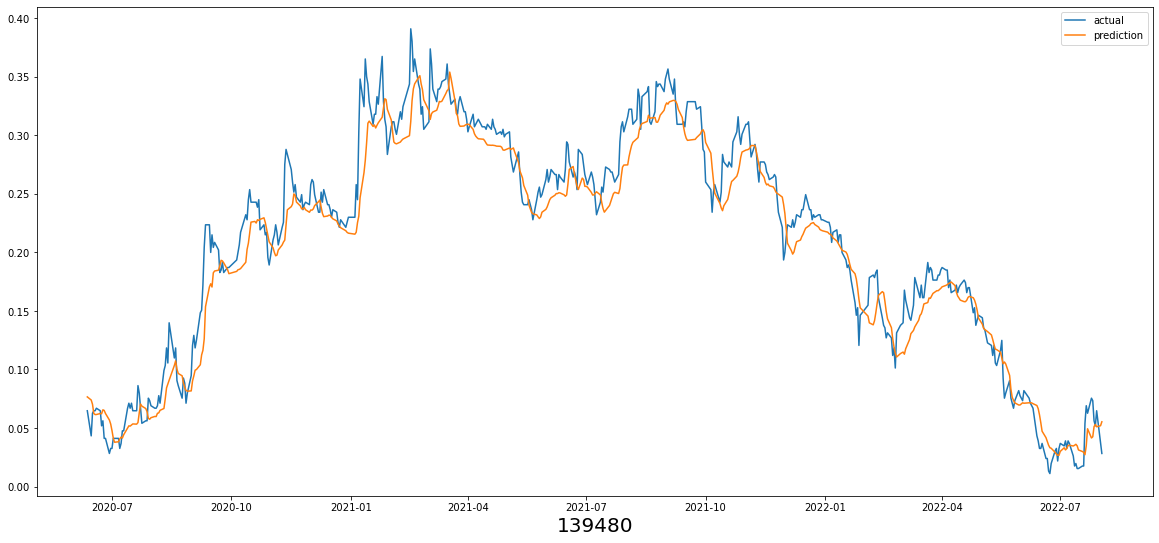

004170의 test_data의 출력 크기 :  (580, 1)


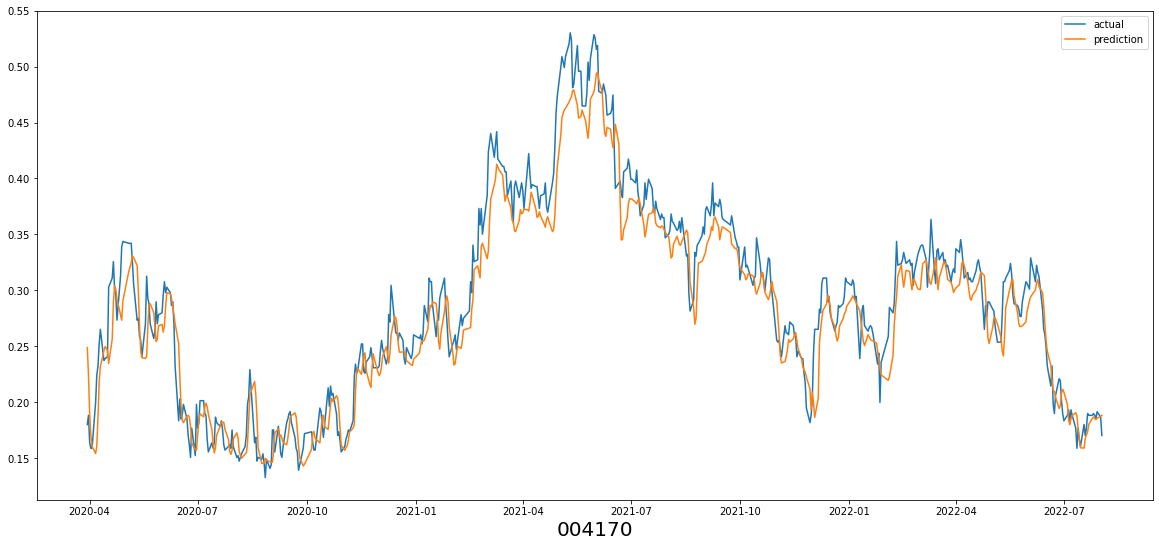

---------------Power---------------
015760의 test_data의 출력 크기 :  (580, 1)


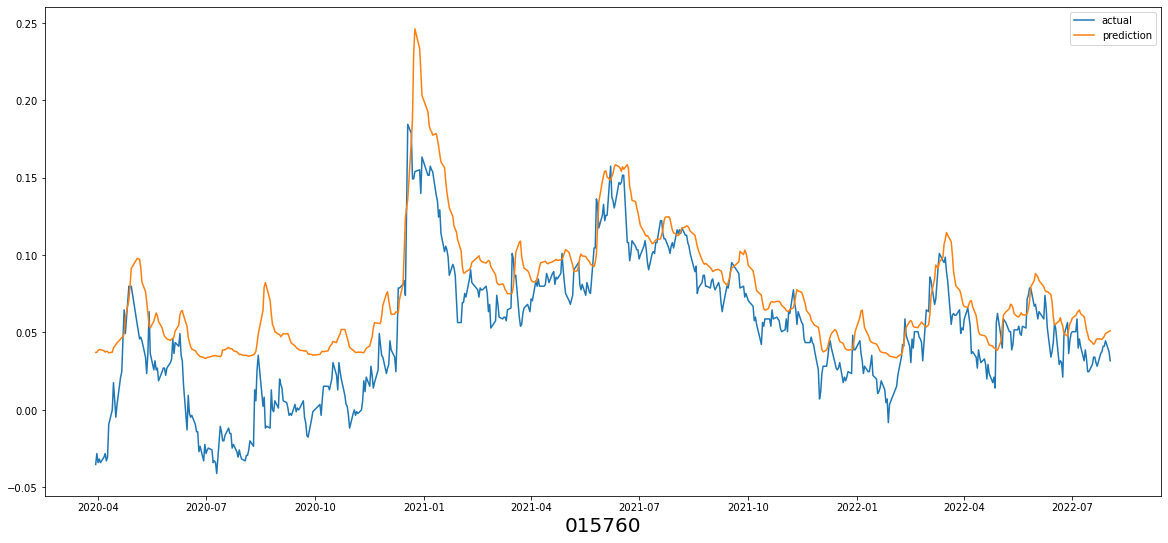

036460의 test_data의 출력 크기 :  (580, 1)


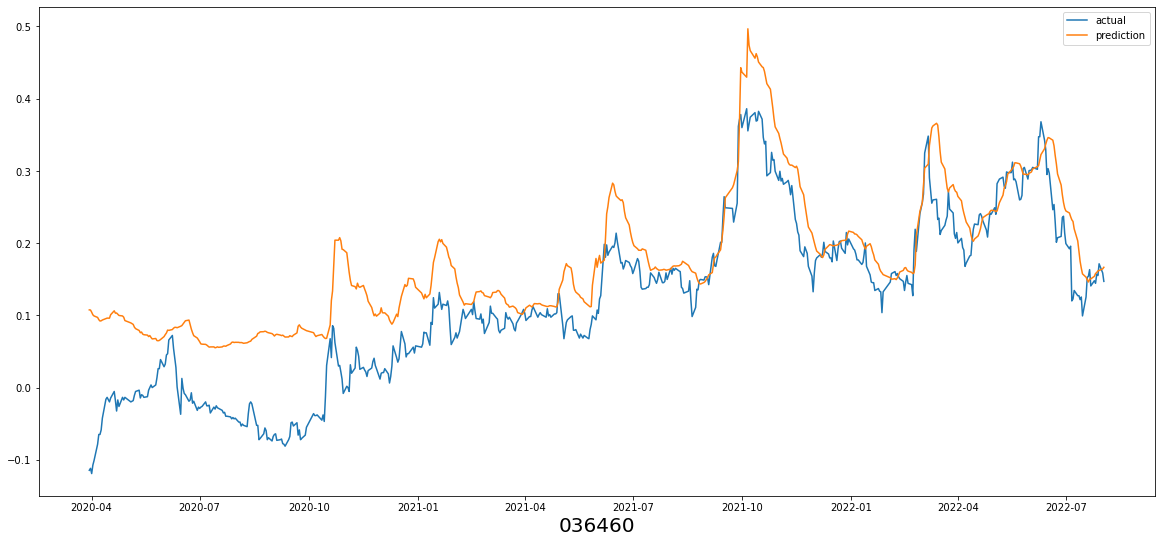

017390의 test_data의 출력 크기 :  (580, 1)


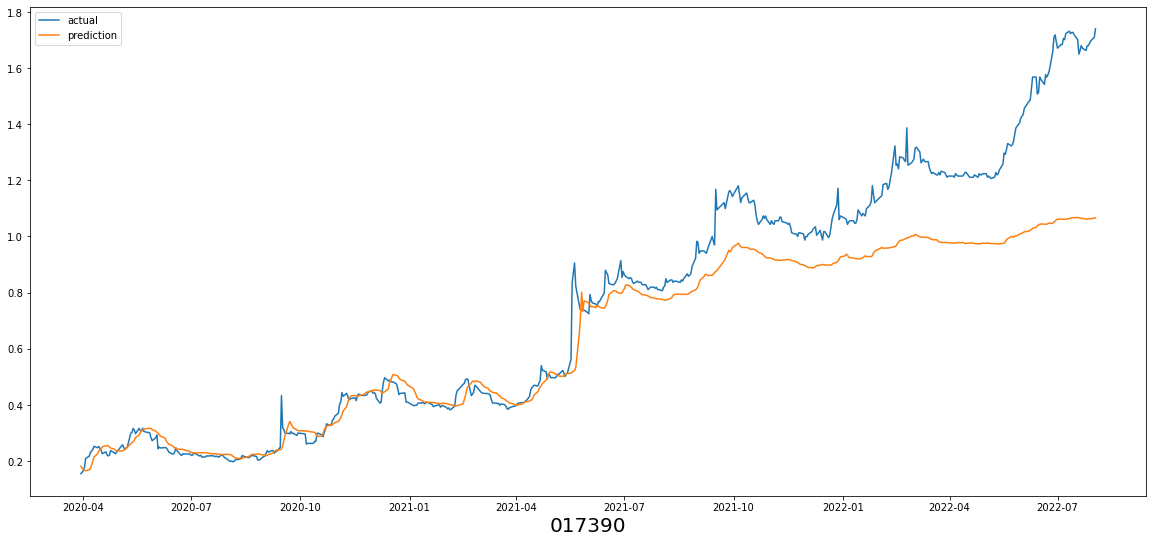

---------------Tele---------------
017670의 test_data의 출력 크기 :  (580, 1)


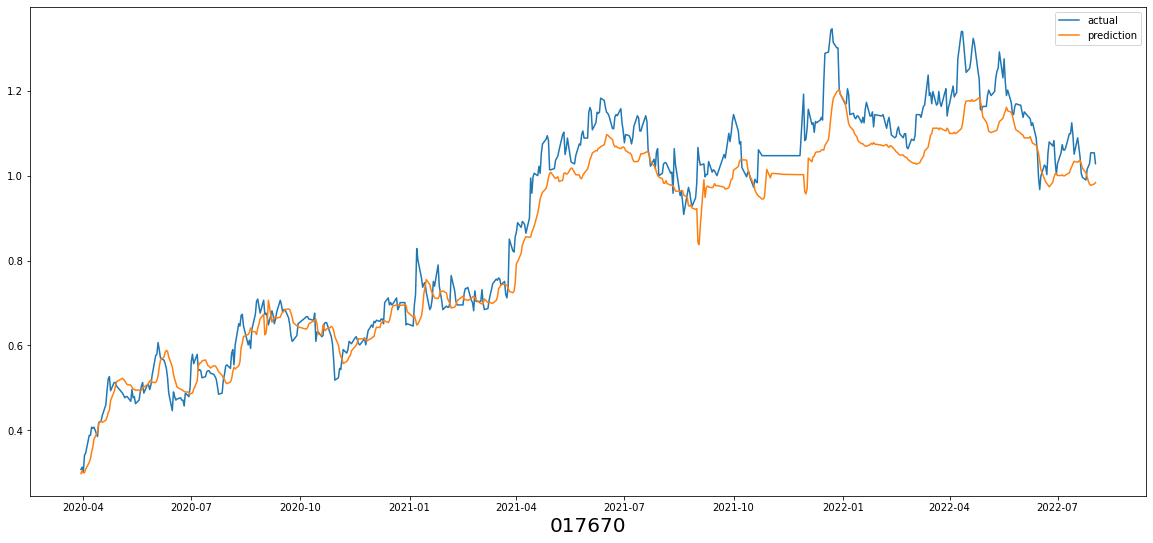

030200의 test_data의 출력 크기 :  (580, 1)


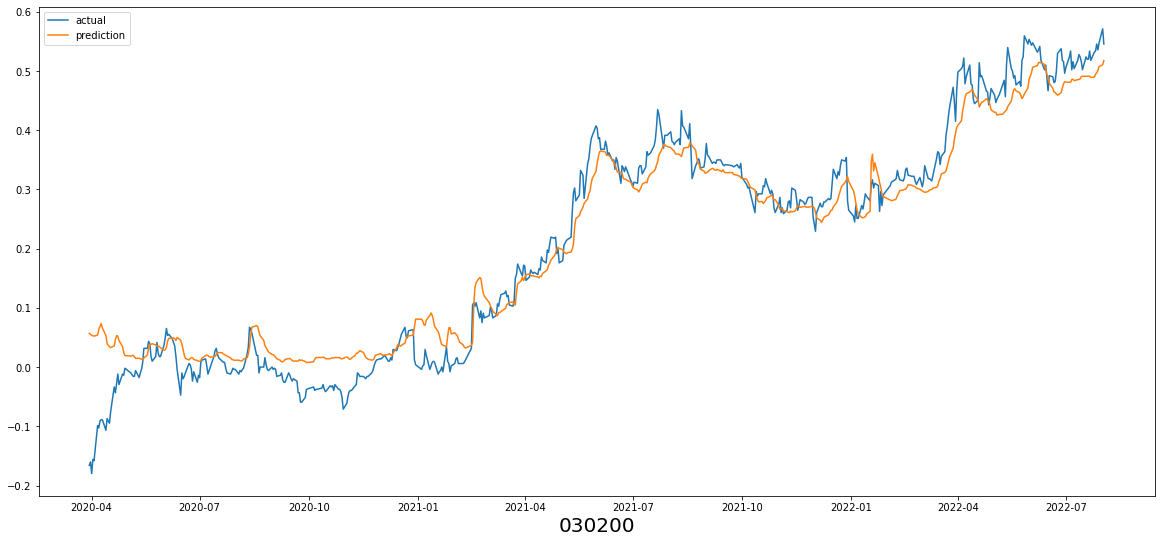

032640의 test_data의 출력 크기 :  (580, 1)


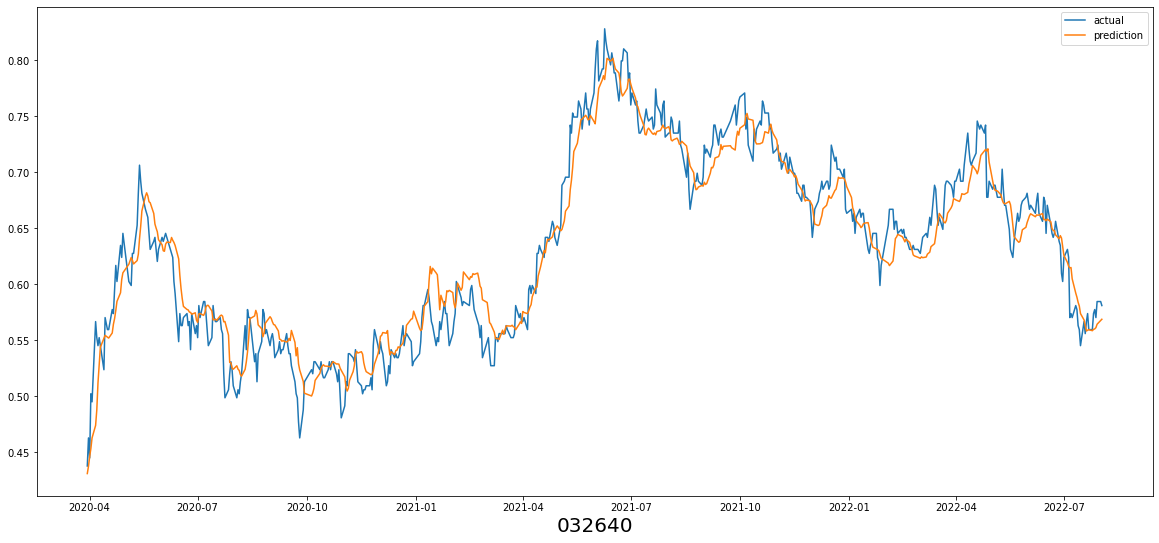

---------------Finance---------------
003550의 test_data의 출력 크기 :  (580, 1)


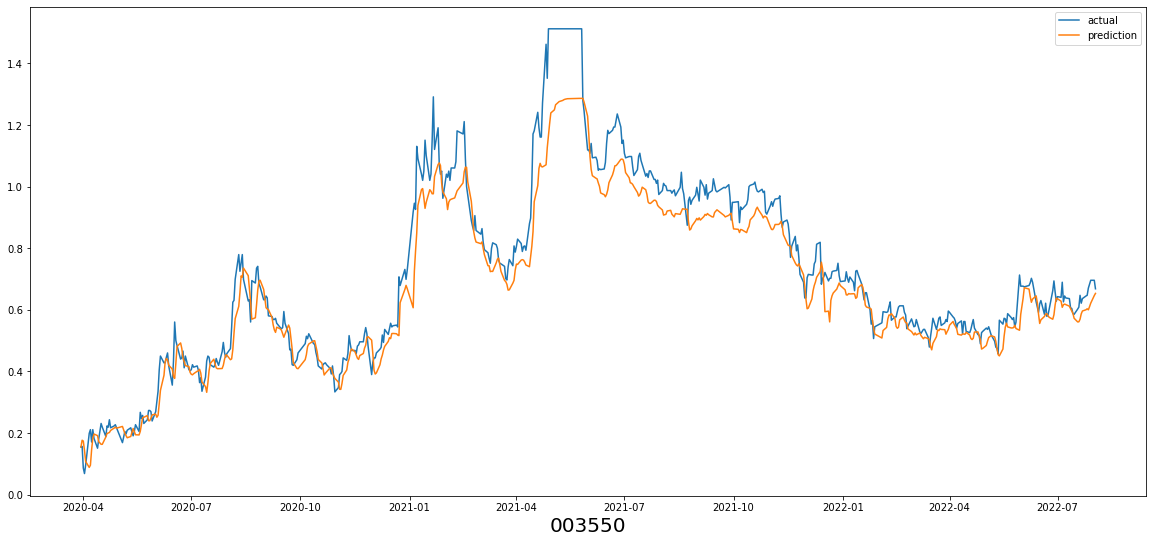

000810의 test_data의 출력 크기 :  (580, 1)


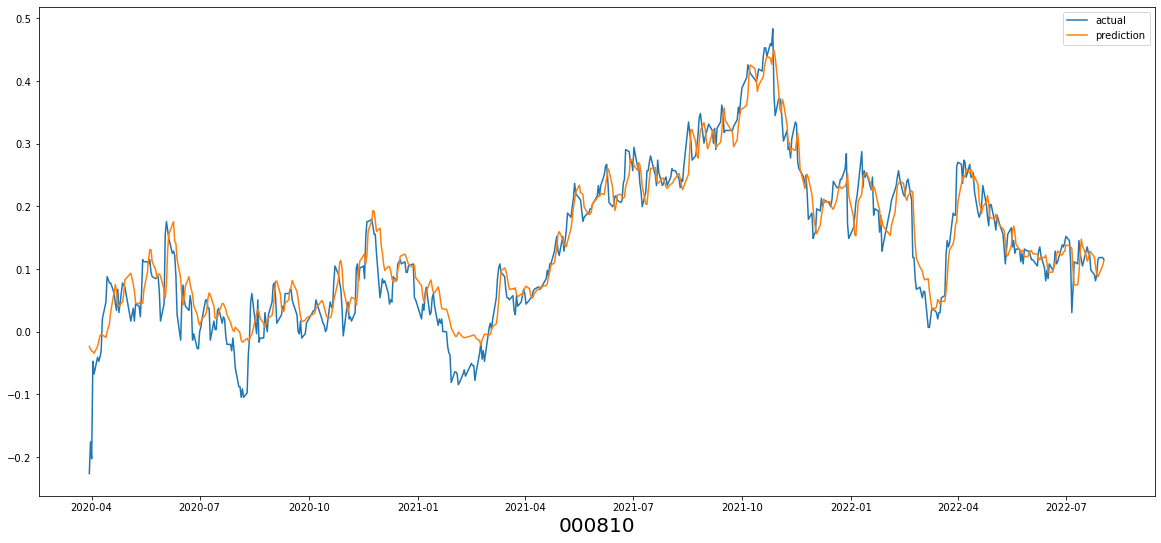

006800의 test_data의 출력 크기 :  (580, 1)


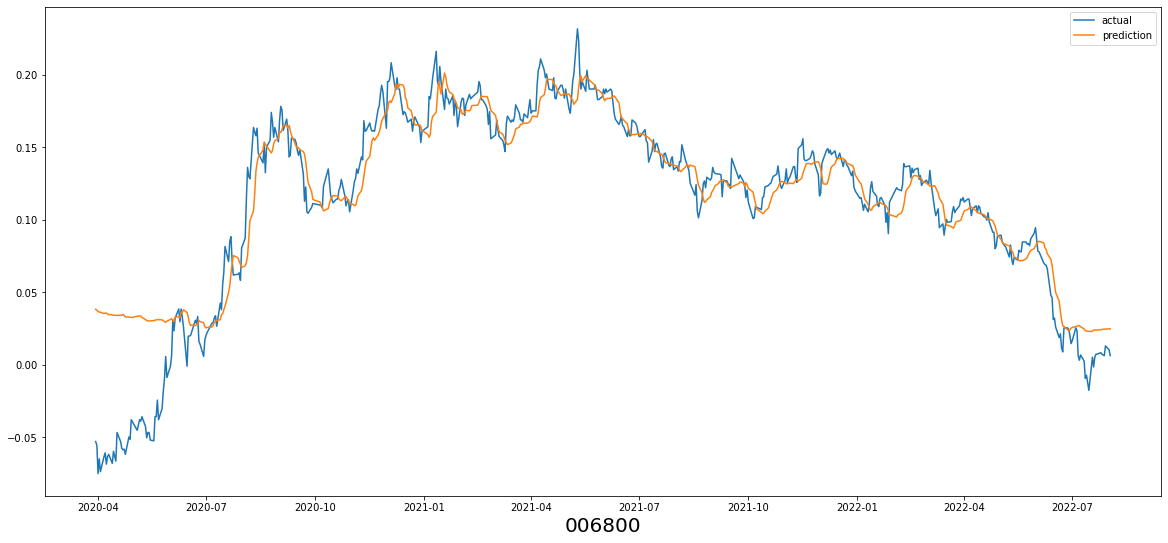

---------------Brokerage---------------
005940의 test_data의 출력 크기 :  (580, 1)


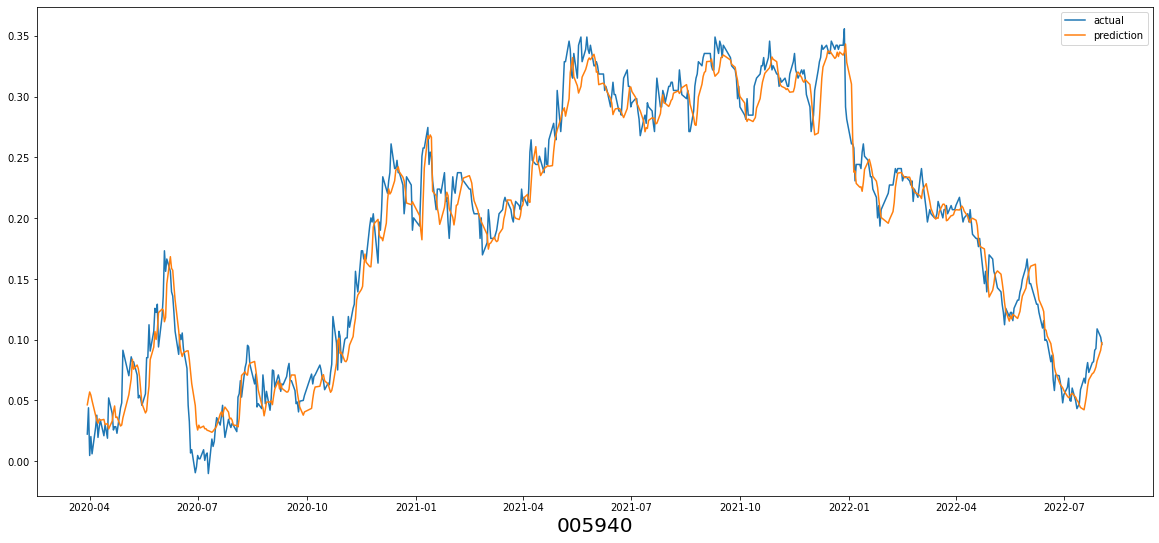

016360의 test_data의 출력 크기 :  (580, 1)


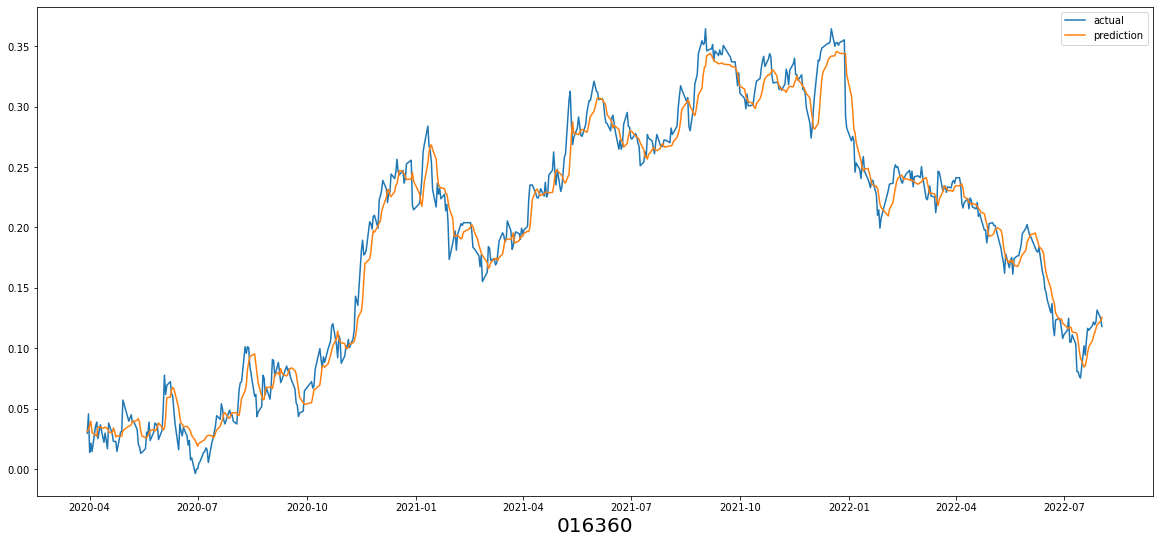

008560의 test_data의 출력 크기 :  (580, 1)


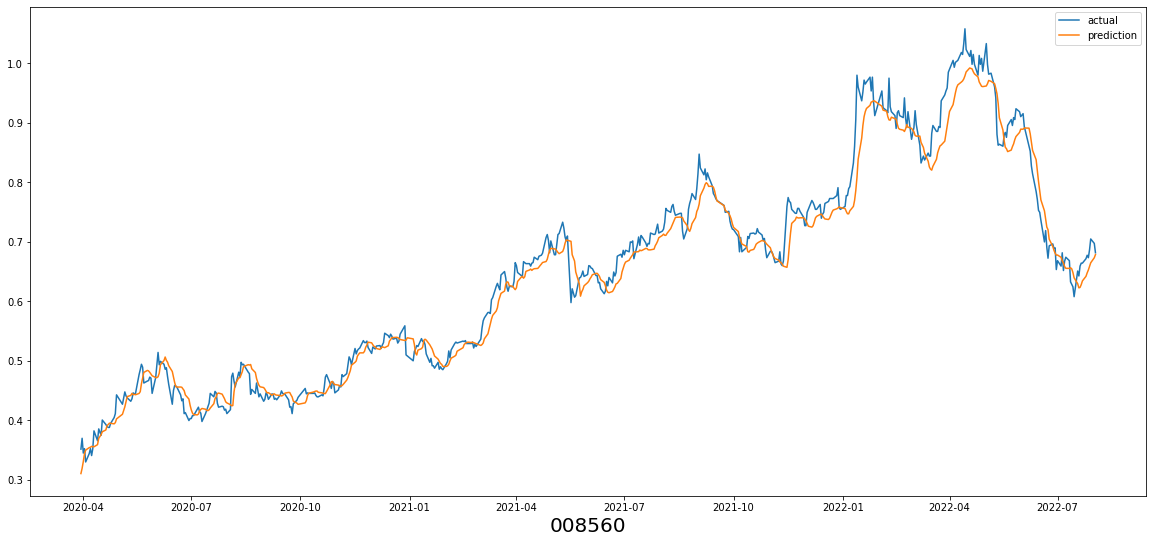

039490의 test_data의 출력 크기 :  (580, 1)


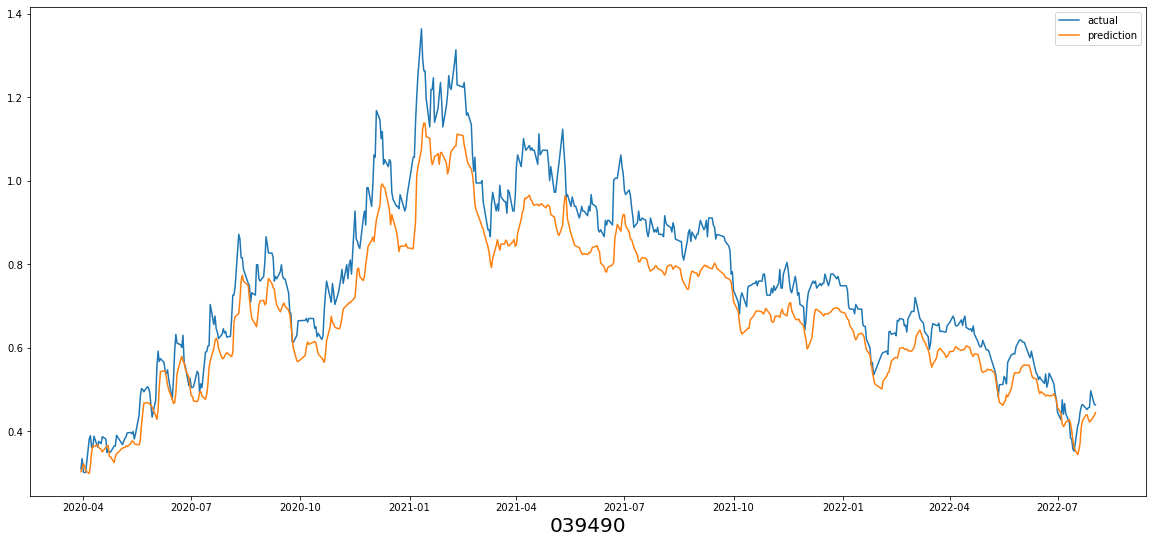

---------------Insurer---------------
032830의 test_data의 출력 크기 :  (580, 1)


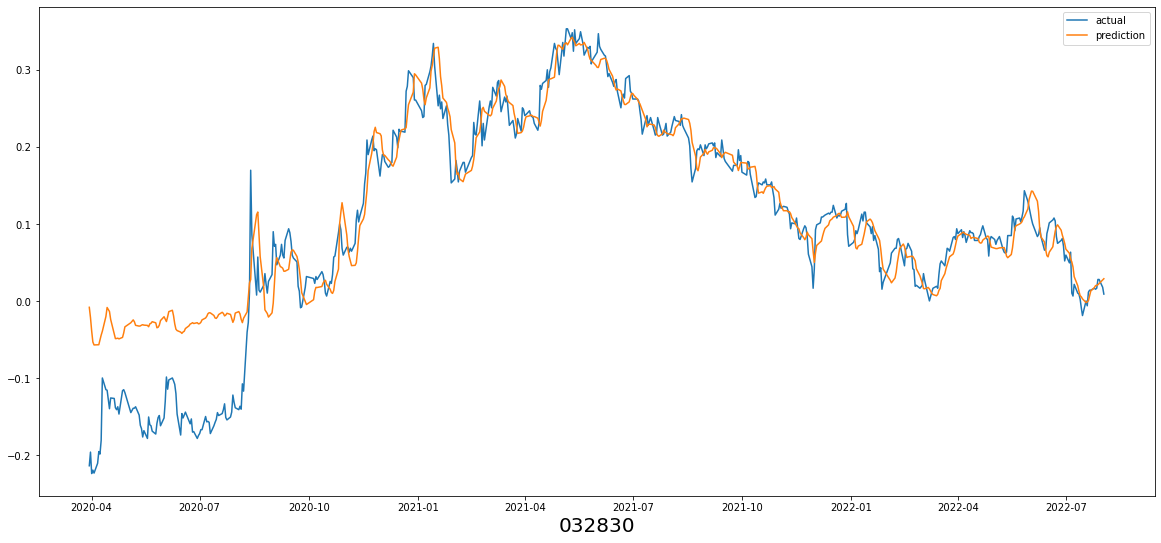

005830의 test_data의 출력 크기 :  (580, 1)


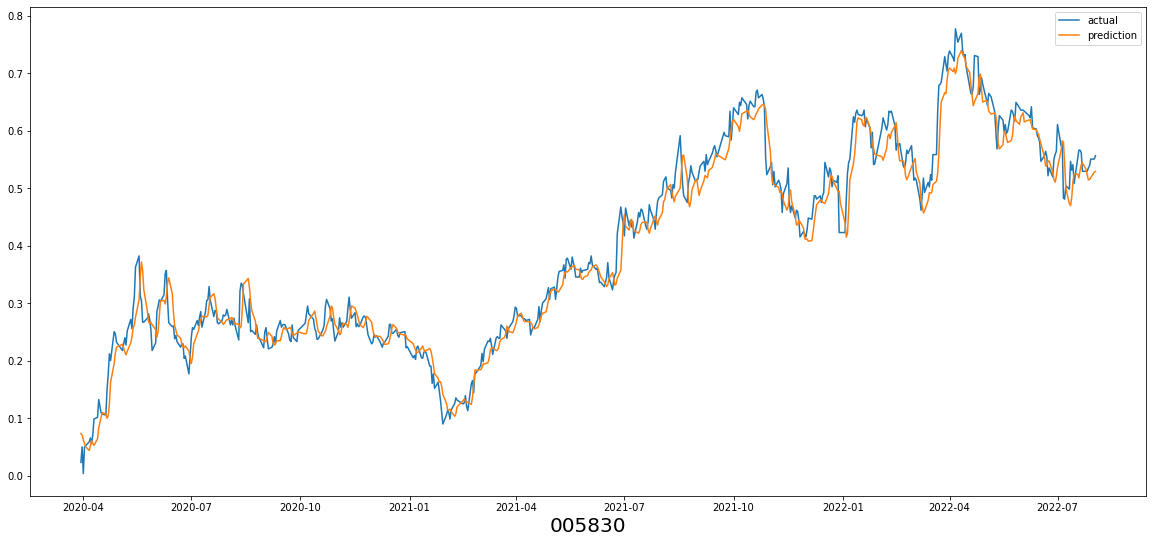

000060의 test_data의 출력 크기 :  (580, 1)


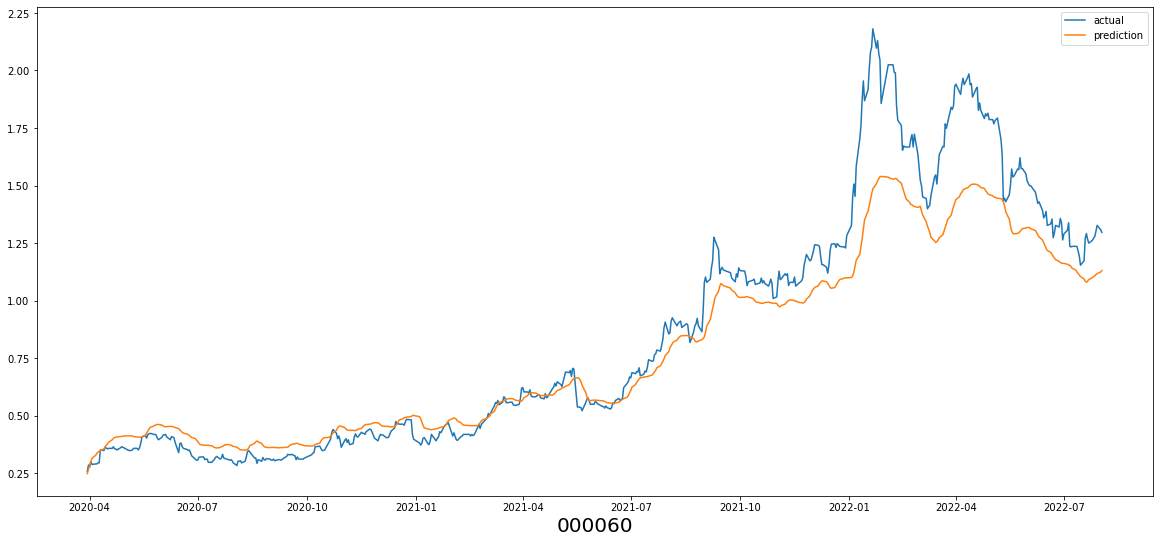

001450의 test_data의 출력 크기 :  (580, 1)


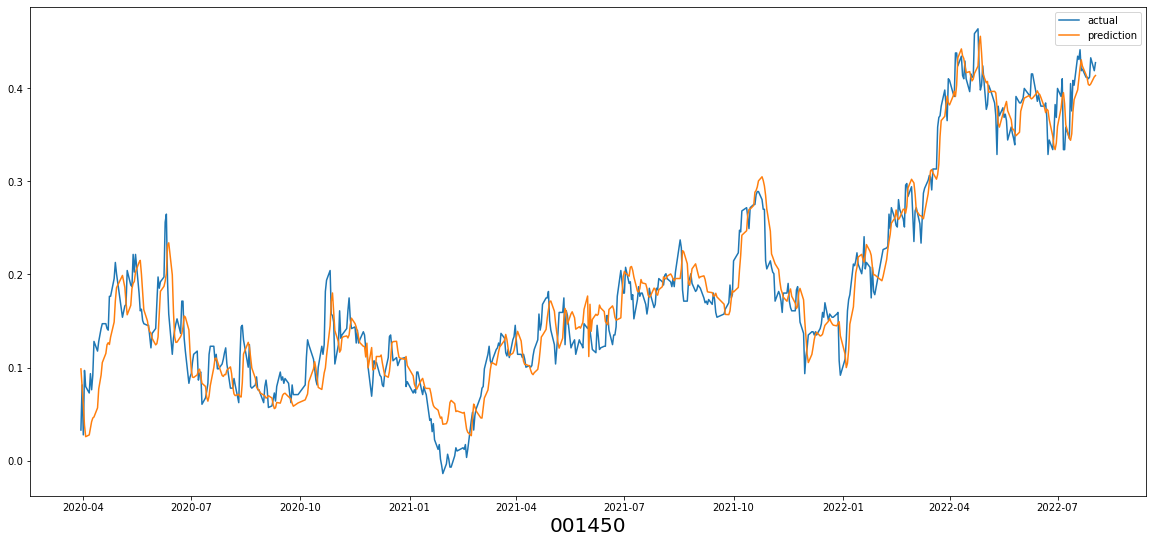

---------------Service---------------
035420의 test_data의 출력 크기 :  (580, 1)


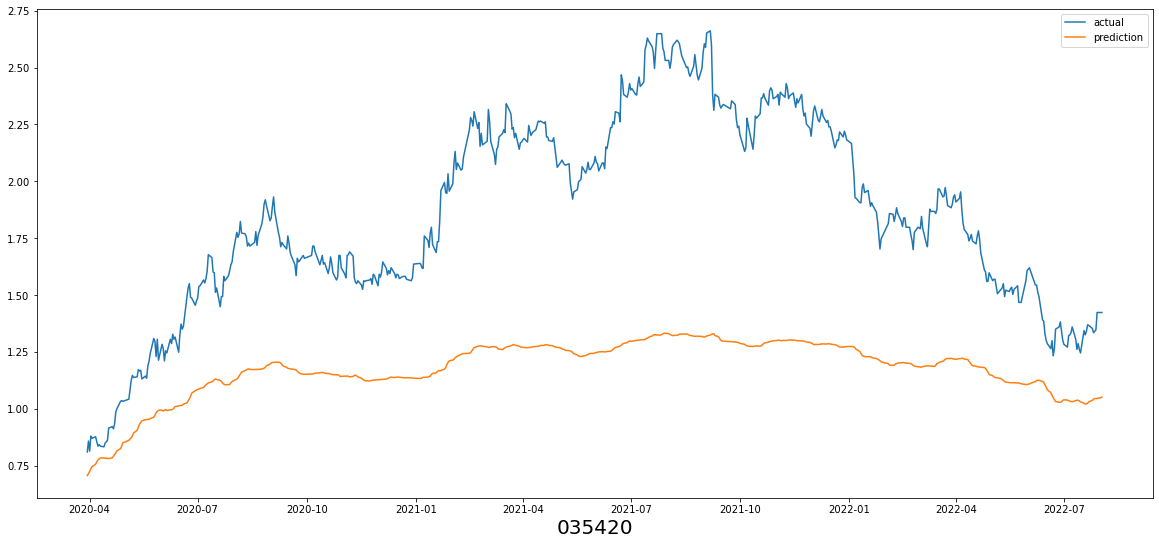

035720의 test_data의 출력 크기 :  (580, 1)


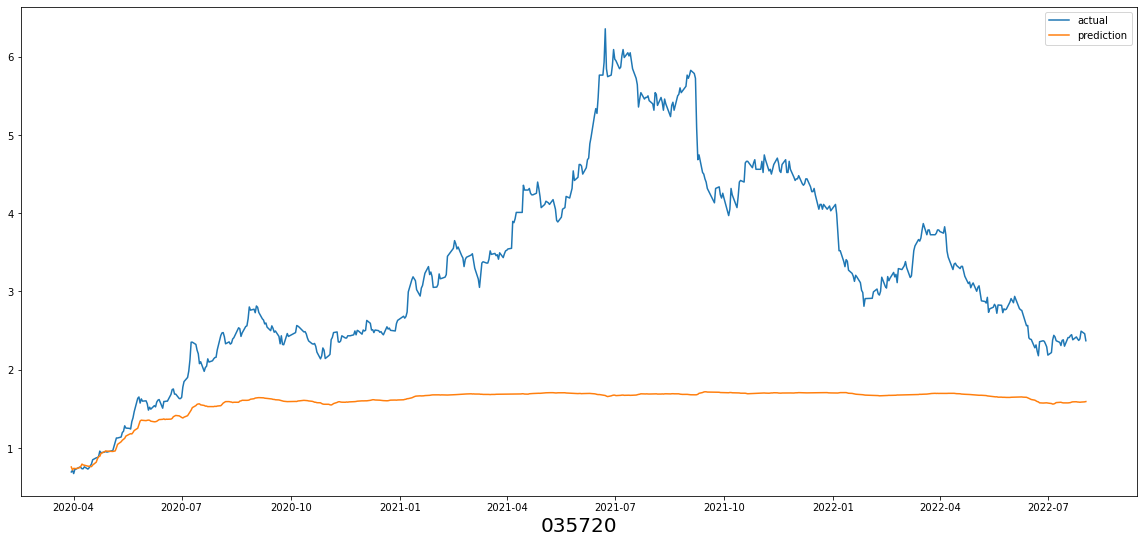

018260의 test_data의 출력 크기 :  (371, 1)


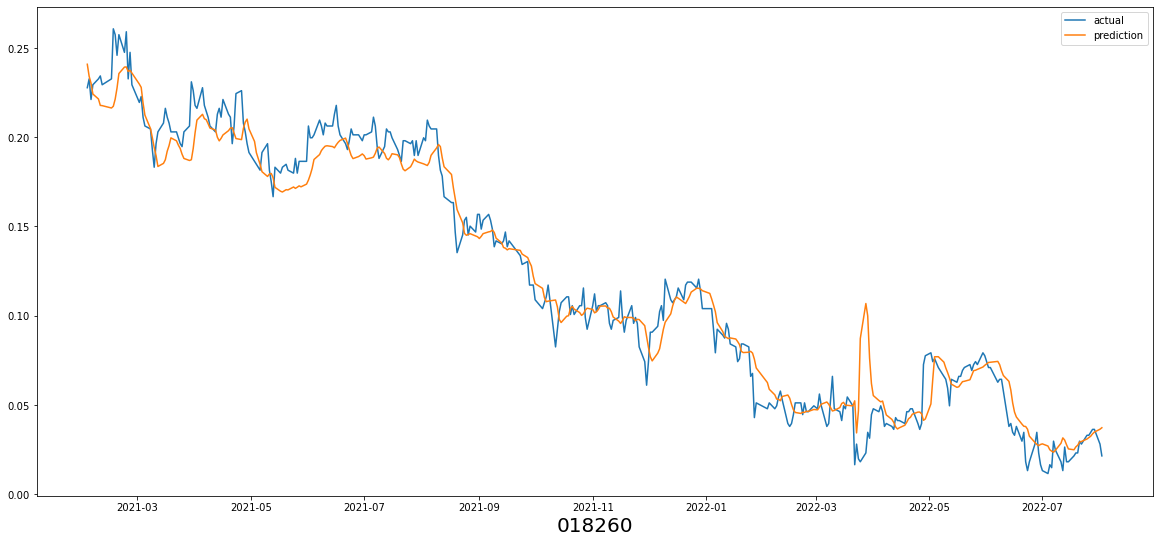

036570의 test_data의 출력 크기 :  (580, 1)


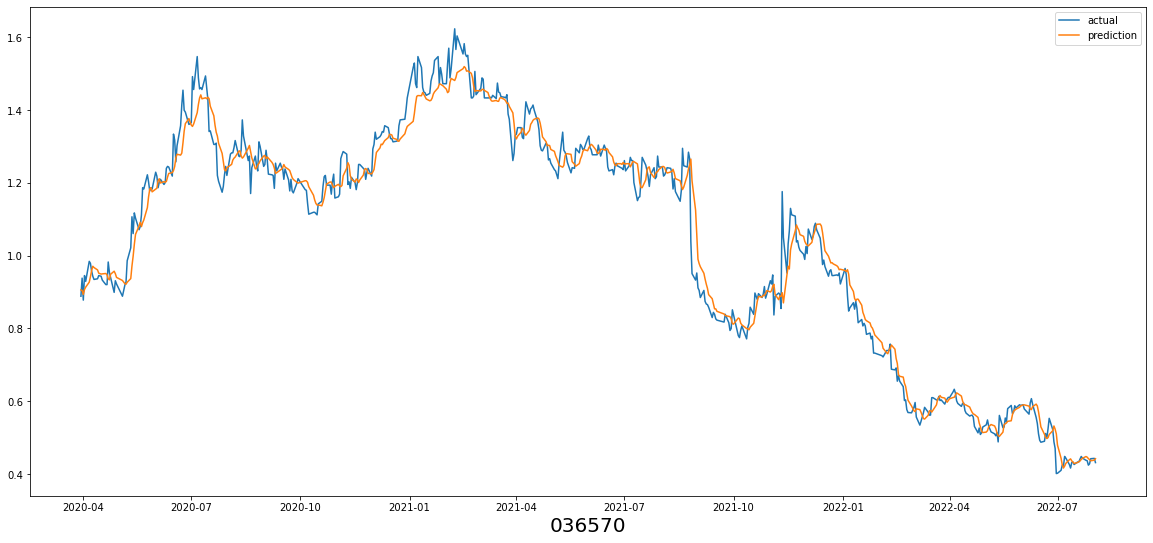

---------------Manufacturer---------------
005380의 test_data의 출력 크기 :  (580, 1)


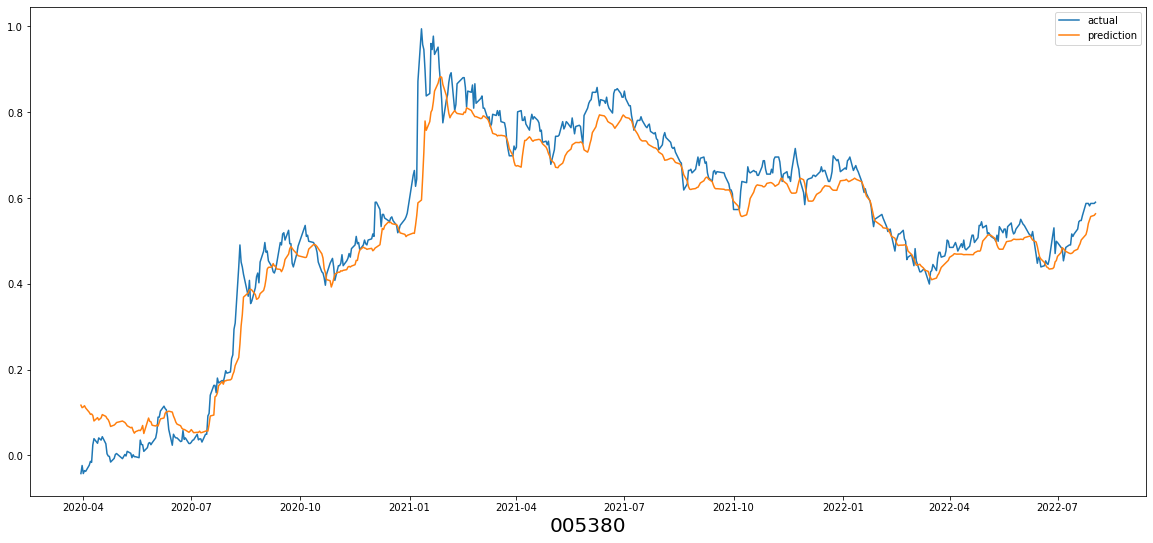

000270의 test_data의 출력 크기 :  (580, 1)


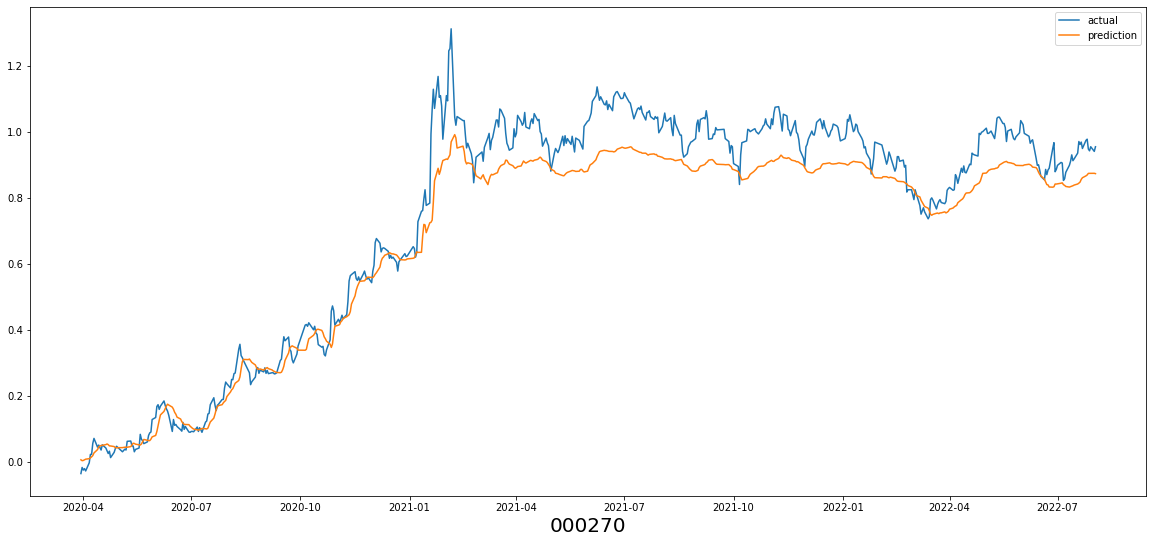

012330의 test_data의 출력 크기 :  (580, 1)


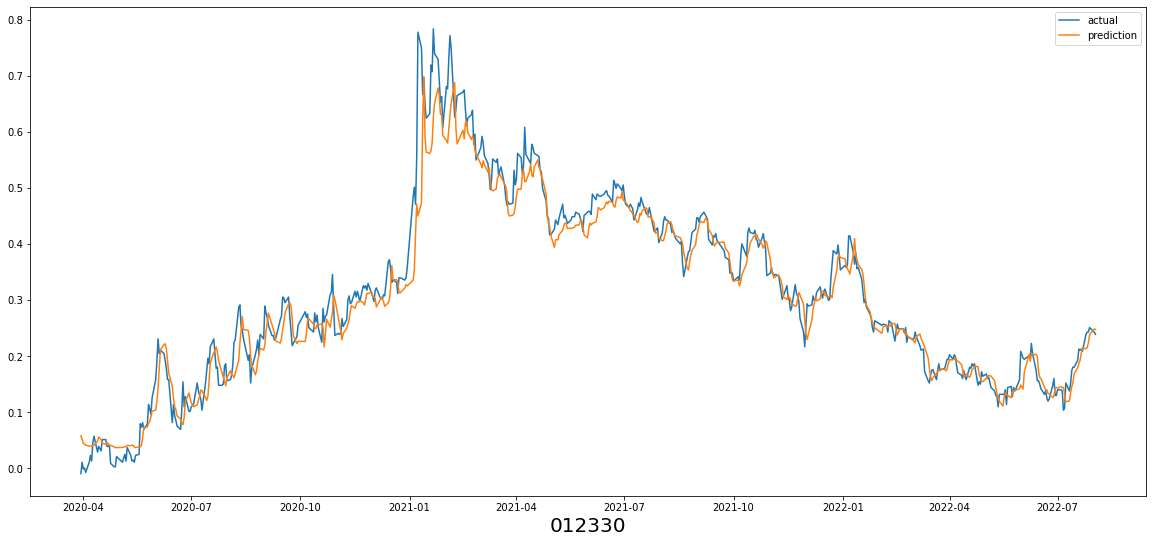

033780의 test_data의 출력 크기 :  (580, 1)


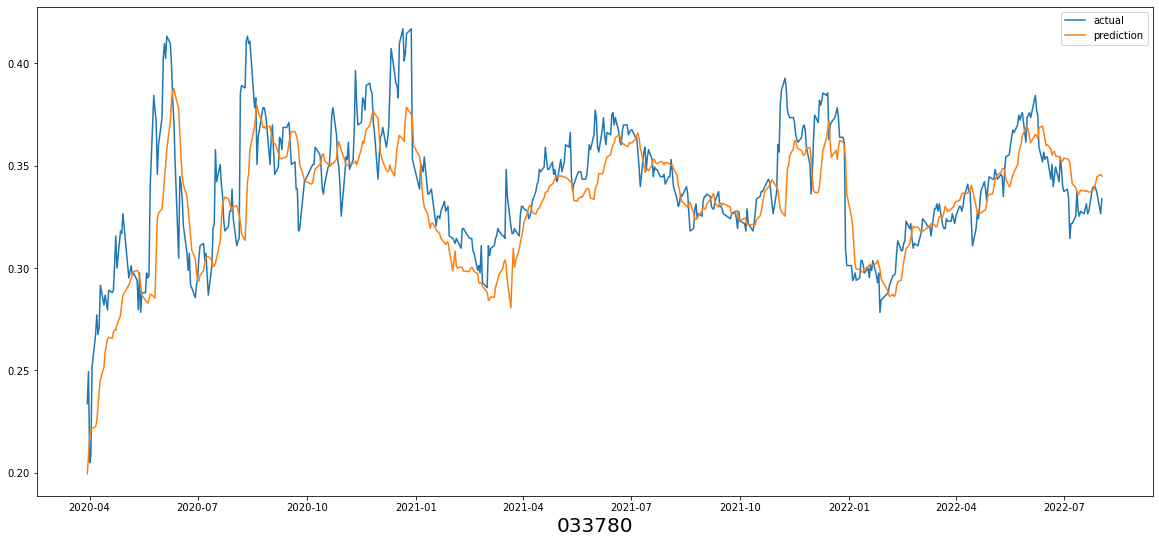

009150의 test_data의 출력 크기 :  (580, 1)


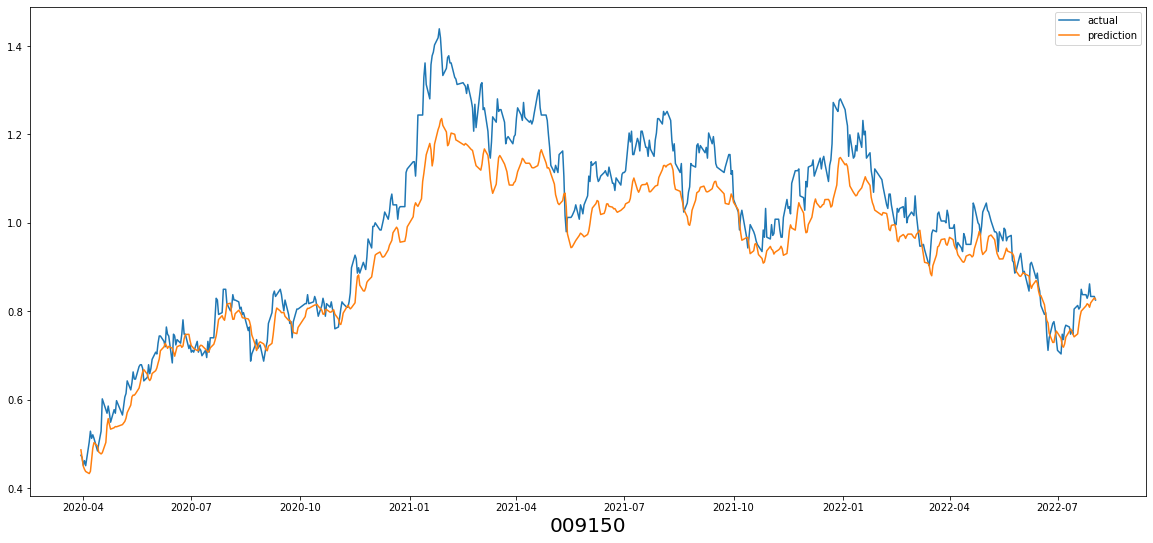

In [25]:
for sector_name, sector_model_dic in model_dic.items():
    print('-'*15+f'{sector_name}'+'-'*15)
    for stock_code, model in sector_model_dic.items():
        df_일자 = (y_test_scaled_dic[sector_name][stock_code].index)[WINDOW_SIZE:]
        pred = model.predict(tf_dataset_test_dic[sector_name][stock_code])
        print(f'{stock_code}의 test_data의 출력 크기 : ' ,pred.shape)
        plt.figure(figsize=(20, 9))
        plt.xlabel(stock_code, fontdict={'size': 20})
        plt.plot(df_일자,np.asarray(y_test_scaled_dic[sector_name][stock_code])[WINDOW_SIZE:], label='actual')
        plt.plot(df_일자,pred, label='prediction')
        plt.legend()
        plt.show()

In [26]:
score_dic = {}
for sector_name, sector_model in model_dic.items():
    score_dic[sector_name] = {}
    print(f'------------------{sector_name}별 점수----------------')
    for stock_code, model in sector_model.items():
        score = model.evaluate(tf_dataset_test_dic[sector_name][stock_code])
        score_dic[sector_name][stock_code] = score
        print(f'{stock_code} 모델의 성능 지표 : MSE =  {score[1]:0.4f}, loss= {score[0]:0.4f}')

------------------Food별 점수----------------
19/19 [==============================] - 1s 11ms/step - loss: 0.0025 - mse: 0.0050
097950 모델의 성능 지표 : MSE =  0.0050, loss= 0.0025
8/8 [==============================] - 0s 14ms/step - loss: 6.8294e-04 - mse: 0.0014
271560 모델의 성능 지표 : MSE =  0.0014, loss= 0.0007
19/19 [==============================] - 0s 10ms/step - loss: 0.0013 - mse: 0.0025
000080 모델의 성능 지표 : MSE =  0.0025, loss= 0.0013
19/19 [==============================] - 0s 10ms/step - loss: 3.4283e-04 - mse: 6.8566e-04
004370 모델의 성능 지표 : MSE =  0.0007, loss= 0.0003
19/19 [==============================] - 0s 10ms/step - loss: 2.9589e-04 - mse: 5.9178e-04
005300 모델의 성능 지표 : MSE =  0.0006, loss= 0.0003
------------------Clothing별 점수----------------
19/19 [==============================] - 0s 10ms/step - loss: 2.1169e-04 - mse: 4.2338e-04
093050 모델의 성능 지표 : MSE =  0.0004, loss= 0.0002
19/19 [==============================] - 0s 10ms/step - loss: 7.0928e-04 - mse: 0.0014
020000 모델의 성능 지표 

In [27]:
with open('score_dic.pickle','wb') as f:
    pickle.dump(score_dic,f)
